In [1]:
pip install rdkit pandas scikit-learn matplotlib seaborn lightgbm lazypredict tqdm pathlib tqdm lazypredict pathlib lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Patch scikit-learn's OneHotEncoder to use sparse_output instead of sparse
from sklearn.preprocessing import OneHotEncoder

# Create a patched version of OneHotEncoder
class PatchedOneHotEncoder(OneHotEncoder):
    def __init__(self, *args, sparse=False, **kwargs):
        kwargs["sparse_output"] = sparse
        super().__init__(*args, **kwargs)

# Replace the OneHotEncoder in sklearn with the patched version
import sklearn.preprocessing
sklearn.preprocessing.OneHotEncoder = PatchedOneHotEncoder


Load and Explore the Data

Read the CSV file: Use pandas to read your dataset.

In [3]:
# Install all modules used in this project

# Patch scikit-learn's OneHotEncoder to use sparse_output instead of sparse
from sklearn.preprocessing import OneHotEncoder

# Create a patched version of OneHotEncoder
class PatchedOneHotEncoder(OneHotEncoder):
    def __init__(self, *args, sparse=False, **kwargs):
        kwargs["sparse_output"] = sparse
        super().__init__(*args, **kwargs)

# Replace the OneHotEncoder in sklearn with the patched version
import sklearn.preprocessing
sklearn.preprocessing.OneHotEncoder = PatchedOneHotEncoder

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

import lazypredict
OneHotEncoder(handle_unknown="ignore", sparse_output=False)
from lazypredict.Supervised import LazyRegressor

from tqdm import tqdm
#from tqdm import tqdmcore


In [3]:
# Load the CSV file
file_path = 'CCS_smiles.csv'
df = pd.read_csv(file_path, quotechar='"',delimiter=',')
#read columns 
print(df.columns)


Index(['CCS', 'Molecular_Weight', 'LogP', 'H_Donors', 'H_Acceptors',
       'Rotatable_Bonds', 'SMILES'],
      dtype='object')


In [89]:
df = df.dropna()  # Optionally, drop rows with missing values

Now we want to check the data that we have as dataset for training and test sets

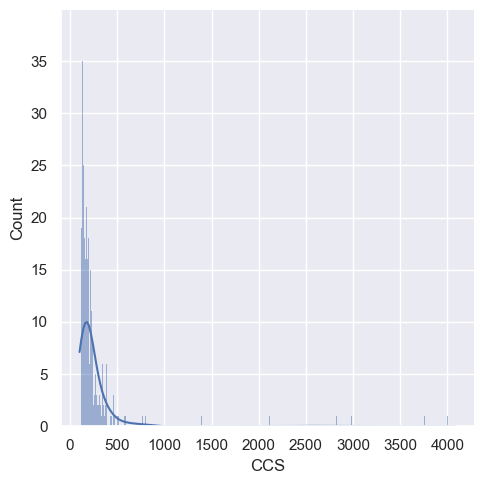

In [71]:
import seaborn as sn

sn.set_theme()
sn.displot(data=df, x="CCS", binwidth=1, kde=True)

As we only have small organic molecules we gonna filter the data to have a maximum of 500 Angström of CCS 

In [72]:
new_data_set = df[df.CCS.apply(lambda x: x > 90.0 and x < 250.0)]

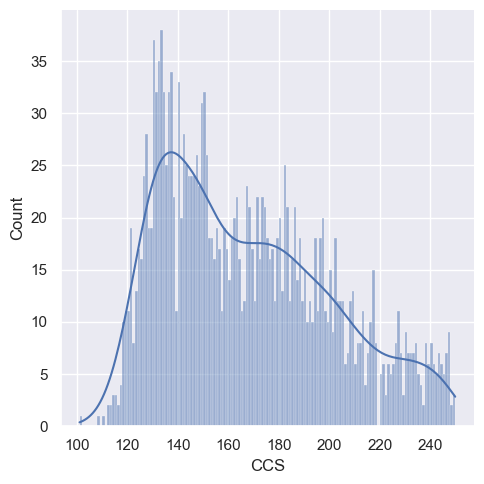

In [73]:
sn.displot(data=new_data_set, x="CCS", binwidth=1, kde=True)

In [90]:
new_data_set.to_csv('Data_Cleaned_CCS.csv', index=False)

In [91]:
data_dl = 'Data_Cleaned_CCS.csv'

Calculate molecular descriptor and save it 

In [76]:
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from tqdm import tqdm
from rdkit import Chem

def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0]
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in tqdm(mols):
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(new_data_set['SMILES'])

100%|██████████████████████████████████████████████████████████████████████████████| 1992/1992 [00:42<00:00, 46.50it/s]


In [77]:
df_descriptors = pd.DataFrame(Mol_descriptors, columns=desc_names)
df_descriptors.head()

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  qed  \
0              13.92           13.92               0.12           -6.94 0.05   
1              13.92           13.92               0.12           -6.94 0.05   
2              13.92           13.92               0.12           -6.94 0.05   
3              13.92           13.92               0.12           -6.94 0.05   
4              14.10           14.10               0.33           -7.12 0.06   

    SPS  MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  ...  \
0 54.55 665.42          638.21      665.10                  240  ...   
1 54.55 665.42          638.21      665.10                  240  ...   
2 54.55 665.42          638.21      665.10                  240  ...   
3 54.55 665.42          638.21      665.10                  240  ...   
4 55.50 745.43          715.19      745.09                  266  ...   

   fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0           0             0           0                  0             0   
1           0             0           0                  0             0   
2           0             0           0                  0             0   
3           0             0           0                  0             0   
4           0             0           0                  0             0   

   fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0            0            0             0                 0        0  
1            0            0             0                 0        0  
2            0            0             0                 0        0  
3            0            0             0                 0        0  
4            0            0             0                 0        0  

[5 rows x 210 columns]

Calculate molecular descriptors for the test data.

In [92]:
#load test data
data_dl = pd.read_csv("Data_Cleaned_CCS.csv", delimiter=',')
Mol_descriptors_test , desc_names_test = RDkit_descriptors(data_dl["SMILES"])
data_dl_descriptors = pd.DataFrame(Mol_descriptors_test,columns=desc_names_test)

100%|██████████████████████████████████████████████████████████████████████████████| 1992/1992 [00:43<00:00, 45.30it/s]


save in .csv file

In [93]:
df_descriptors.to_csv('Data_descriptor.csv', index=False)
data_dl_descriptors.to_csv('Data_Test_descriptor.csv', index=False)

Make training and validation set

In [4]:
#data_dl = pd.read_csv('data_dl.csv', delimiter=',')
#data_dl= data_dl[data_dl['CCS'].apply(lambda x: x > 90.0 and x < 250.0)]
df_descriptors = pd.read_csv('Data_descriptor.csv', delimiter=',')
data_cleaned_final = pd.read_csv("Data_Cleaned_CCS.csv", delimiter=',')
#data_dl_descriptors = pd.read_csv("Data_Test_descriptor.csv", delimiter=',')

Split the data for training and testing set

In [5]:
x_train, x_valid, y_train, y_valid = train_test_split(df_descriptors, data_cleaned_final.CCS, test_size=0.1,random_state=42)

In [114]:
# Check for NaNs
import numpy as np
print(np.any(np.isnan(x_train)))  # Should return False
print(np.any(np.isnan(y_train)))  # Should return False

# Check for infinite values
print(np.any(np.isinf(x_train)))  # Should return False
print(np.any(np.isinf(y_train)))  # Should return False

# Check data shape
print(x_train.shape, y_train.shape)


True
False
False
False
(1792, 210) (1792,)


In [6]:
import pandas as pd
import numpy as np

# Convert x_train and y_train to pandas DataFrame/Series if not already
x_train_df = pd.DataFrame(x_train)
y_train_df = pd.Series(y_train)

# Check for NaNs in x_train
print("Number of NaNs in x_train:", x_train_df.isna().sum().sum())

# Combine x_train and y_train for simultaneous row filtering
data = pd.concat([x_train_df, y_train_df], axis=1)

# Drop rows with NaN values in any column
data_cleaned = data.dropna()

# Separate back into x_train and y_train
x_train = data_cleaned.iloc[:, :-1].values  # All columns except the last
y_train = data_cleaned.iloc[:, -1].values   # The last column

# Check results
print("Shape of x_train before cleaning:", x_train.shape)
print("Shape of x_train after cleaning:", x_train_cleaned.shape)
print("Shape of y_train after cleaning:", y_train_cleaned.shape)


Number of NaNs in x_train: 164
Shape of x_train before cleaning: (1774, 210)


NameError: name 'x_train_cleaned' is not defined

In [126]:
# Check for NaNs
import numpy as np
print(np.any(np.isnan(x_train)))  # Should return False
print(np.any(np.isnan(y_train)))  # Should return False

# Check for infinite values
print(np.any(np.isinf(x_train)))  # Should return False
print(np.any(np.isinf(y_train)))  # Should return False

# Check data shape
print(x_train.shape, y_train.shape)

False
False
False
False
(1774, 210) (1774,)


In [7]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

LazyRegressor

In [118]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled, x_valid_scaled, y_train, y_valid)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:37<00:00,  1.57it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18969
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 164
[LightGBM] [Info] Start training from score 167.901296


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:37<00:00,  1.13it/s]


In [119]:
prediction_tests[:1000]

Adjusted R-Squared  \
Model                                                                              
Lars                          15217561335070988129868403625215310665844669808...   
RANSACRegressor                                       55080814770694647709696.00   
SGDRegressor                                                      92438847628.99   
KernelRidge                                                               503.28   
LinearRegression                                                          456.52   
TransformedTargetRegressor                                                456.52   
GaussianProcessRegressor                                                   70.17   
DummyRegressor                                                             19.35   
QuantileRegressor                                                          19.14   
MLPRegressor                                                                7.77   
PassiveAggressiveRegressor                                                  6.47   
NuSVR                                                                       4.95   
SVR                                                                         4.79   
GammaRegressor                                                              4.46   
HuberRegressor                                                              4.39   
LinearSVR                                                                   4.38   
PoissonRegressor                                                            4.37   
LarsCV                                                                      4.26   
OrthogonalMatchingPursuitCV                                                 4.11   
OrthogonalMatchingPursuit                                                   4.11   
Lasso                                                                       4.08   
LassoLars                                                                   4.07   
LassoLarsIC                                                                 4.03   
LassoLarsCV                                                                 4.03   
ElasticNet                                                                  3.97   
LassoCV                                                                     3.97   
TweedieRegressor                                                            3.86   
RidgeCV                                                                     3.86   
ElasticNetCV                                                                3.84   
BayesianRidge                                                               3.83   
Ridge                                                                       3.71   
KNeighborsRegressor                                                         3.47   
AdaBoostRegressor                                                           3.31   
DecisionTreeRegressor                                                       2.99   
ExtraTreeRegressor                                                          2.96   
LGBMRegressor                                                               2.86   
XGBRegressor                                                                2.84   
HistGradientBoostingRegressor                                               2.82   
RandomForestRegressor                                                       2.81   
BaggingRegressor                                                            2.79   
ExtraTreesRegressor                                                         2.69   
GradientBoostingRegressor                                                   2.65   

                                                                       R-Squared  \
Model                                                                              
Lars                          -8411717320893511852125840142473440237264568320...   
RANSACRegressor                                       -3044668153153975746560.00   
SGDRegressor                 

In [ ]:
#params = {'max_depth' : list(range(10, 20, 2)),
#          'n_estimators' : list(range(1100, 1300, 100)) ,
#          'learning_rate': list(np.arange(0.02, 0.04, 0.01))}

#grid_search = GridSearchCV(LGBMRegressor(random_state = 42),
#                            param_grid=params, cv=5, verbose=1)

#grid_search.fit(x_train, y_train)

#print("Optimized parameters for a LightGBM regressor can be: ", grid_search.best_params_)

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.04, 'max_depth': 20, 'n_estimators': 1278}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.04, 'max_depth': 20, 'n_estimators': 1278}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 1100}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 900}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 750}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.009000000000000001, 'max_depth': 3, 'n_estimators': 700}

Model training and testing set

In [9]:
model = LGBMRegressor(n_estimators = 700,
                      max_depth = 3,
                      learning_rate = 0.009,
                      random_state= 42)

model.fit(x_train_scaled,y_train)
y_preds = model.predict(x_valid_scaled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18969
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 164
[LightGBM] [Info] Start training from score 167.901296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [8]:
def plot_data(actual, predicted, title):

    rmse = np.sqrt(mean_squared_error(actual, predicted))

    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

    sn.regplot(x=predicted, y=actual, line_kws={"lw": 2, "ls": "--", "color": "red", "alpha": 0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted CCS", color="blue")
    plt.xlim(120, 250)
    plt.ylabel("Experimental CCS", color="blue")
    plt.grid(alpha=0.3)
    R2_patch = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse_patch = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2_patch, rmse_patch])

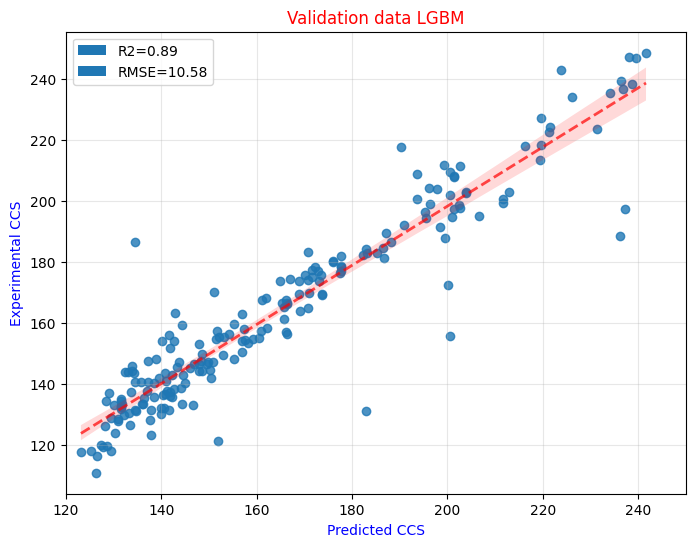

In [10]:
plot_data(y_valid, y_preds, "Validation data LGBM")

plt.savefig('data_LGBM.png')

data_to_save = pd.DataFrame({'True Values': y_valid, 'Predicted Values': y_preds})
data_to_save.to_csv('data_LGBM.csv', index=False)

In [16]:
y_valid

887    180.10
1671   217.80
414    145.80
1080   173.50
1102   138.70
        ...  
1105   137.30
382    119.70
254    156.30
1018   213.40
411    134.40
Name: CCS, Length: 200, dtype: float64

In [26]:
import pandas as pd

# Load the CSV file
file_path = 'data_descriptor.csv'
data = pd.read_csv(file_path)

# Extract the feature columns by excluding 'true_values' and 'predicted_values'
feature_columns = [col for col in data.columns if col not in ['true_values', 'predicted_values']]

print("Feature columns:", feature_columns)


Feature columns: ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 

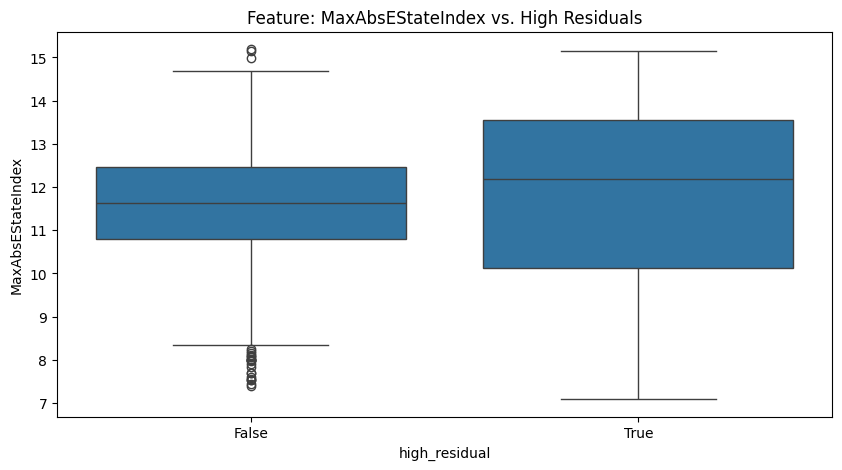

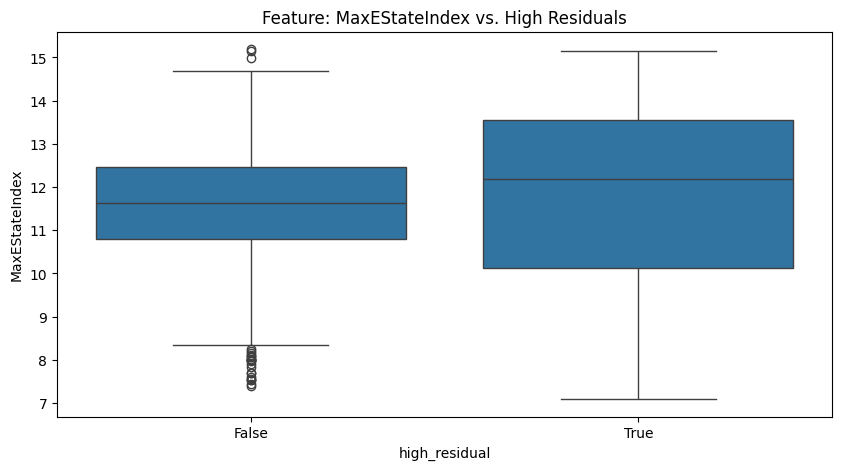

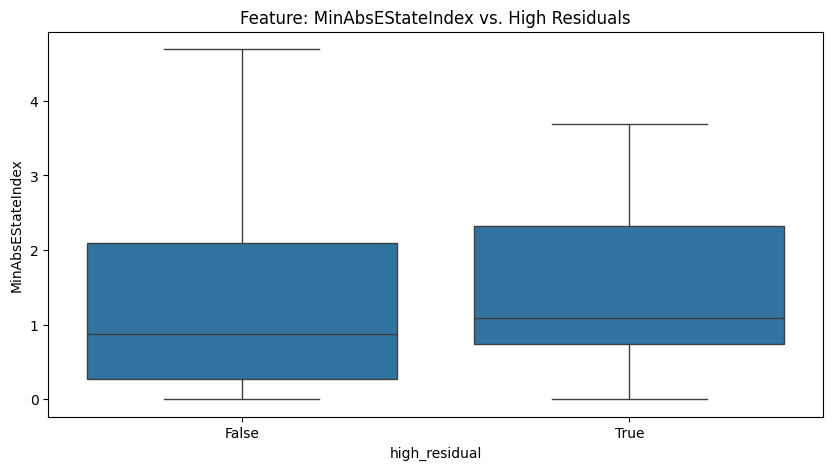

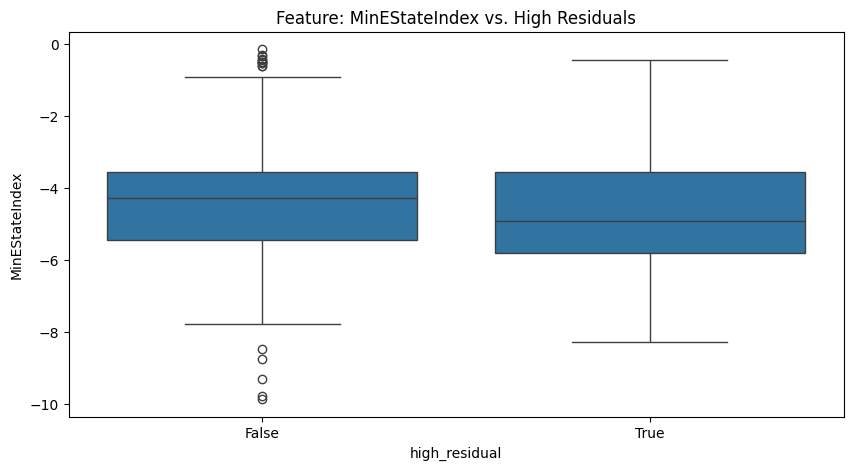

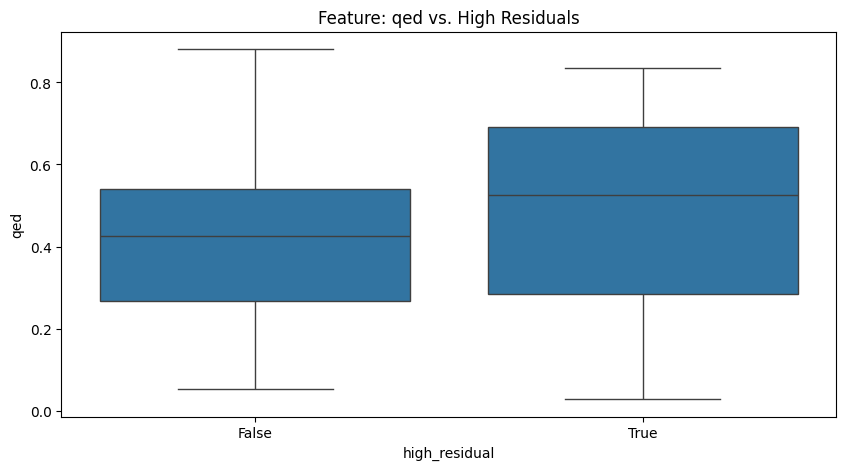

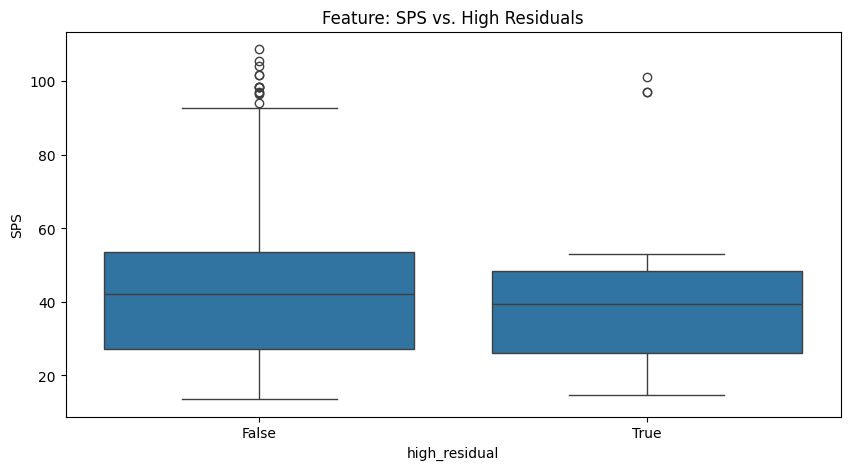

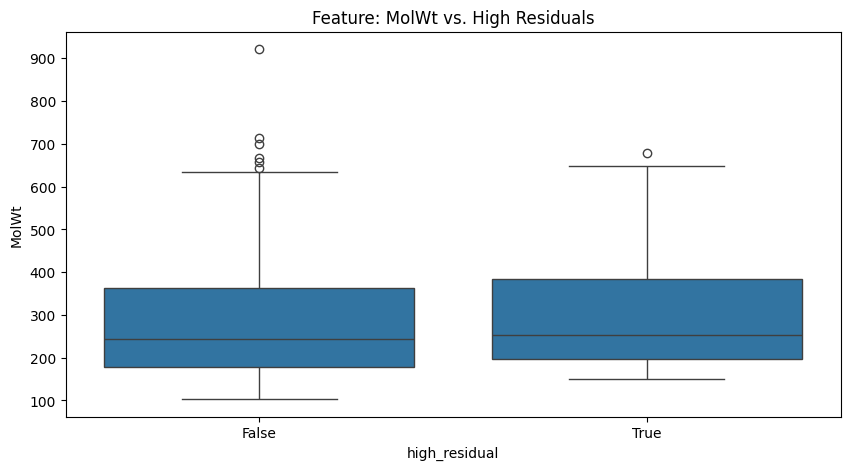

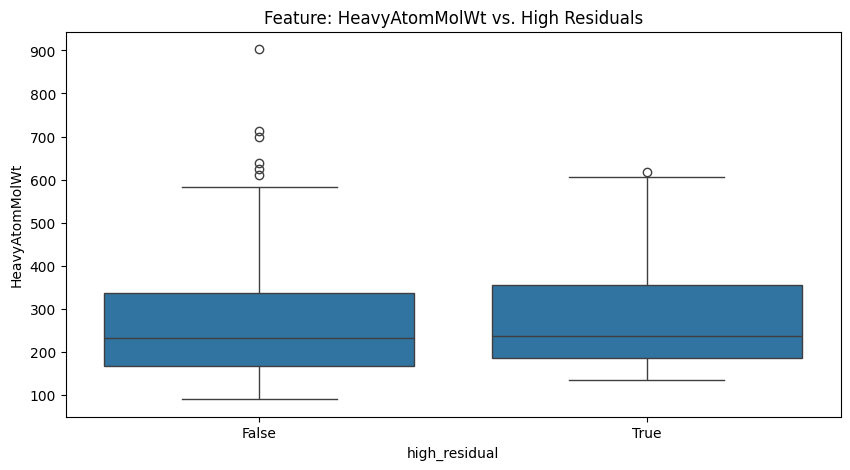

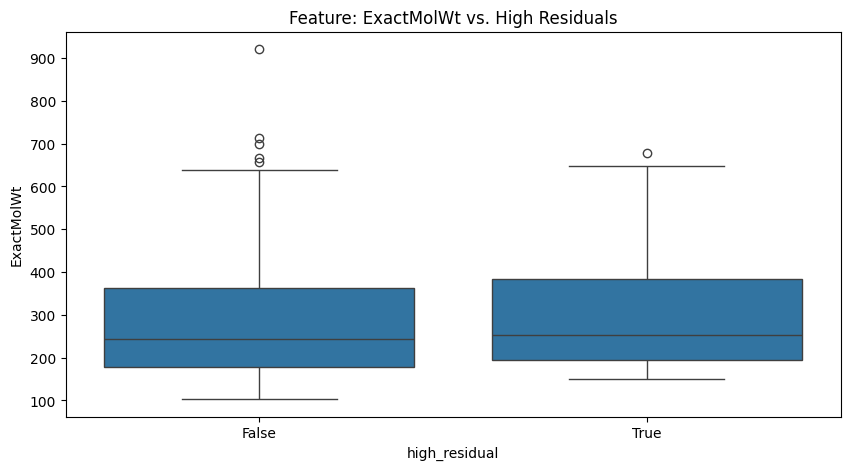

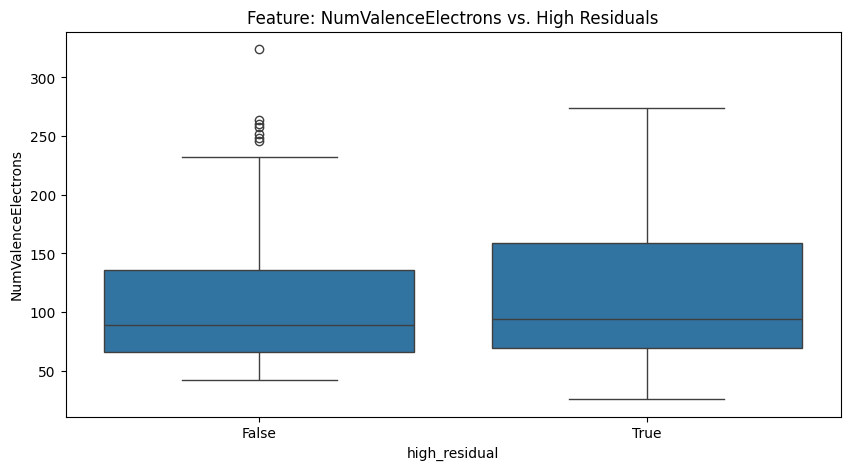

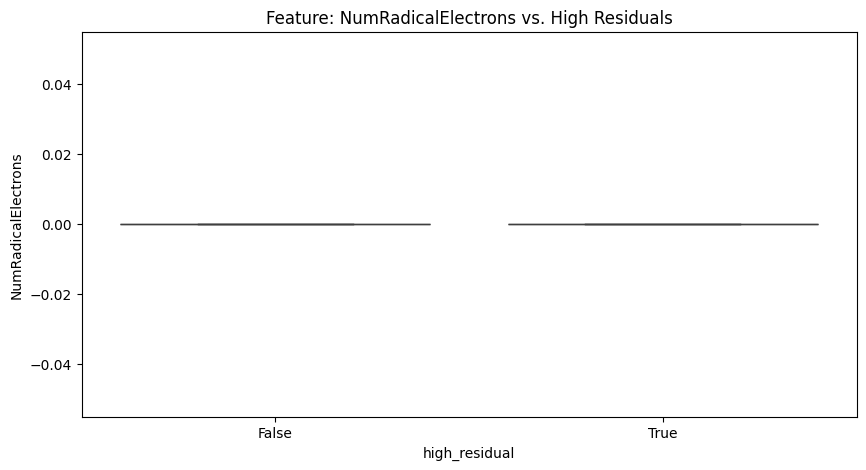

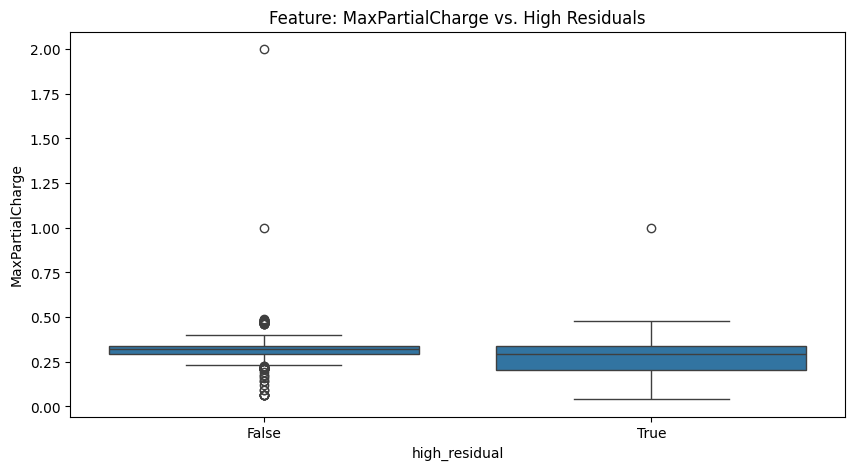

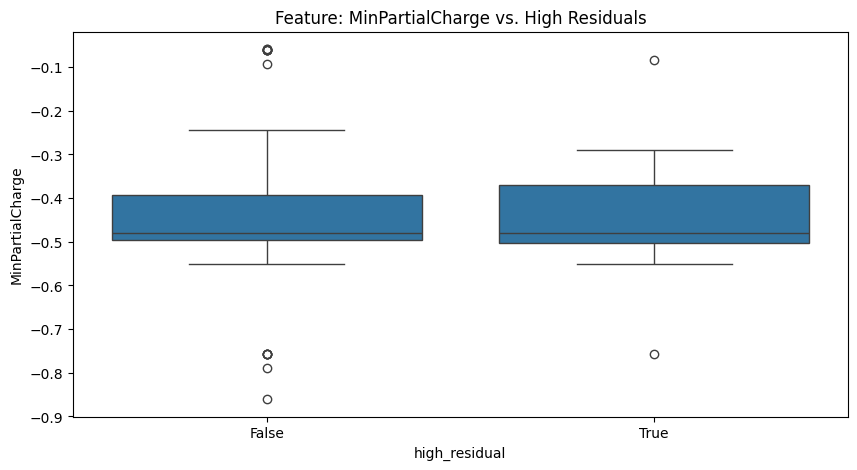

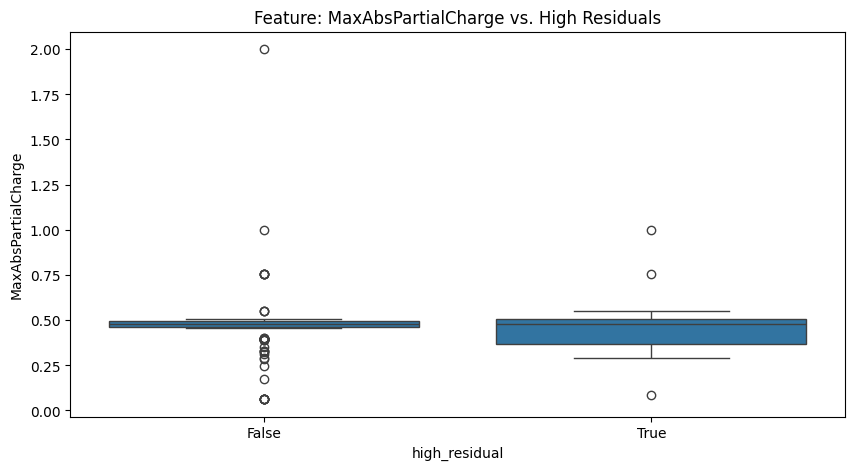

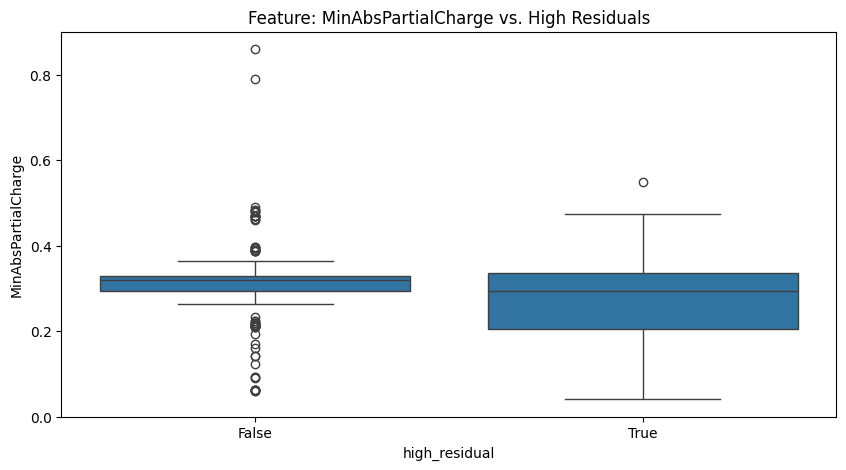

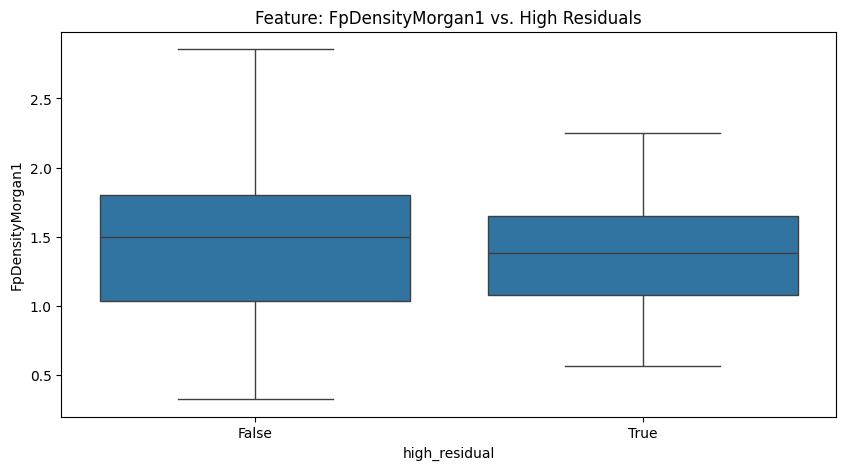

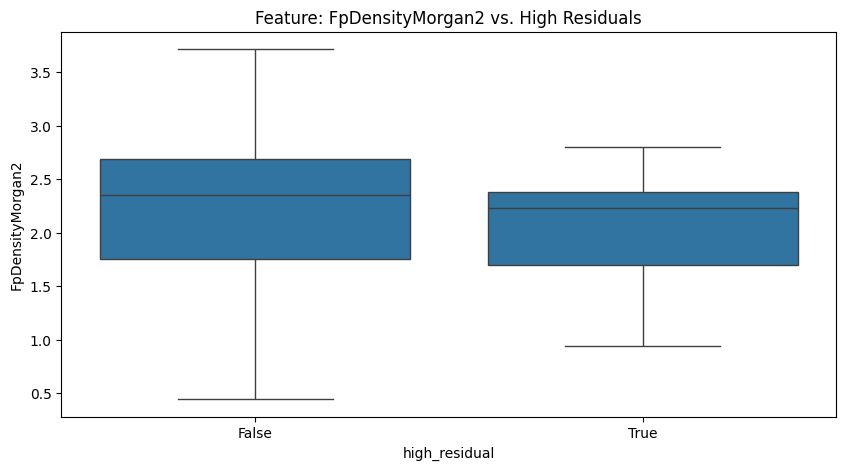

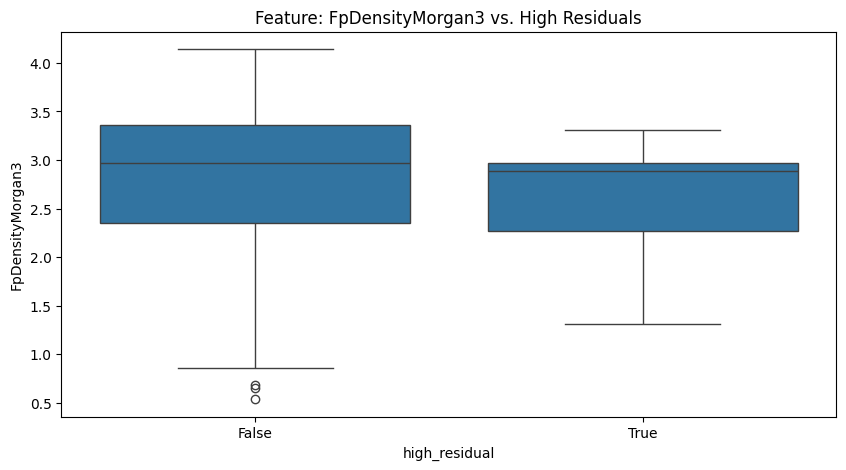

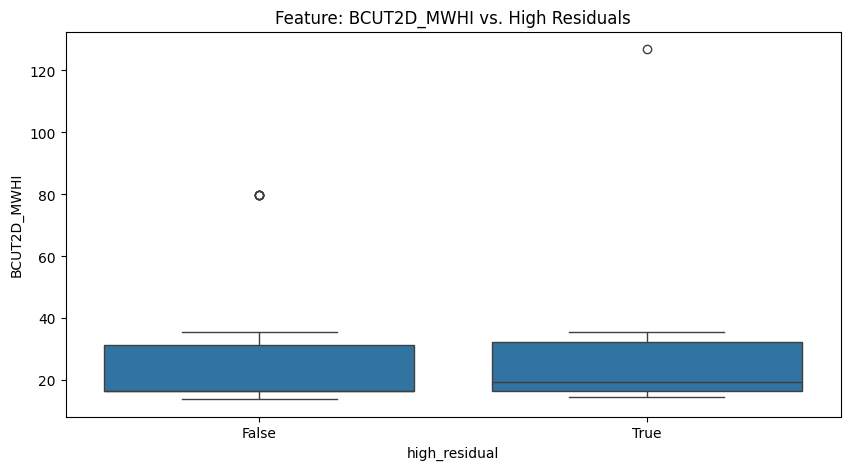

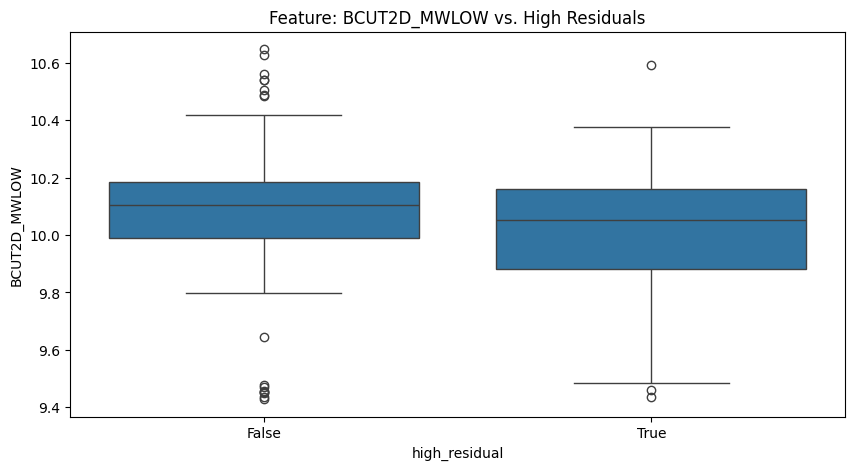

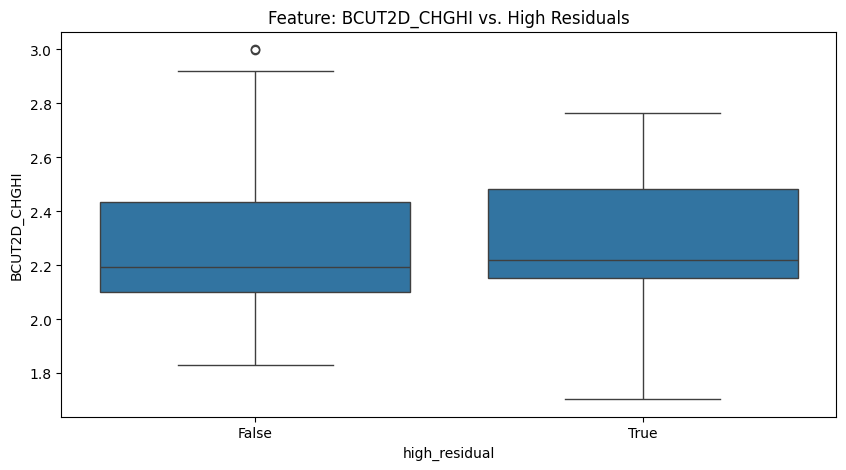

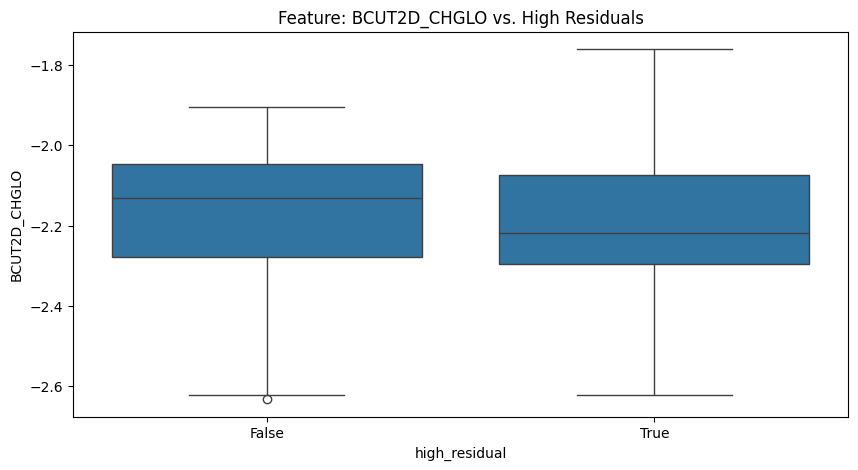

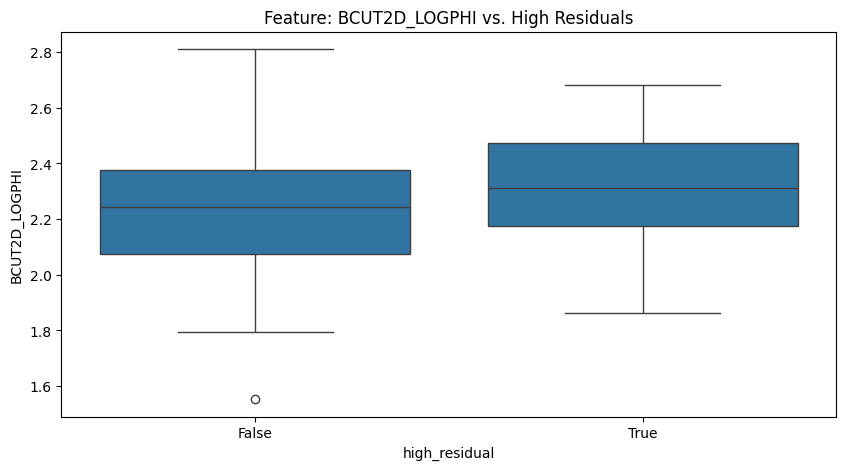

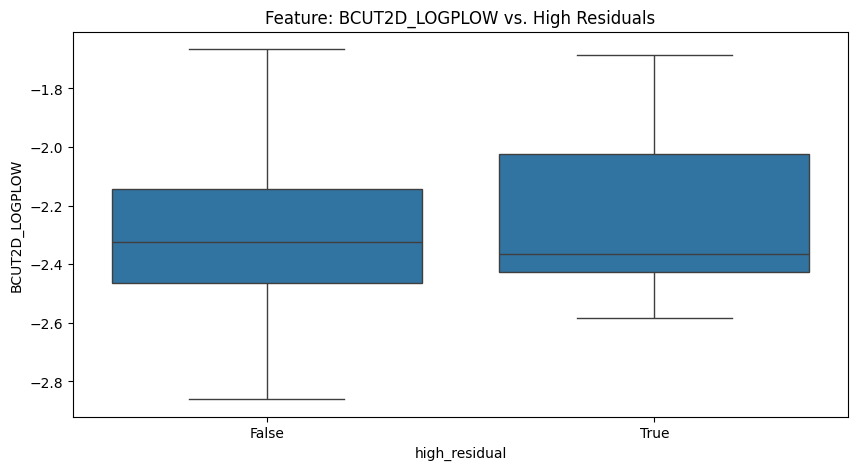

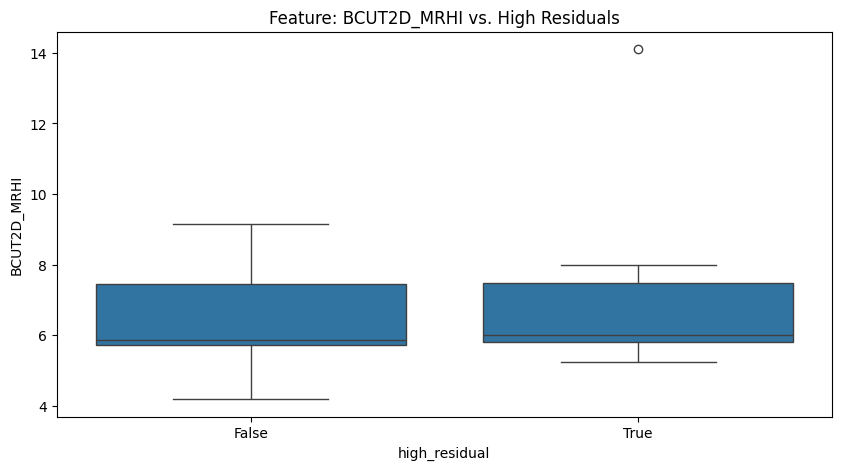

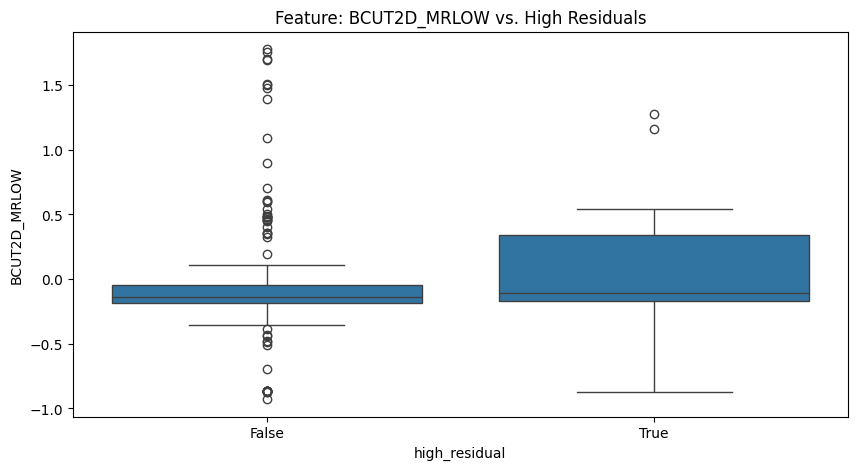

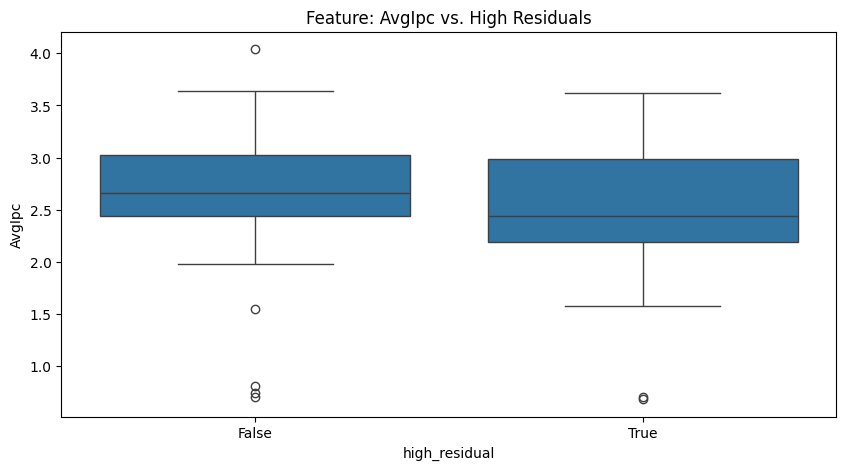

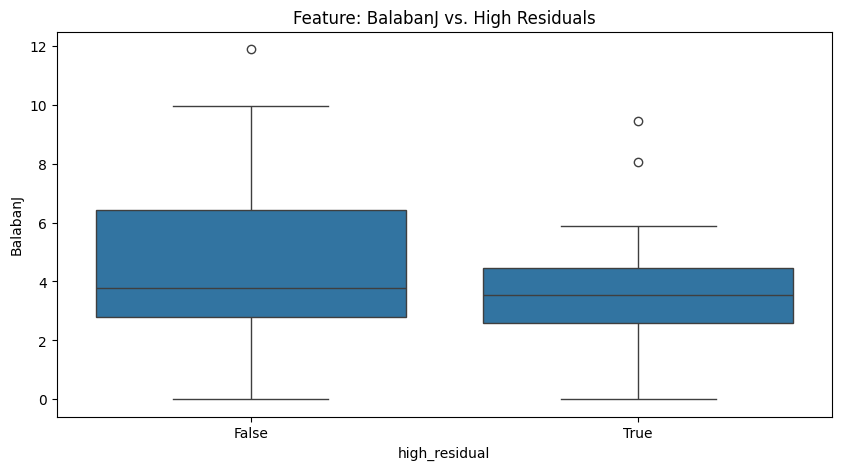

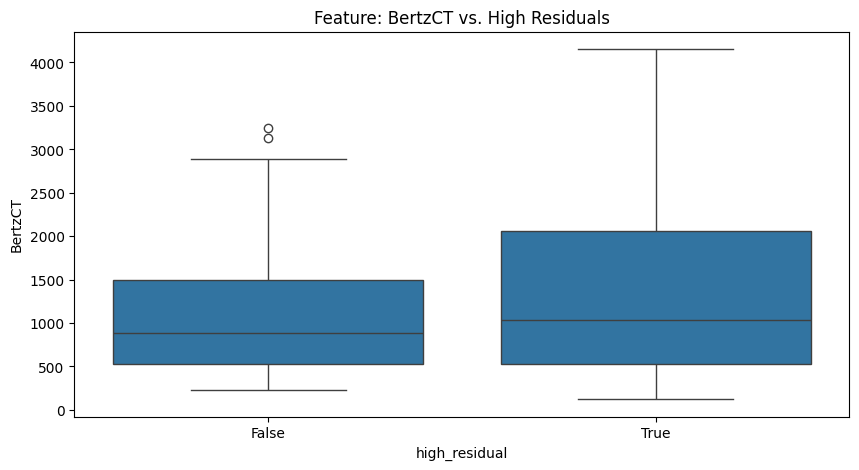

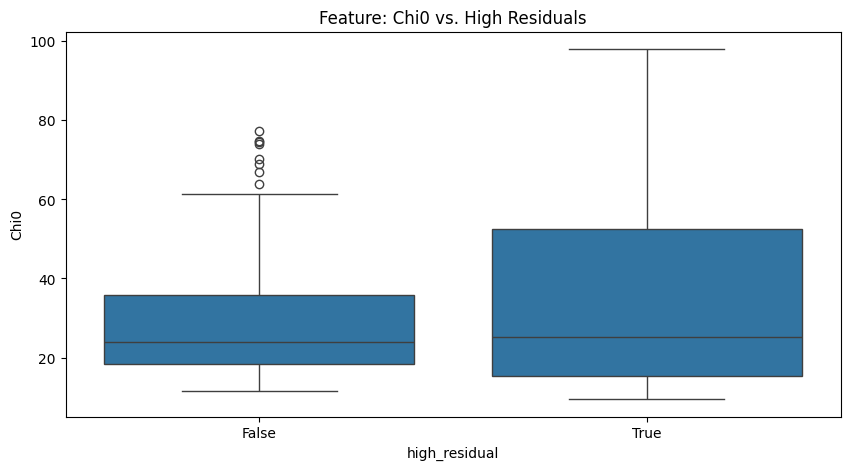

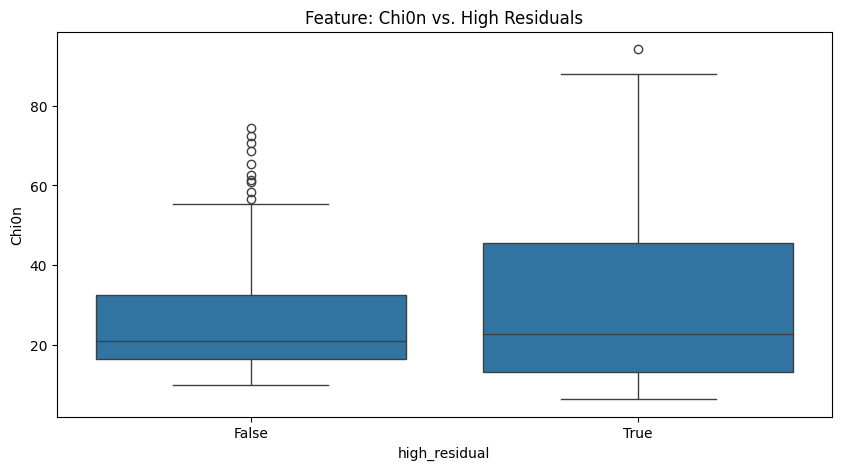

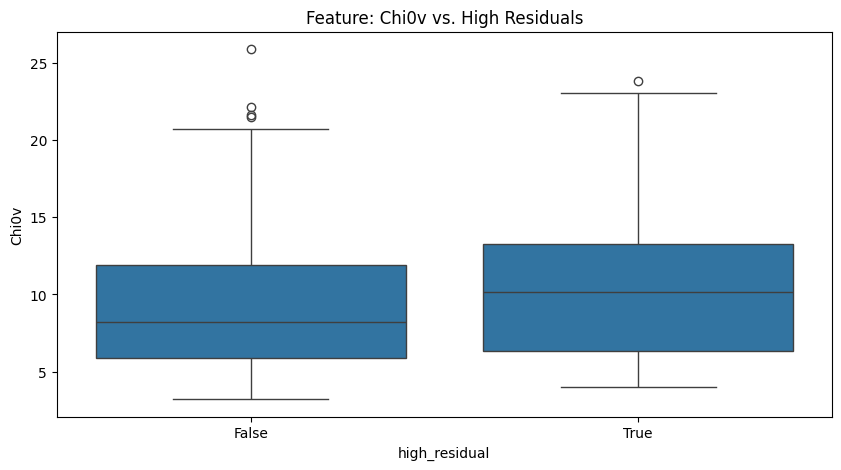

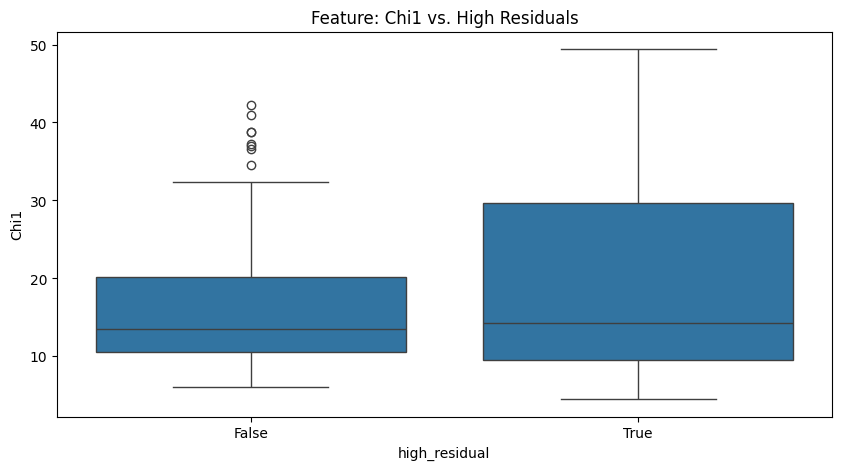

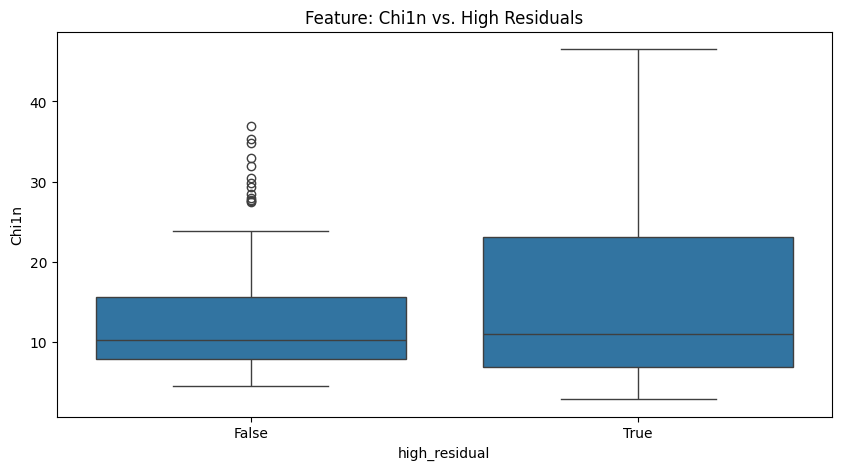

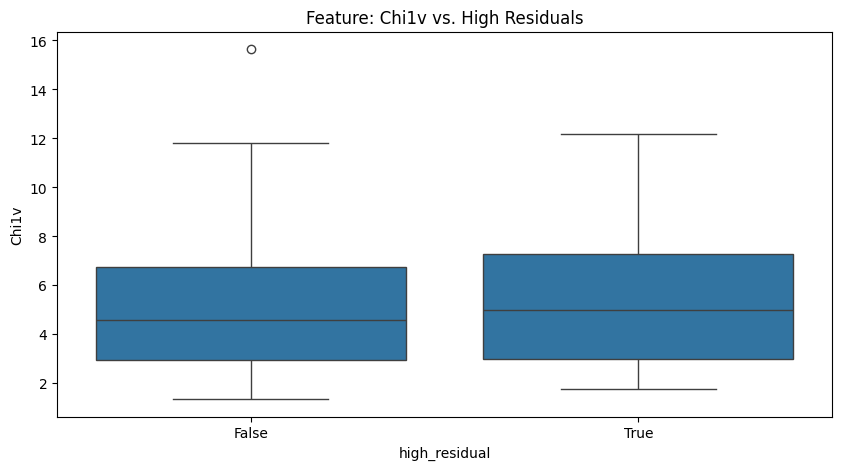

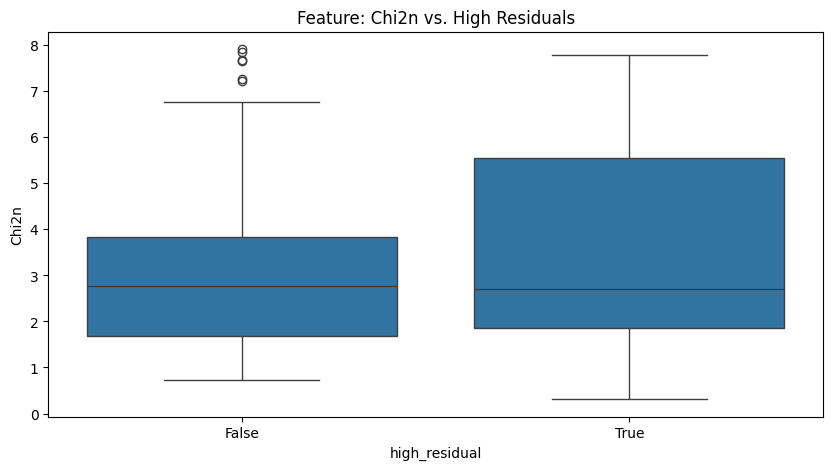

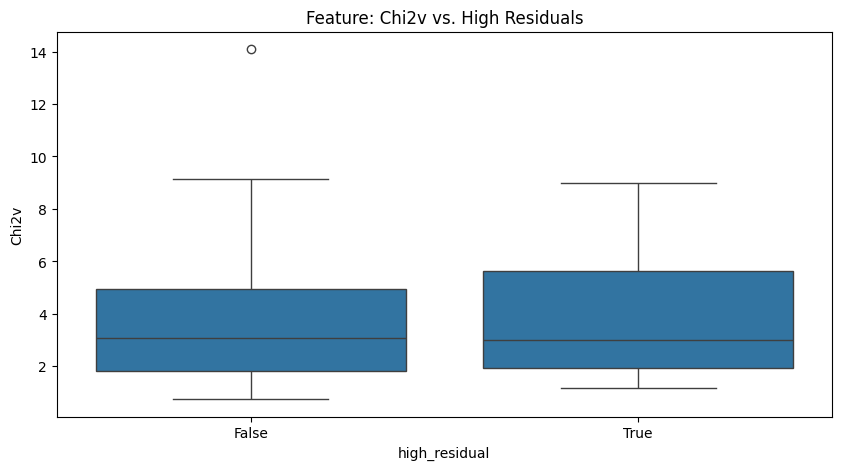

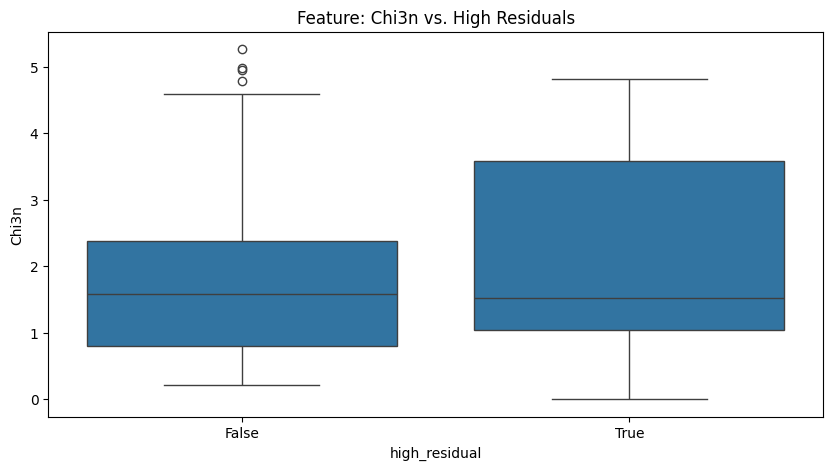

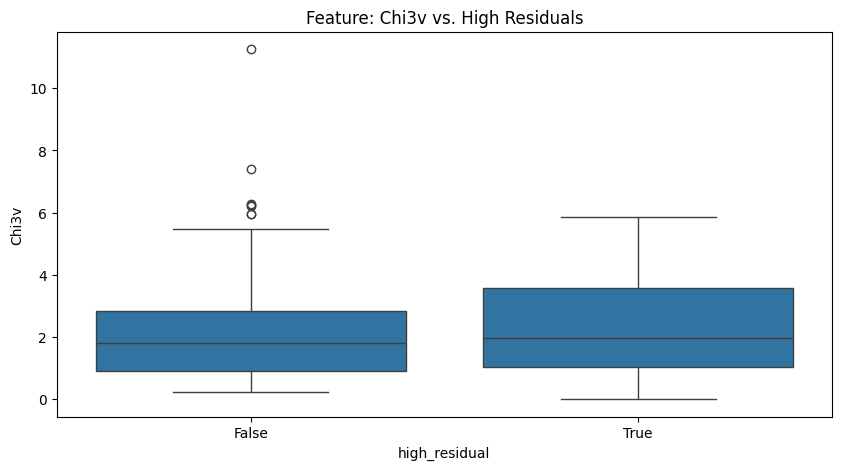

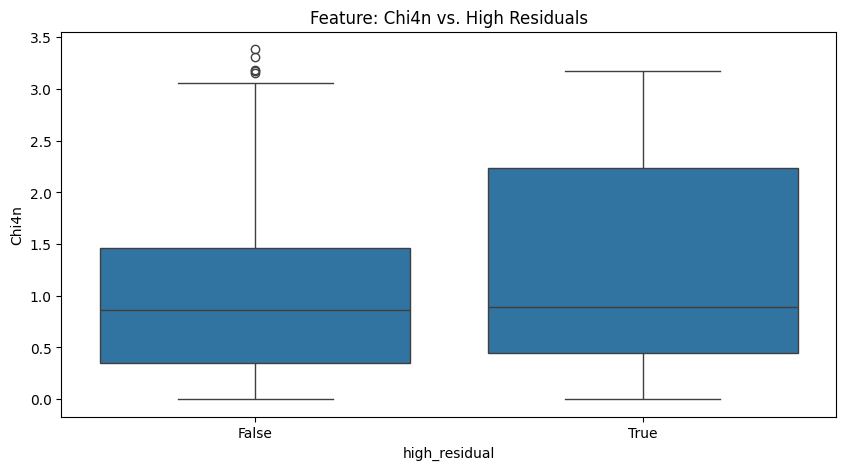

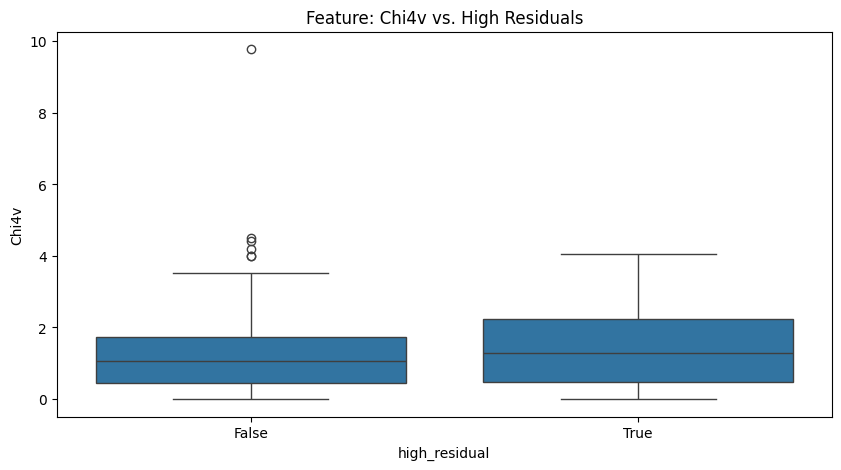

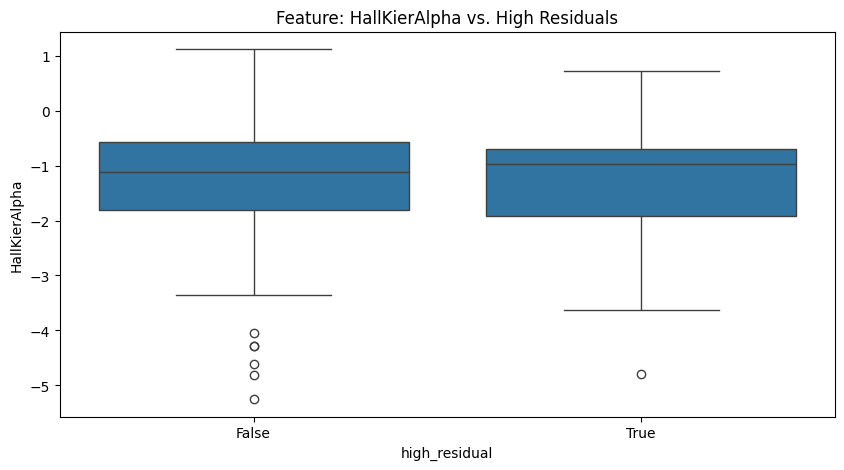

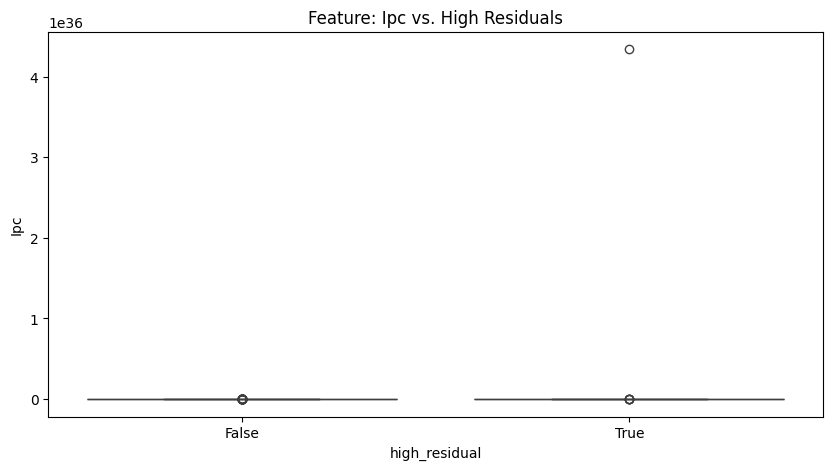

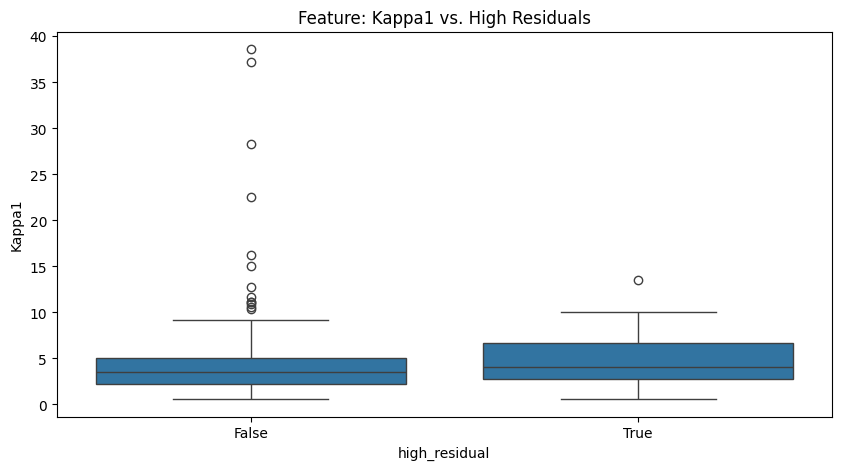

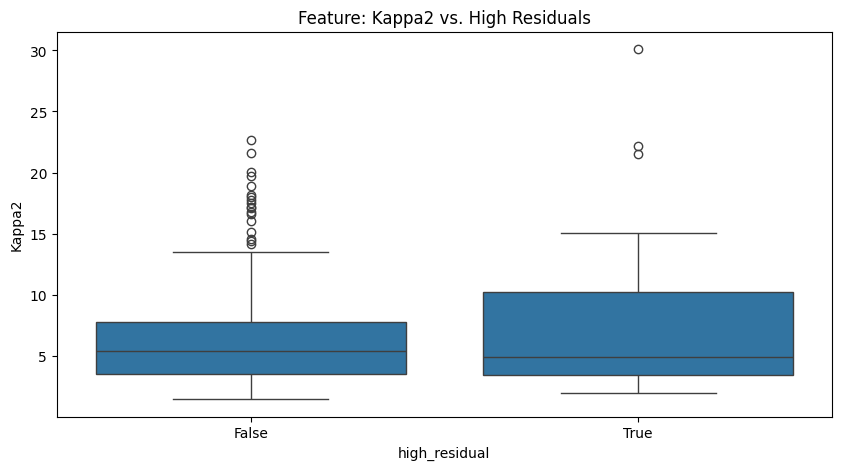

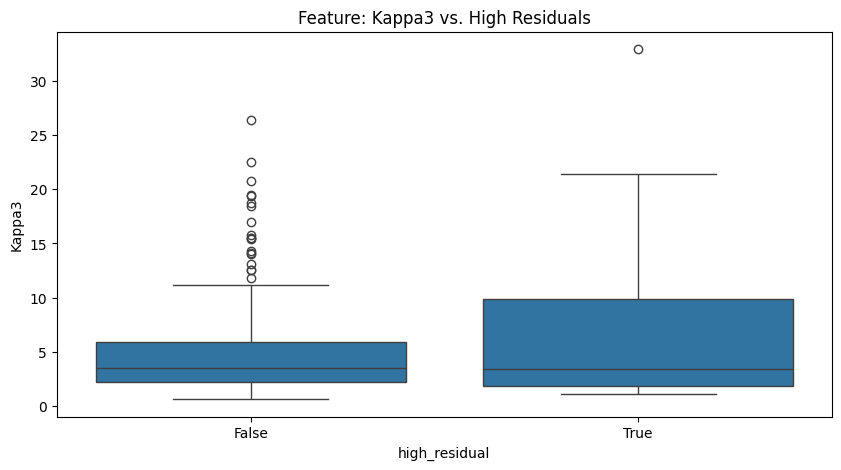

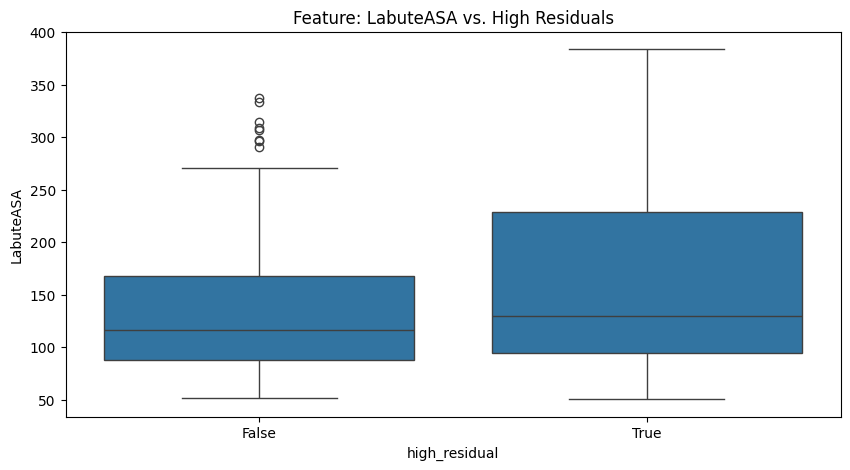

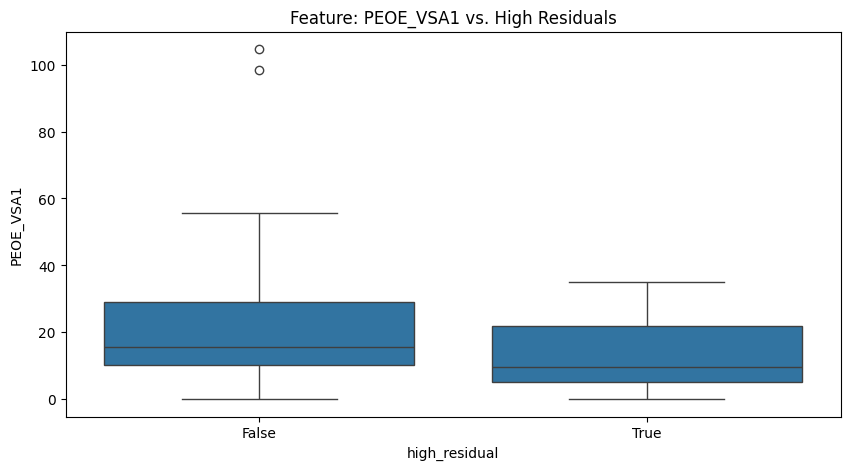

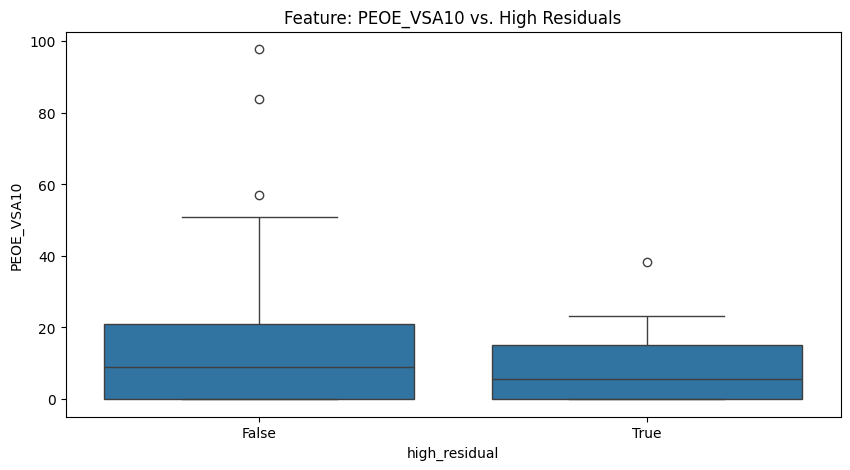

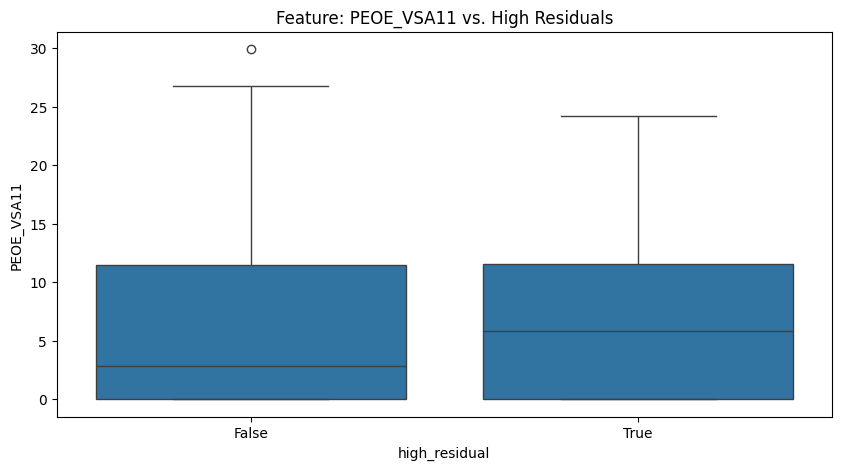

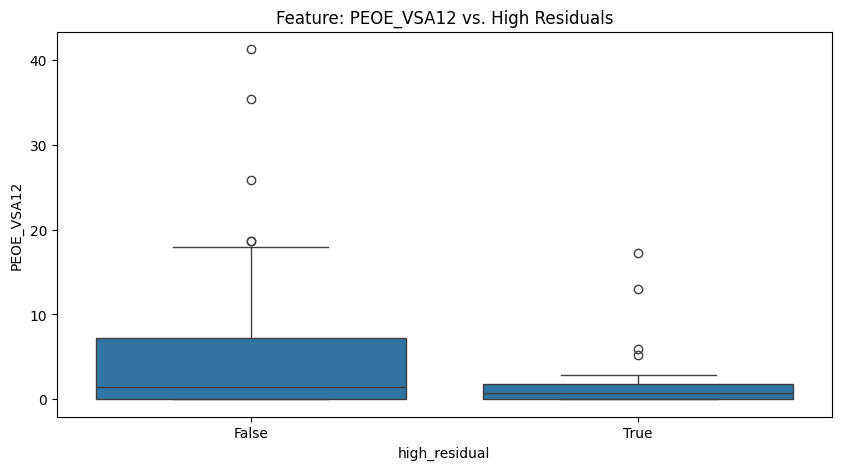

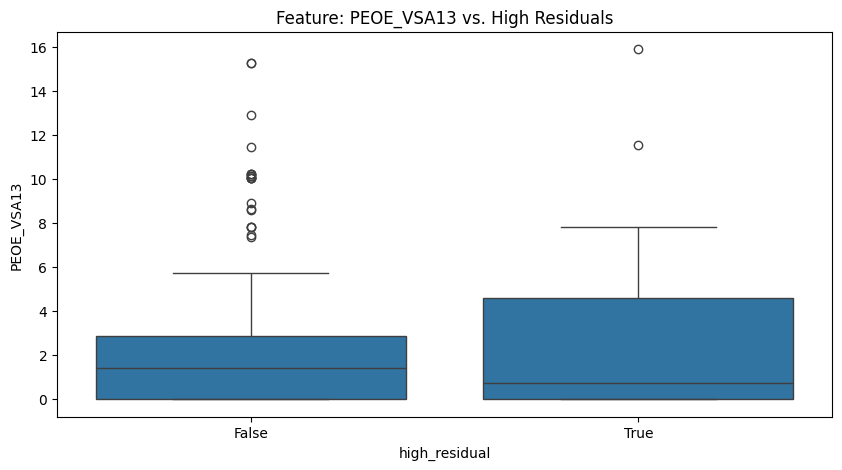

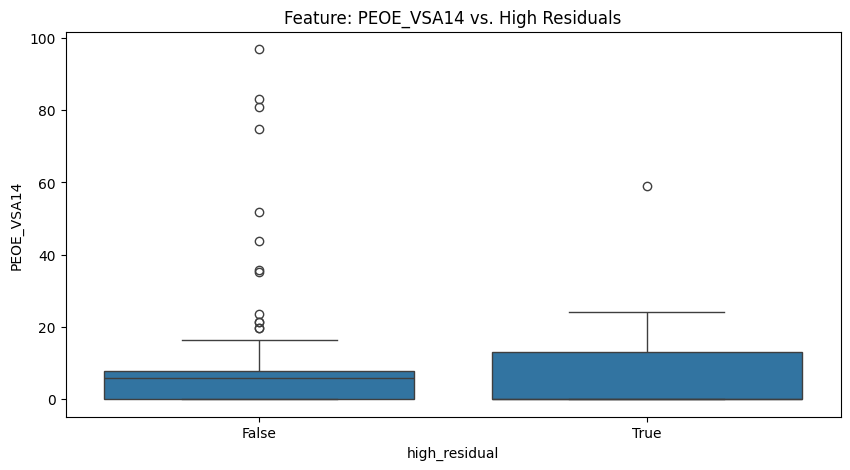

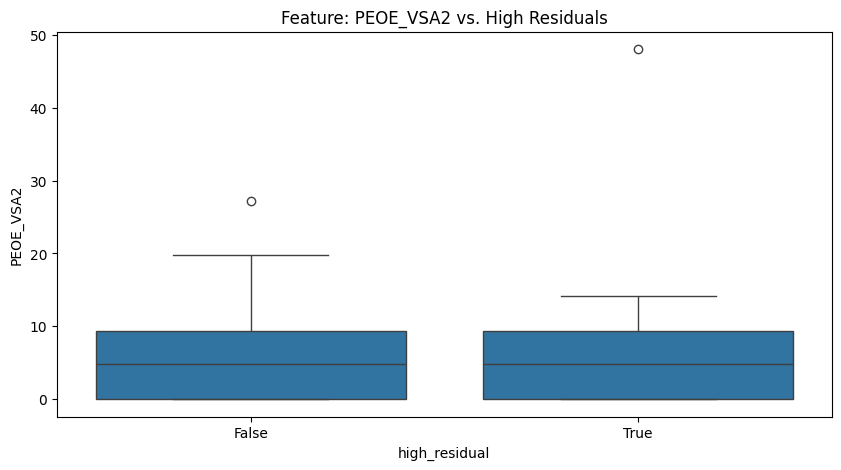

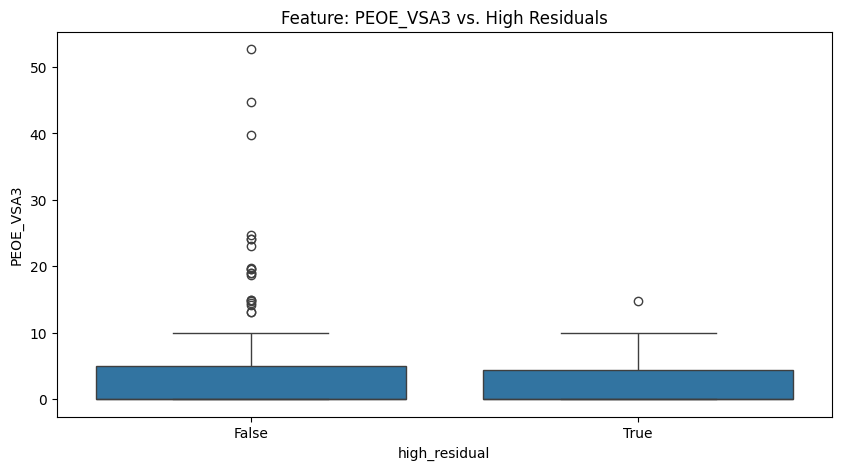

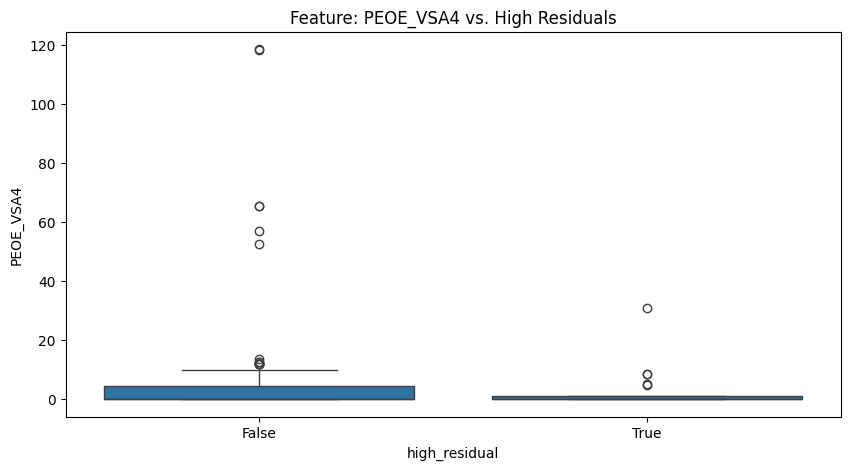

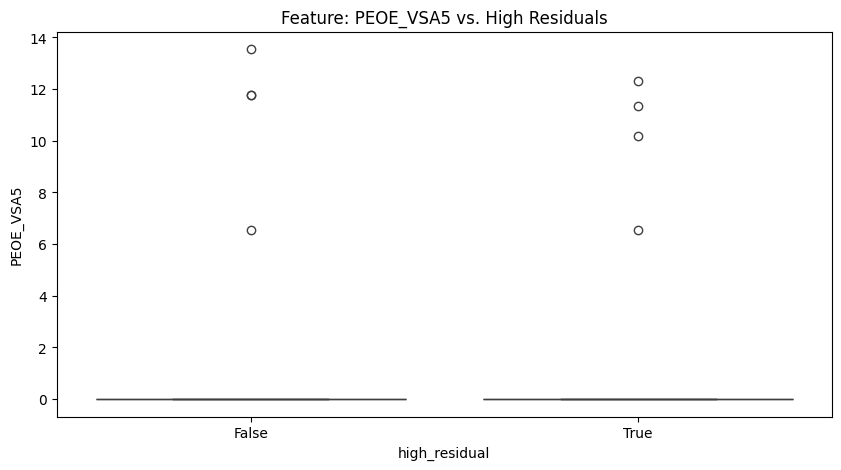

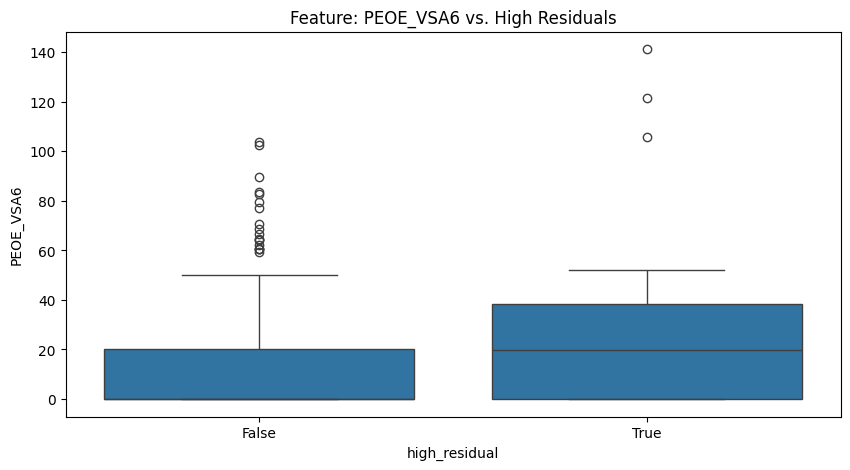

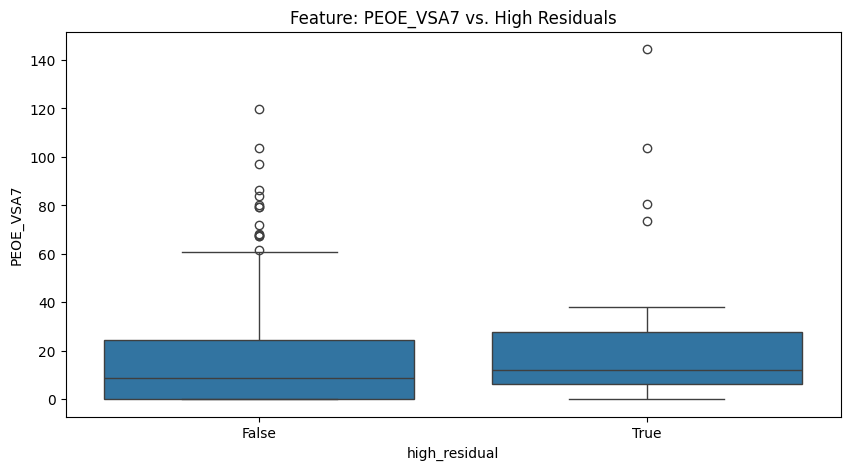

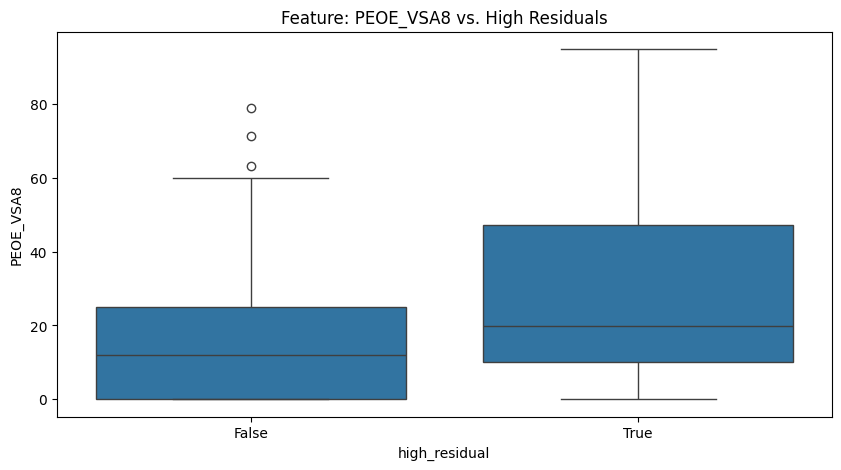

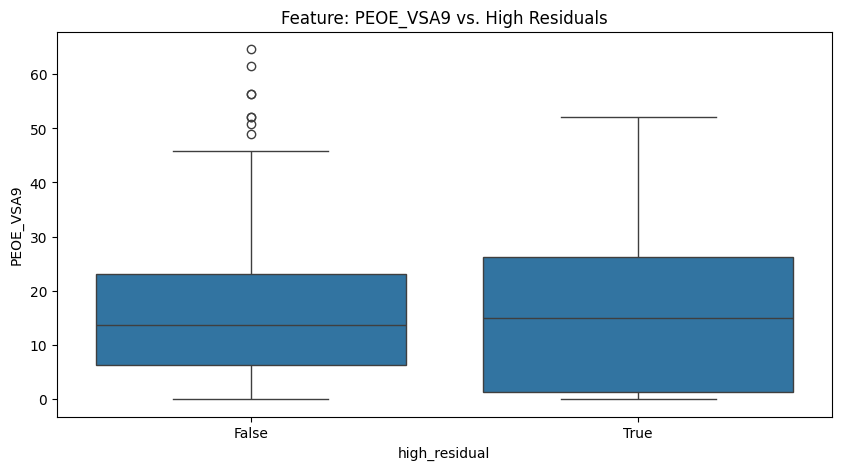

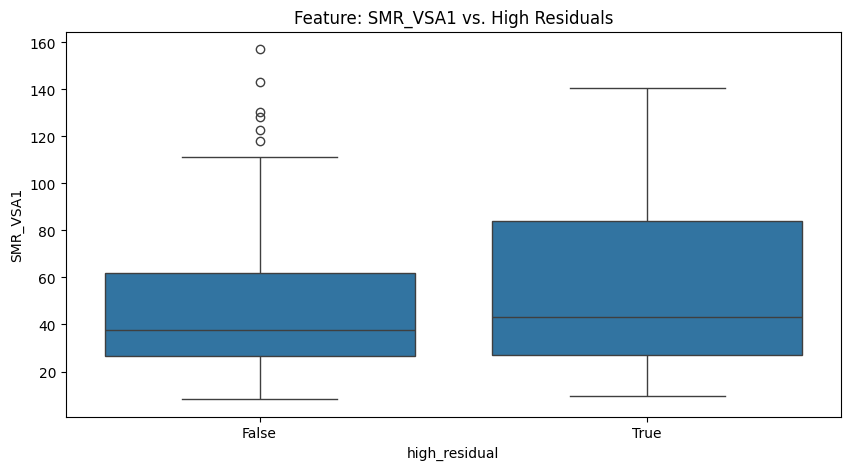

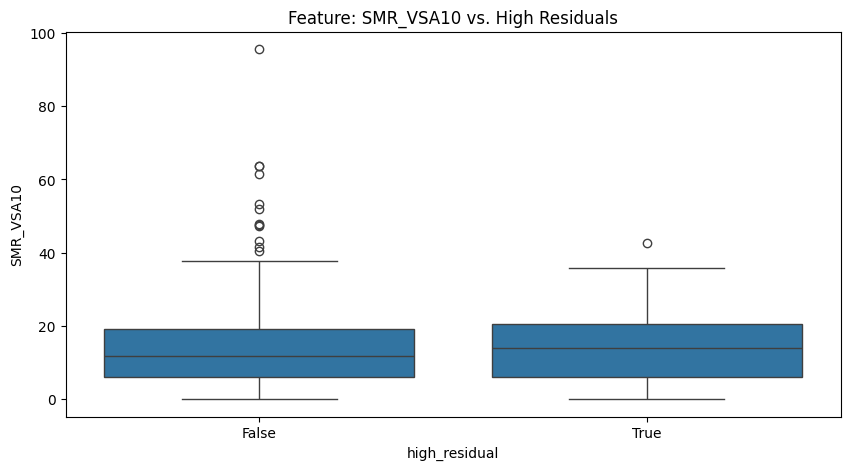

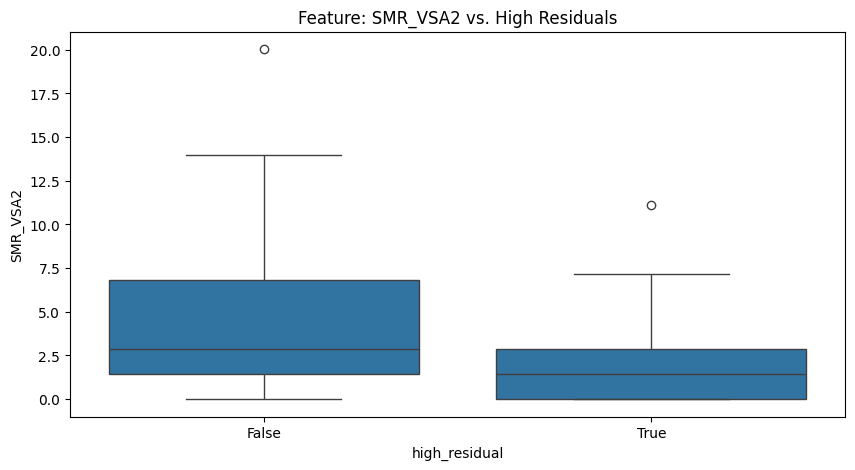

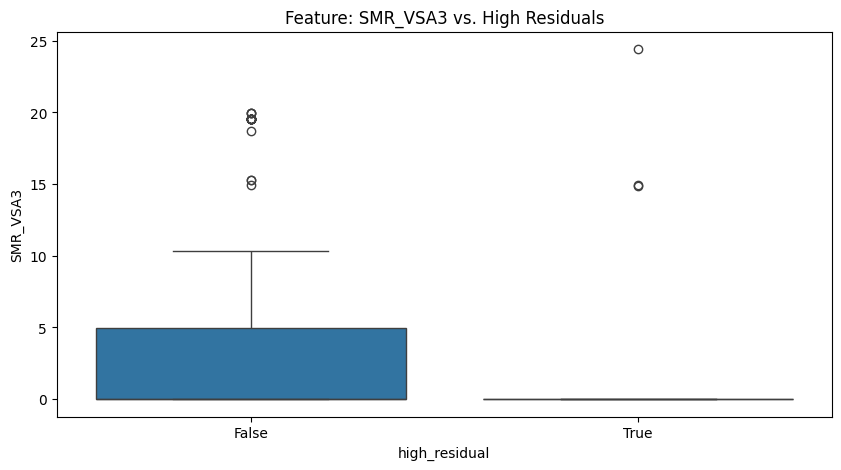

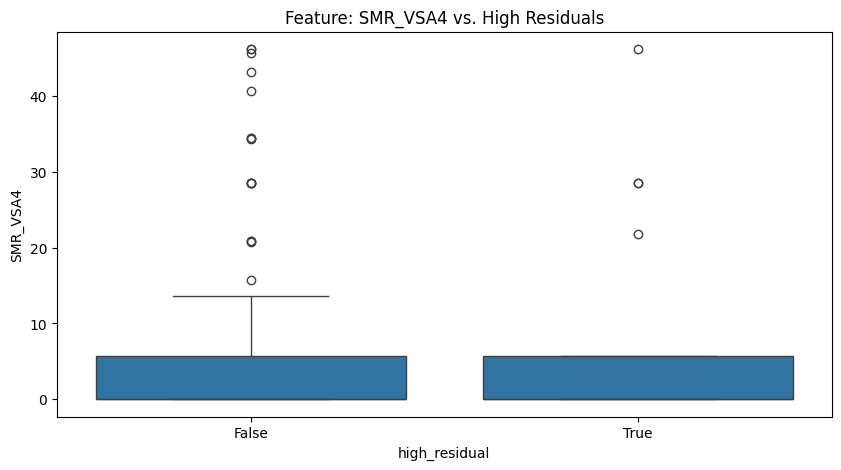

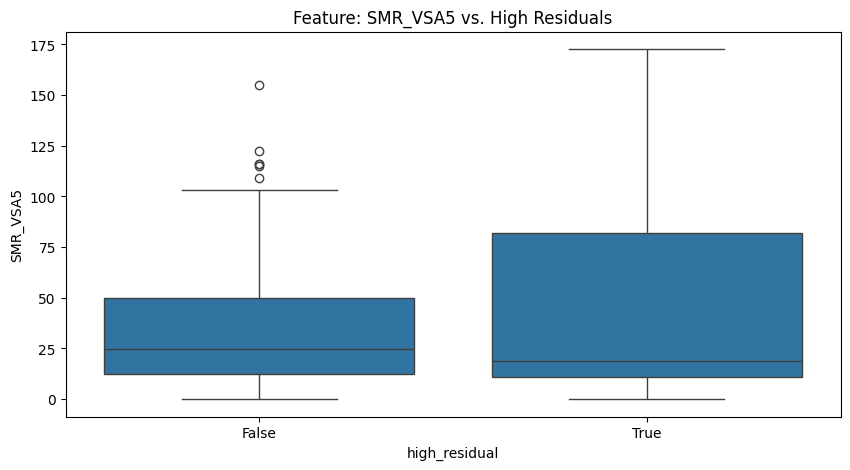

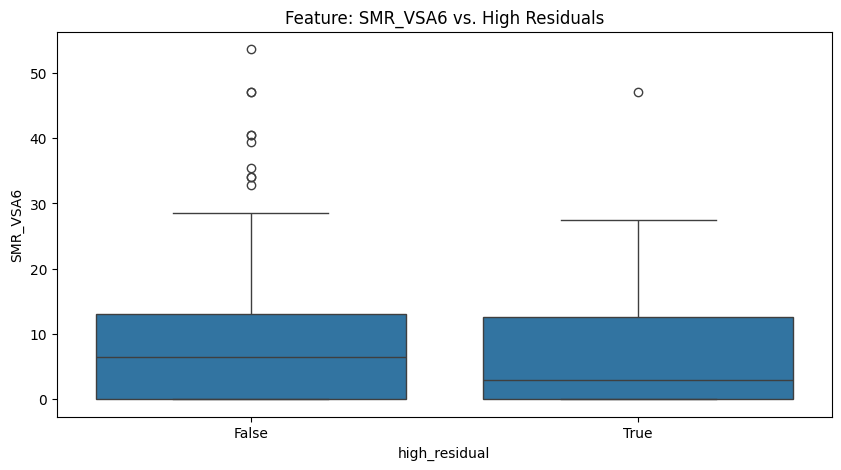

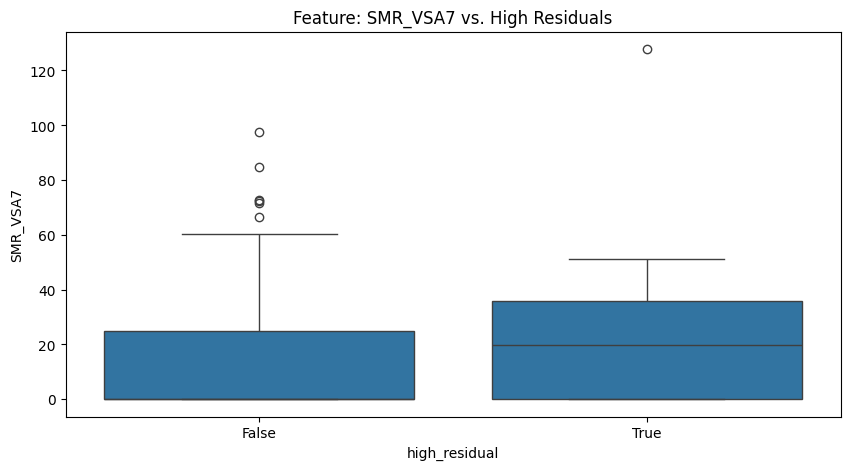

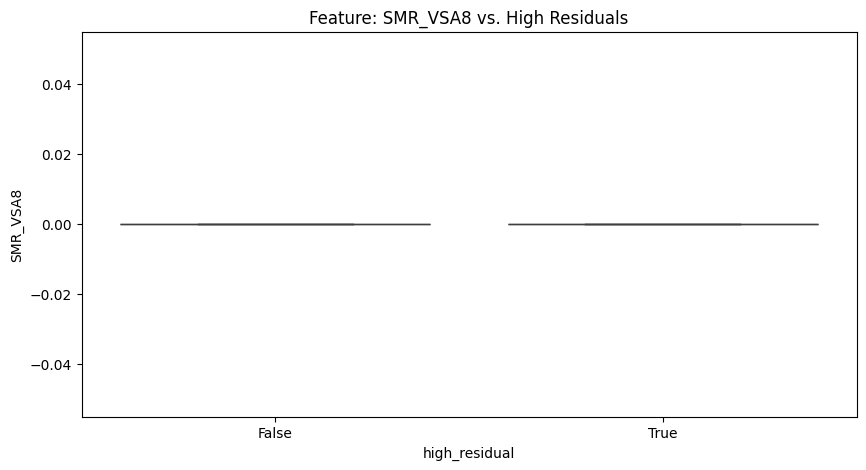

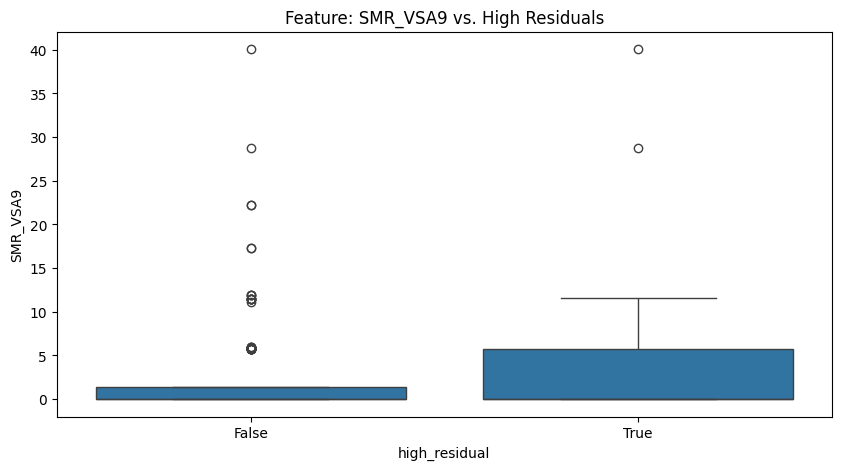

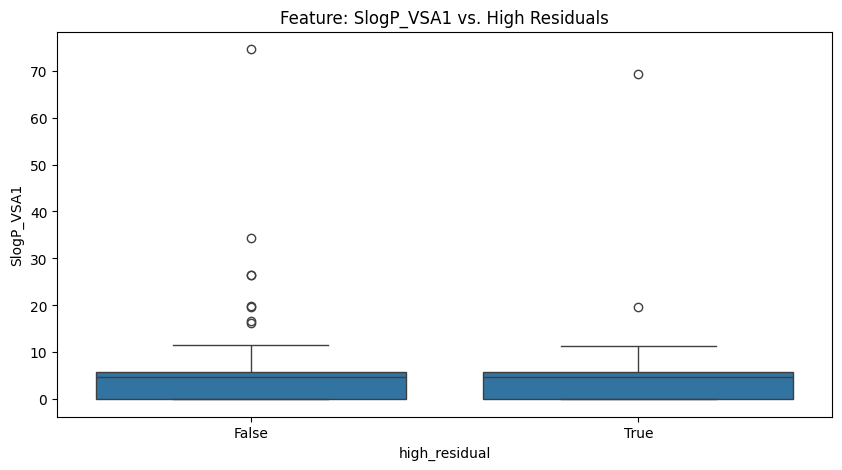

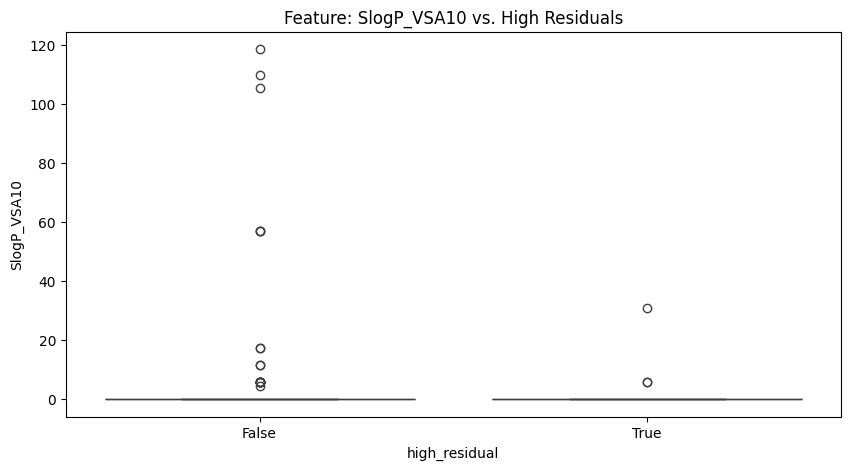

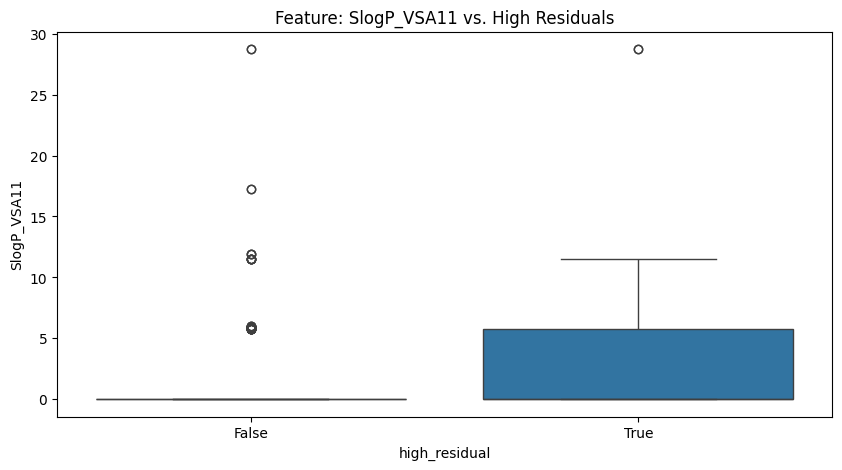

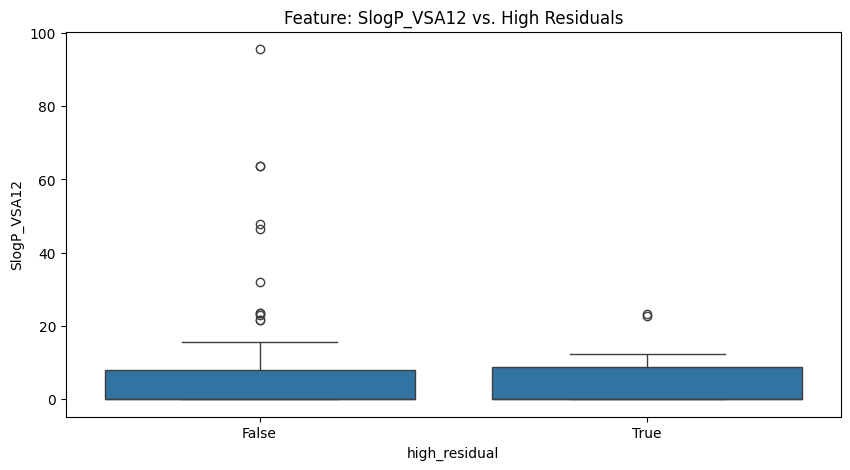

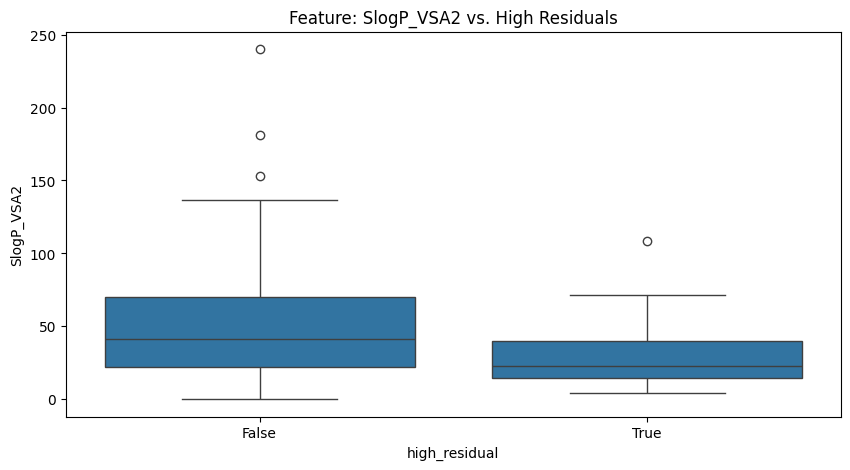

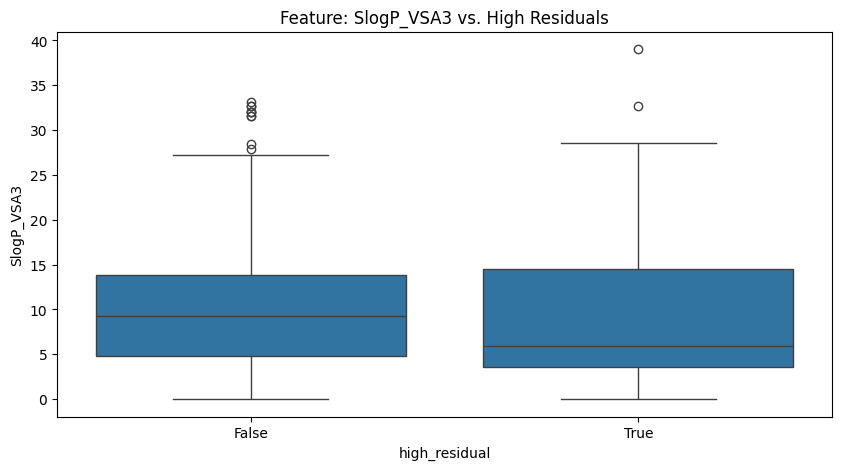

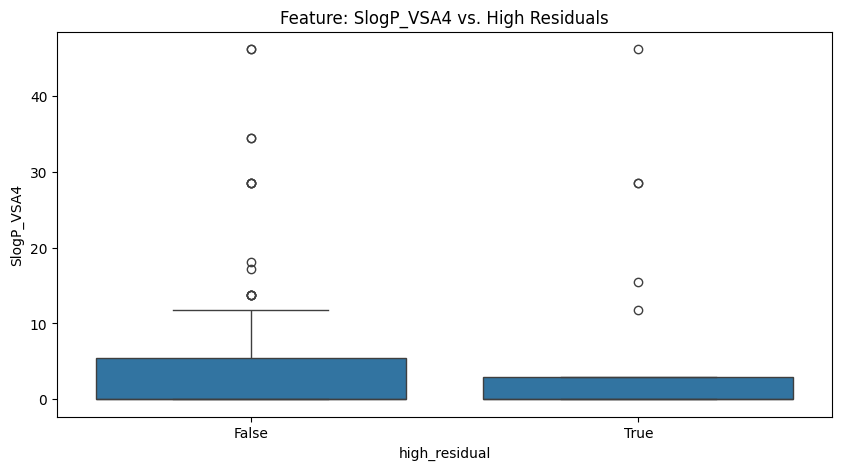

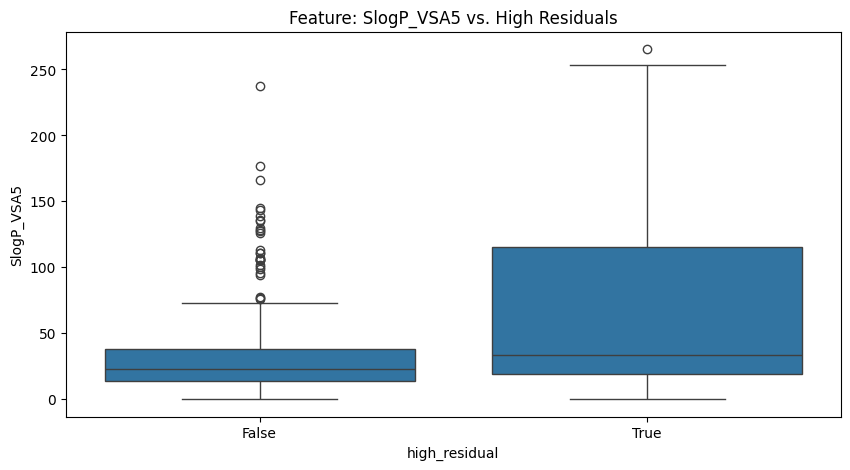

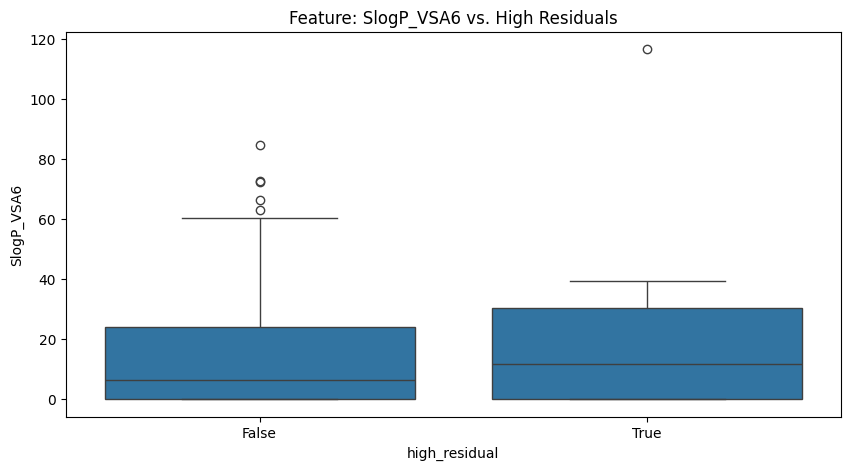

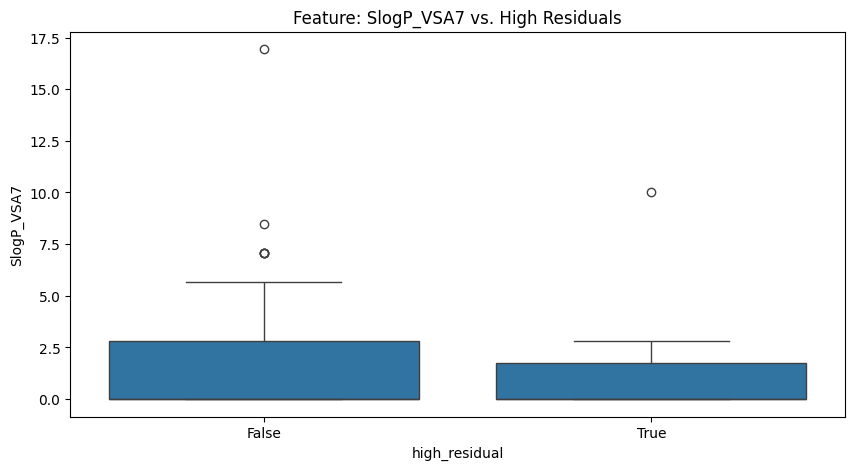

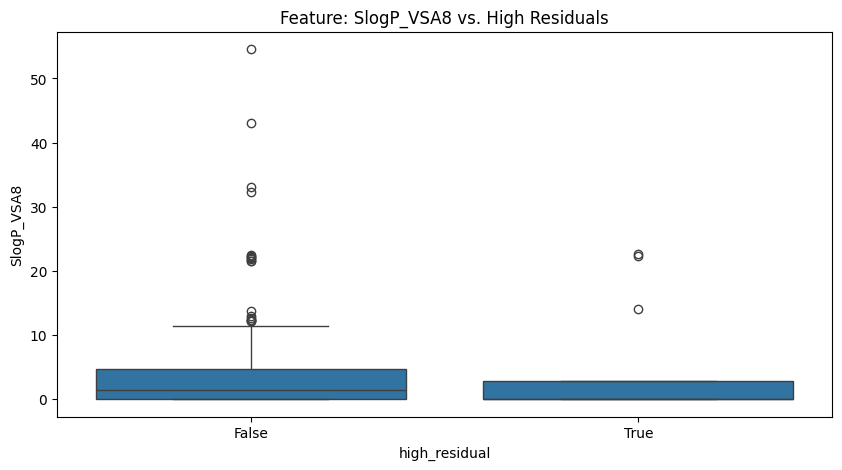

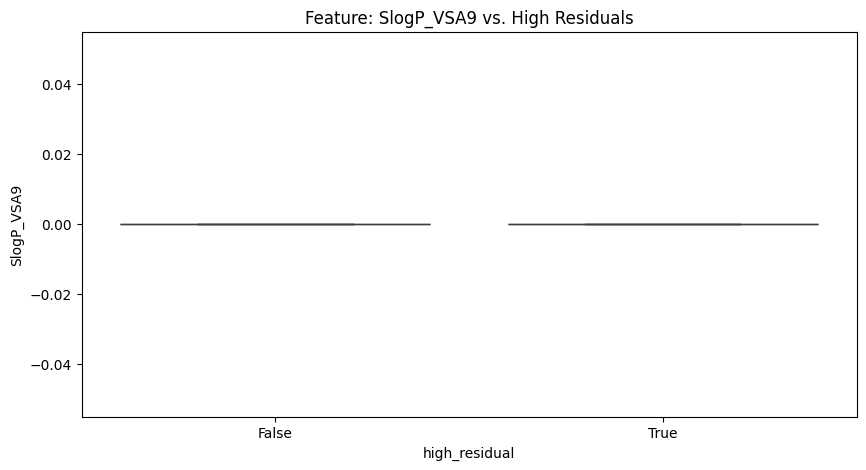

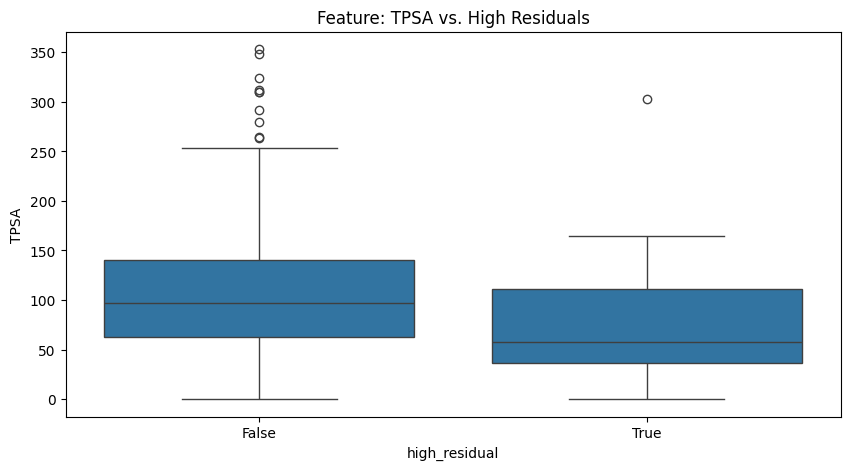

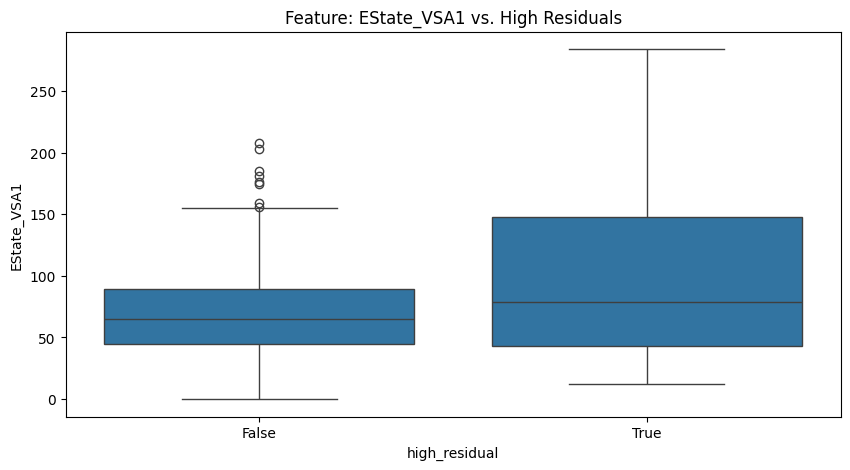

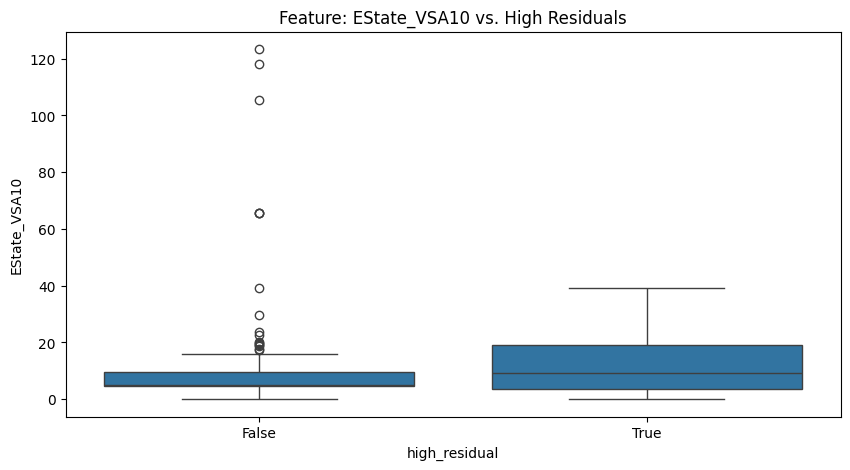

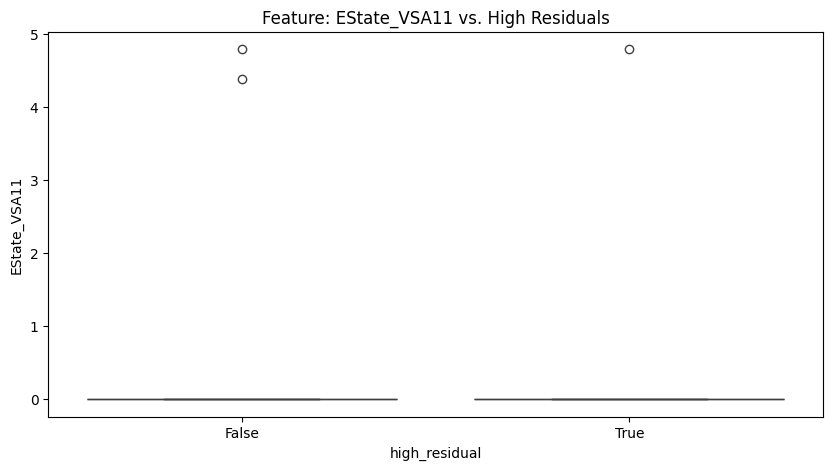

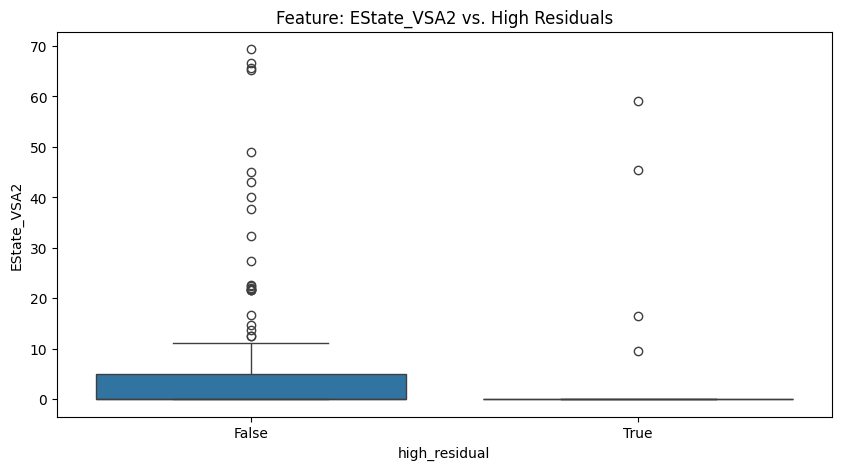

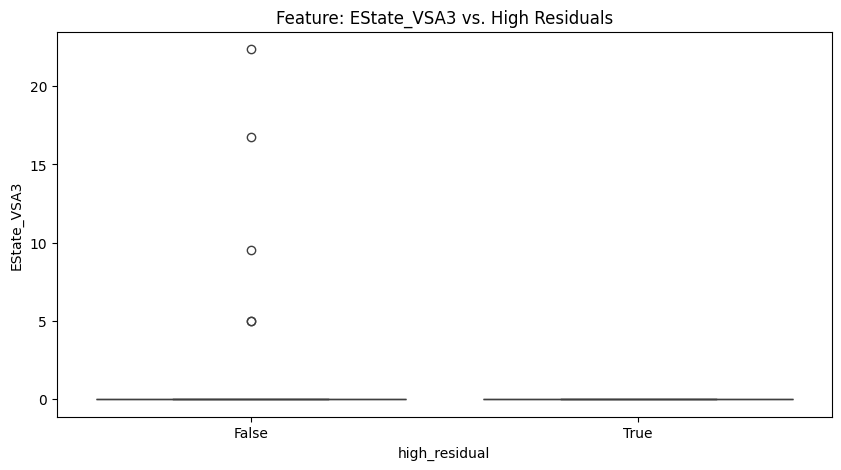

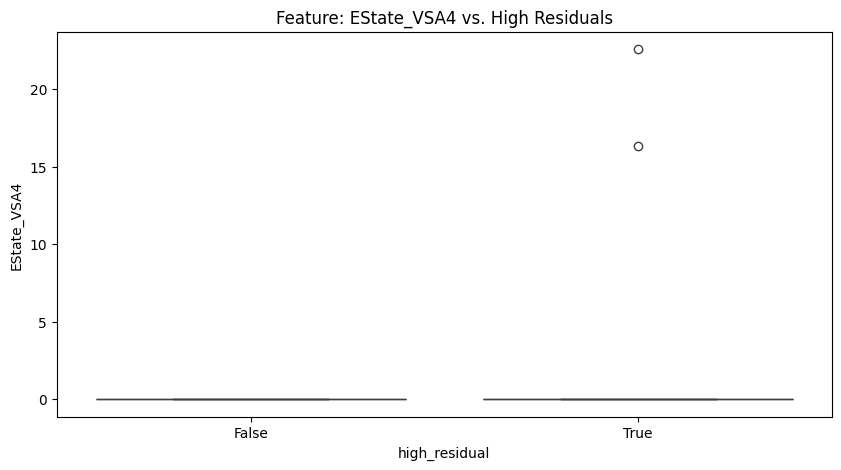

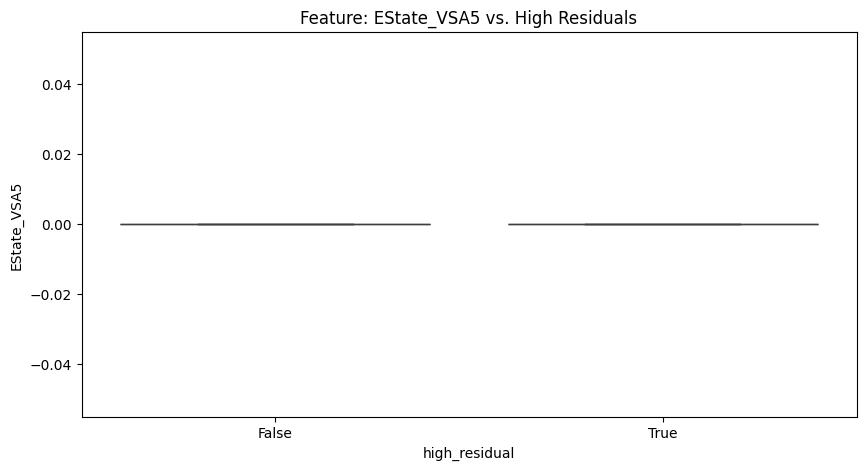

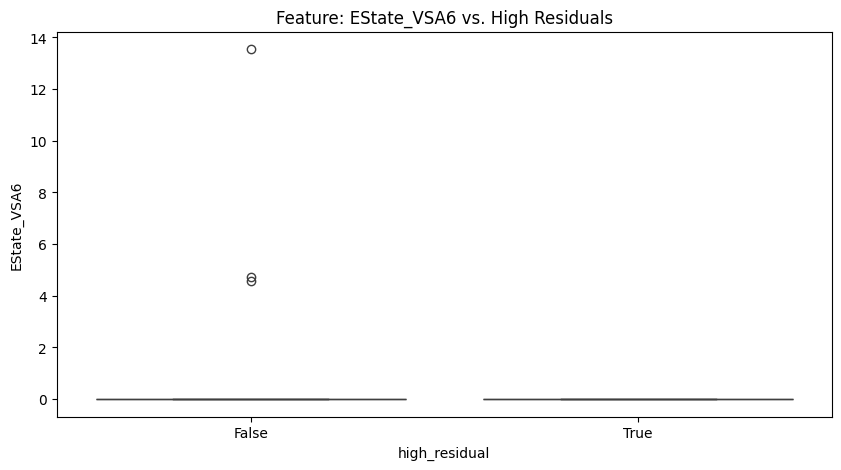

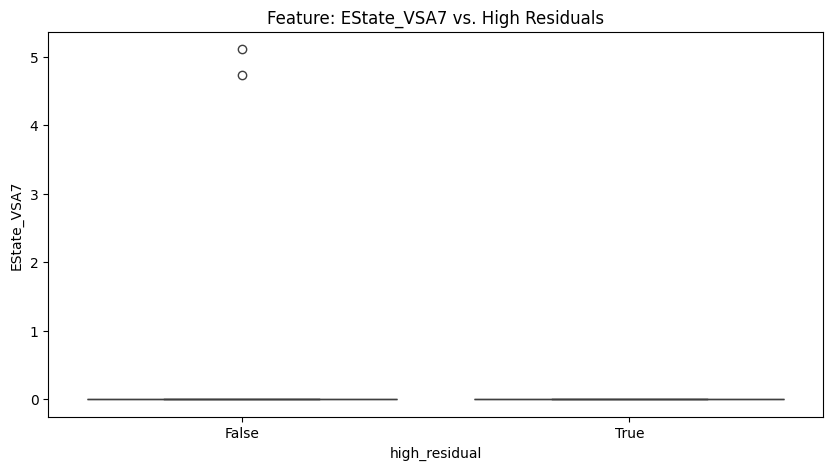

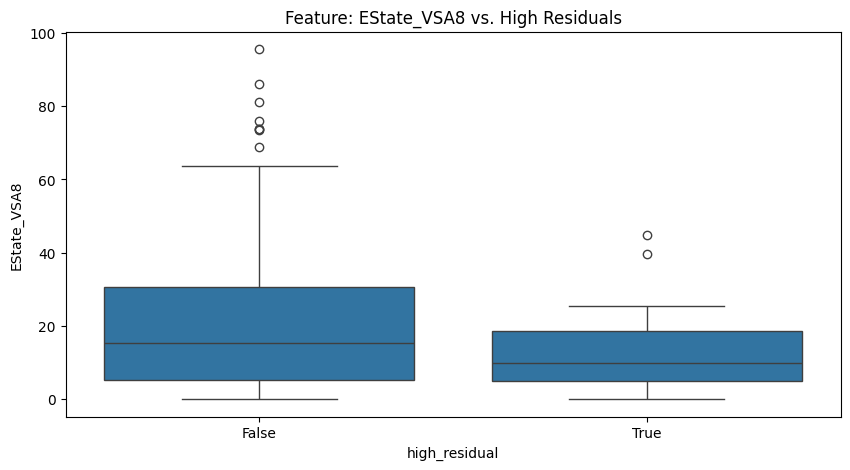

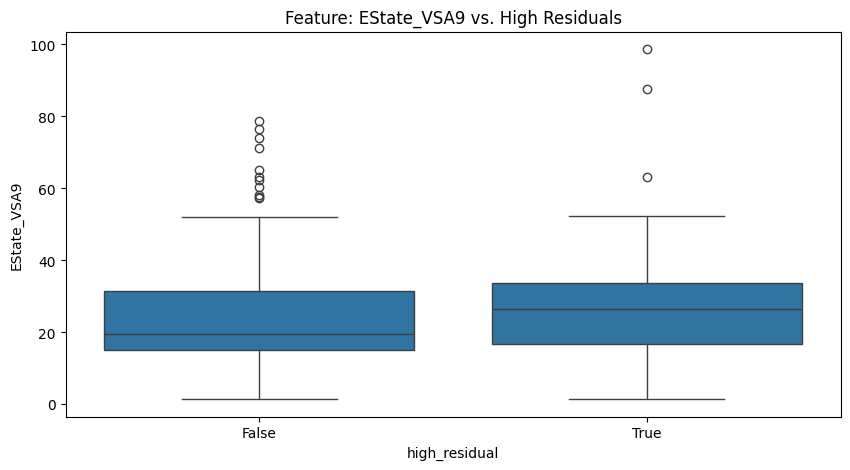

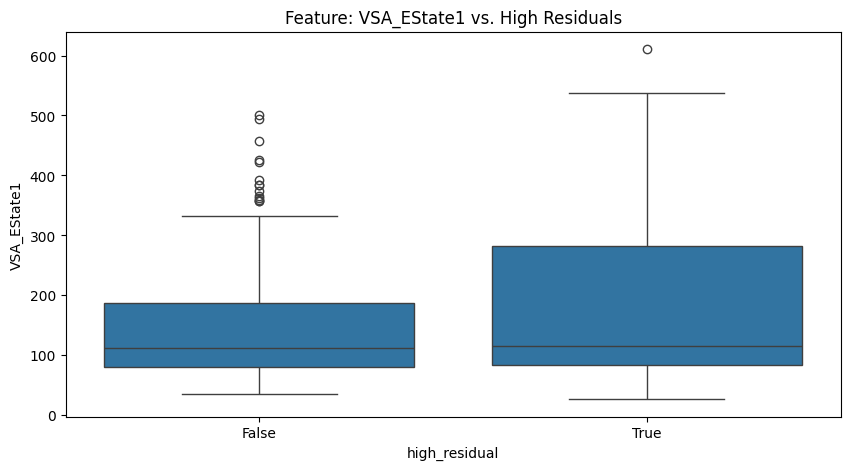

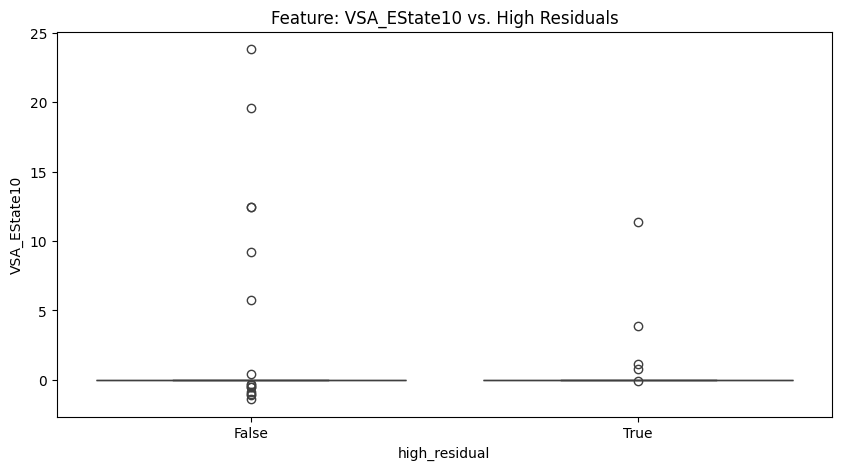

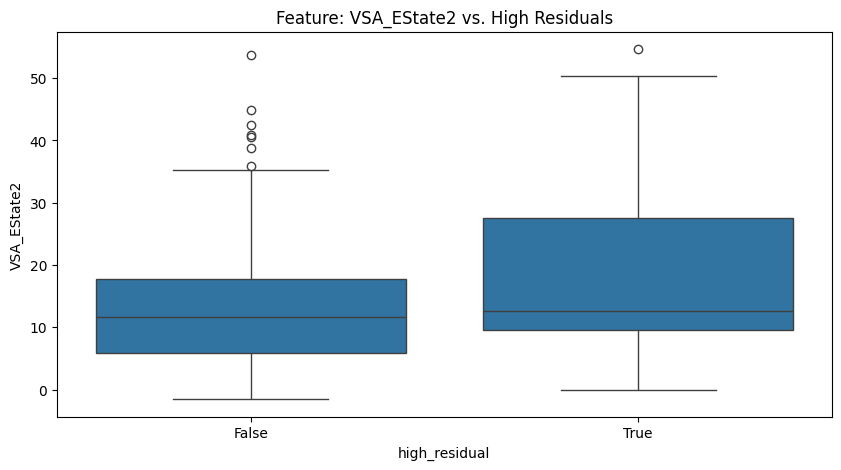

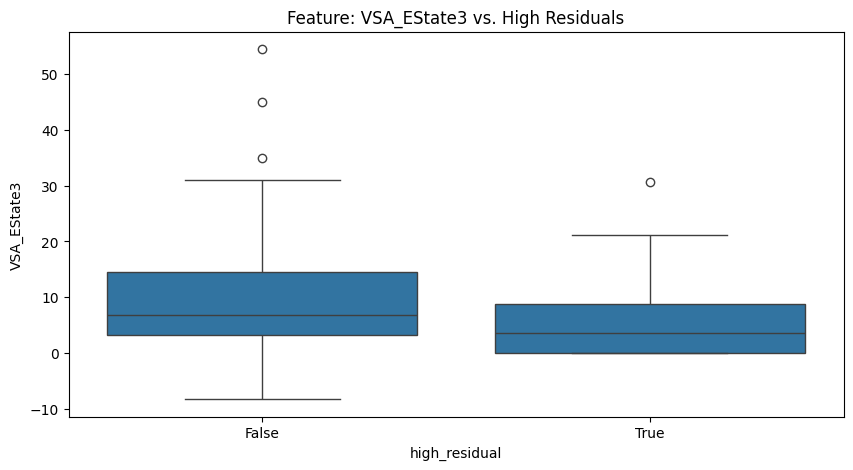

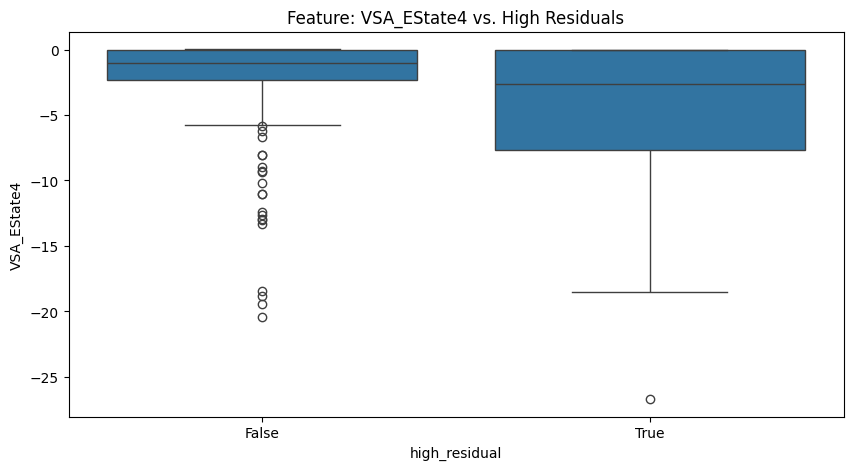

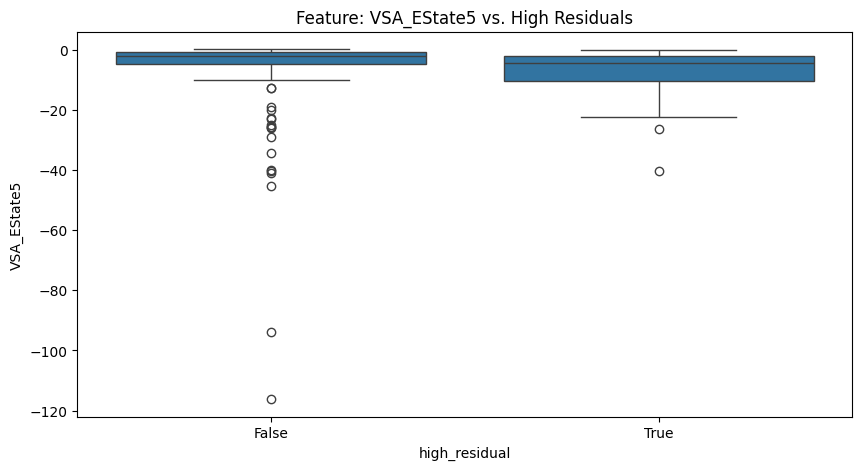

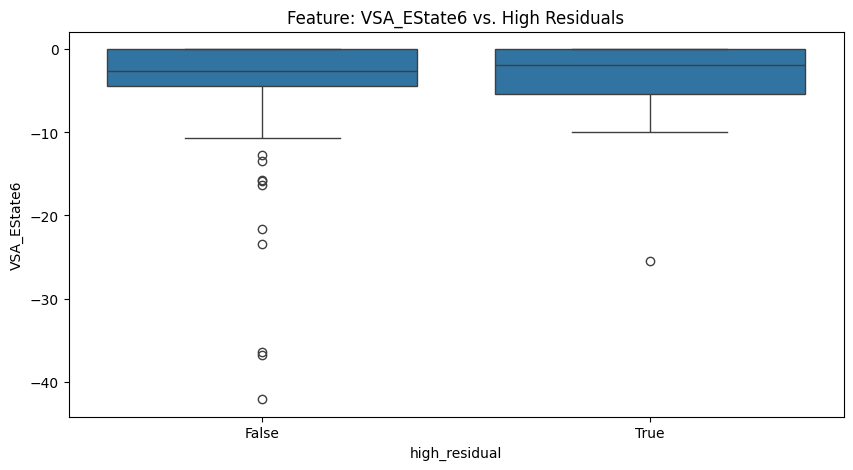

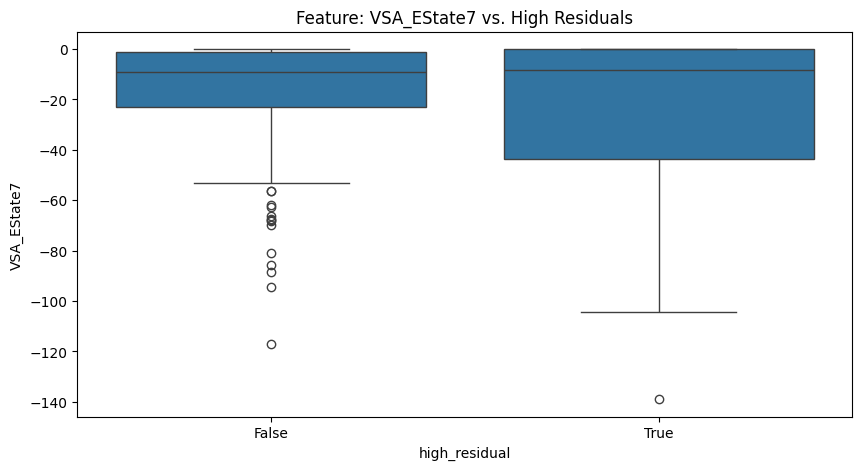

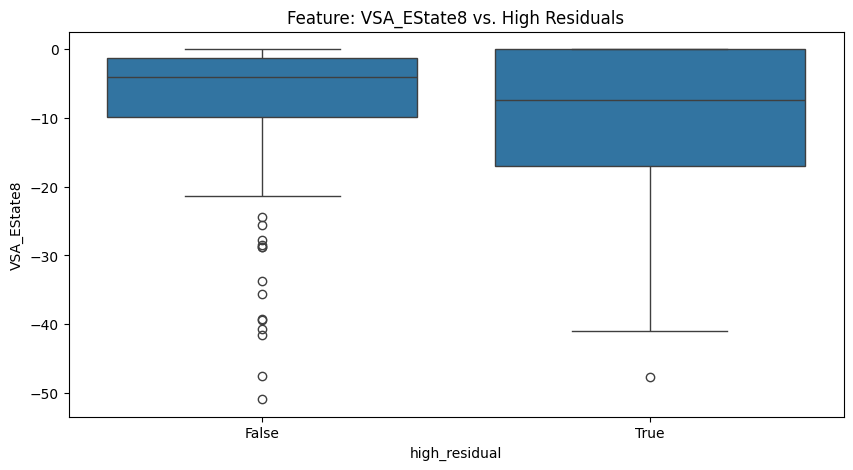

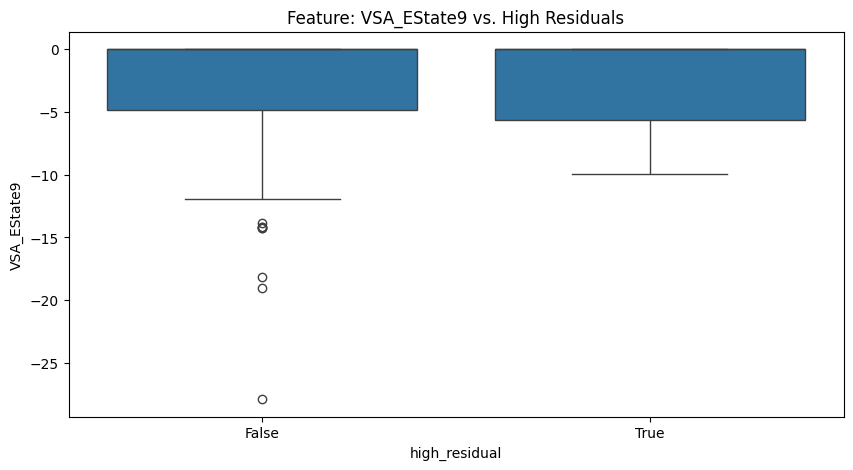

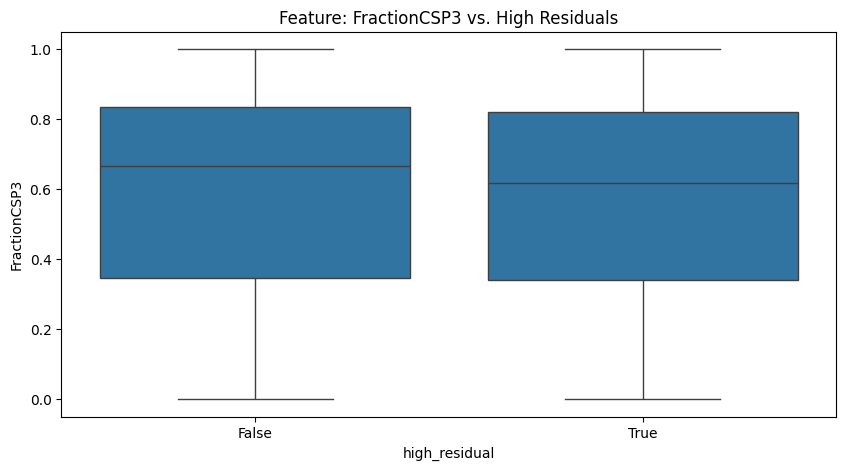

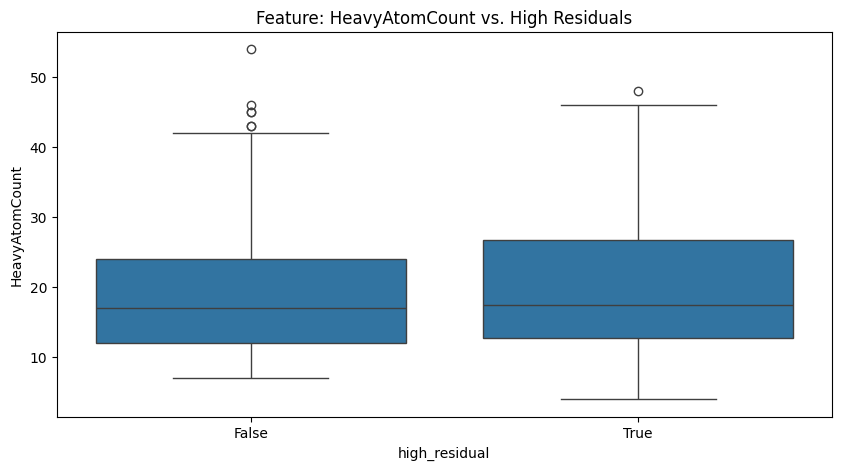

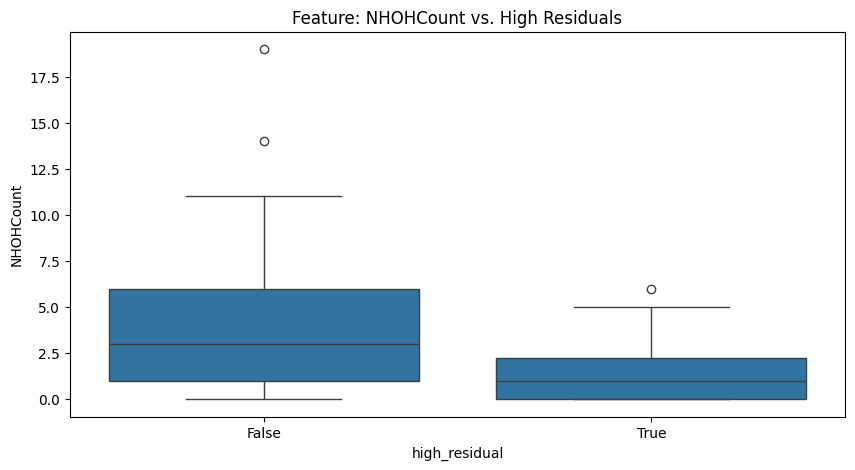

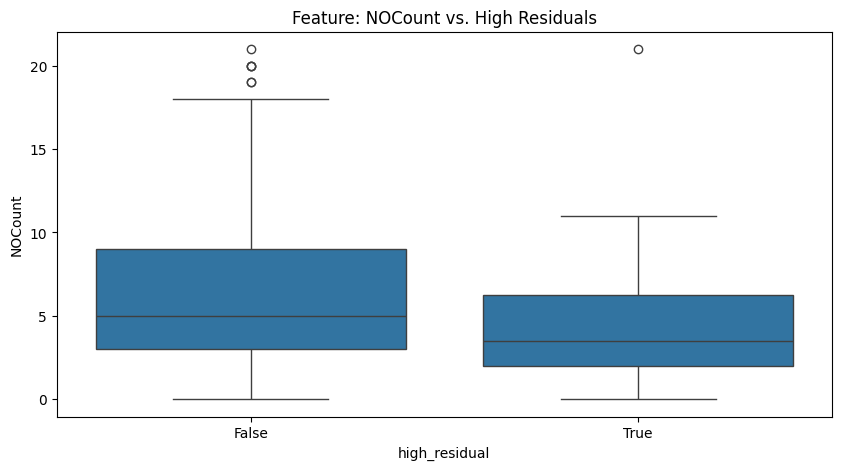

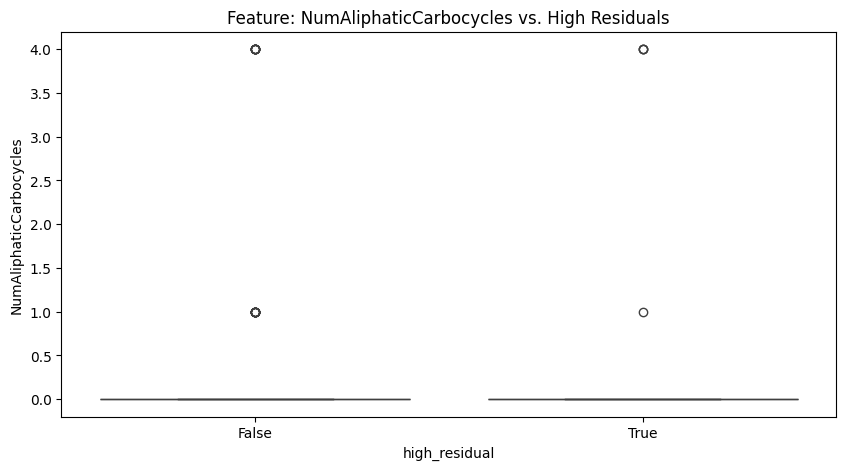

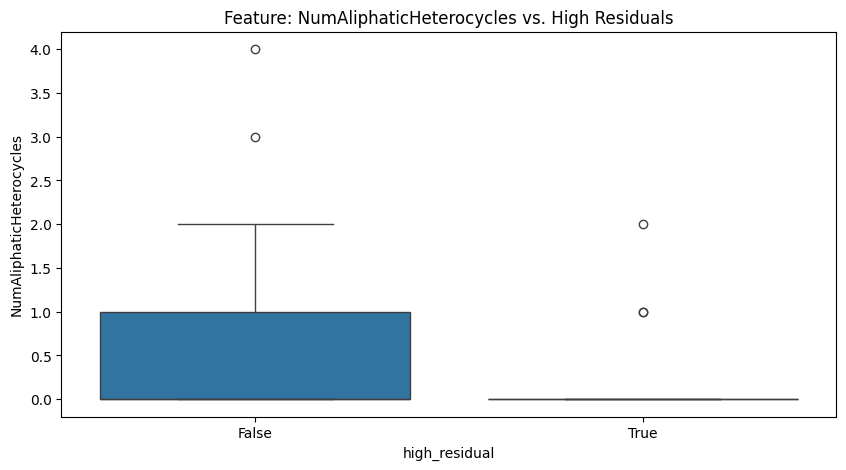

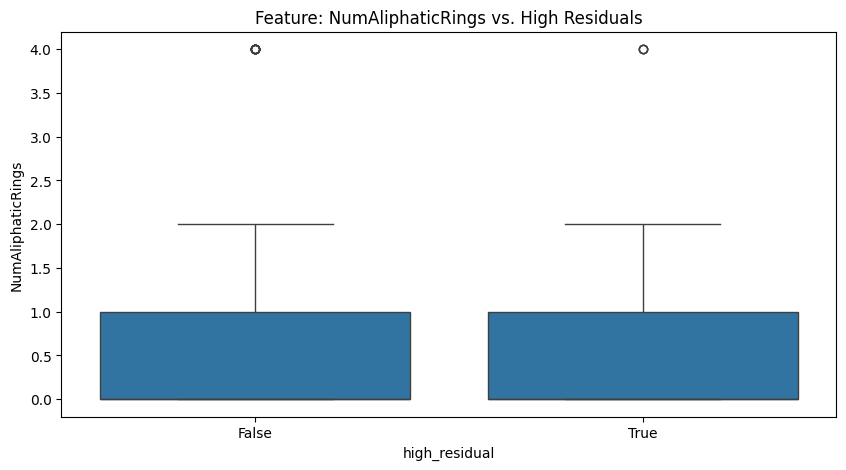

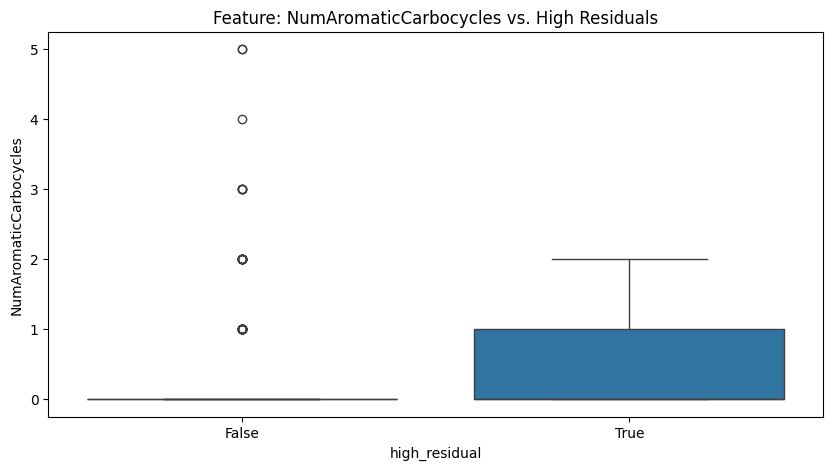

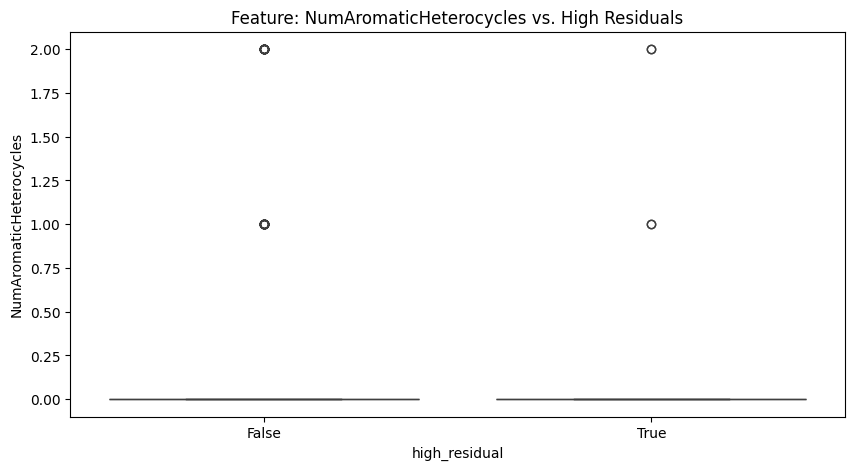

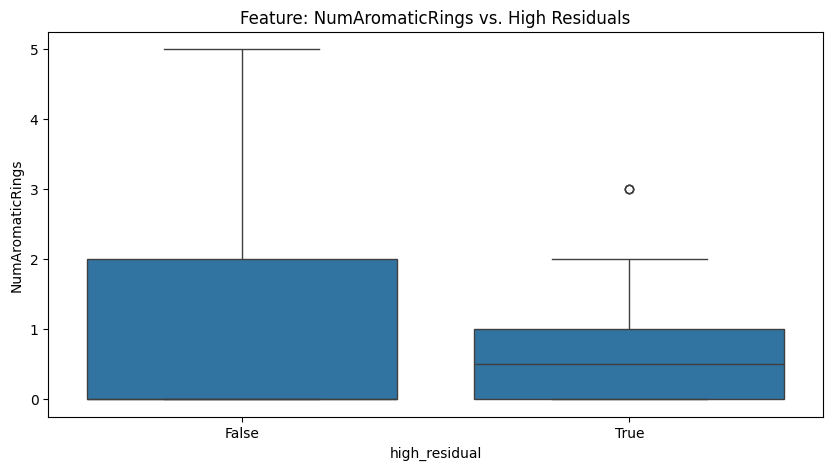

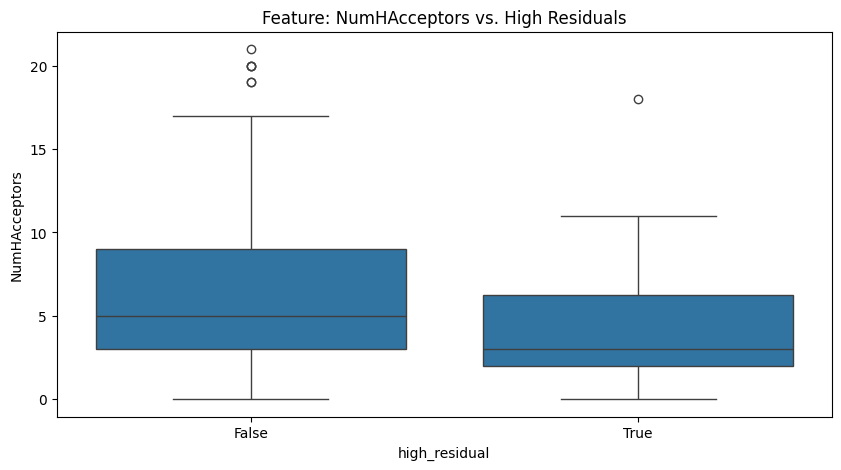

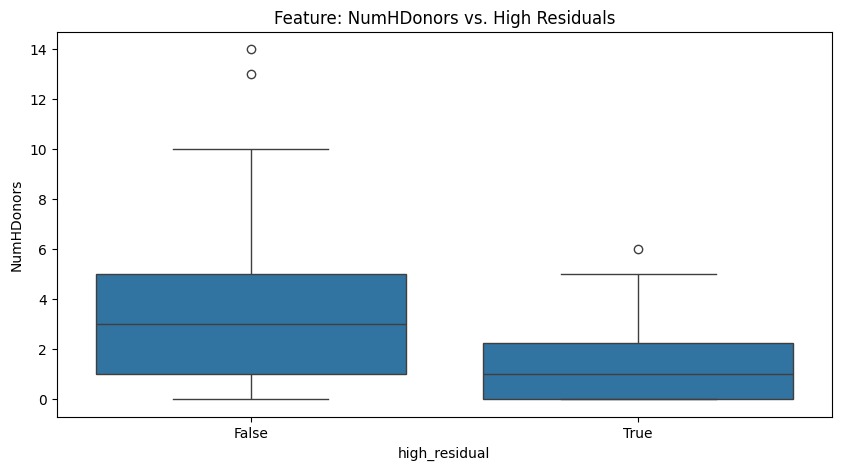

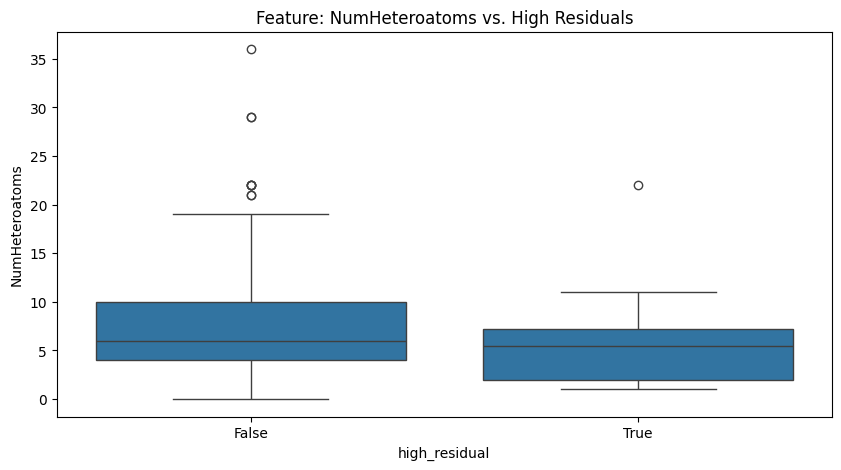

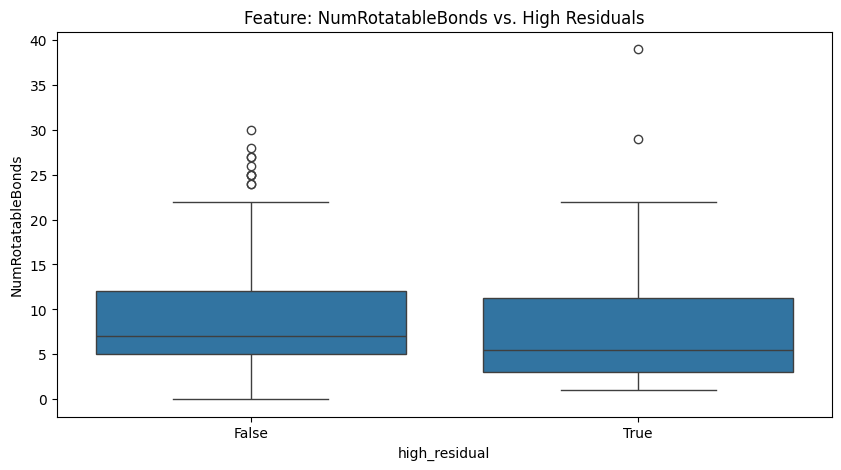

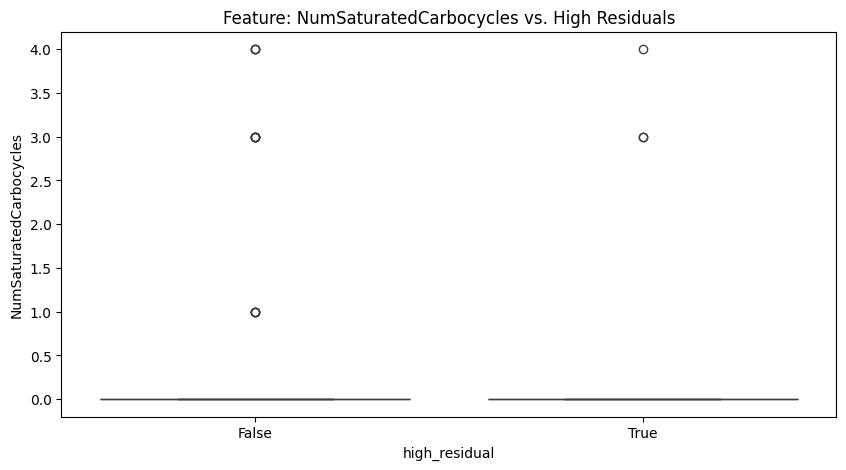

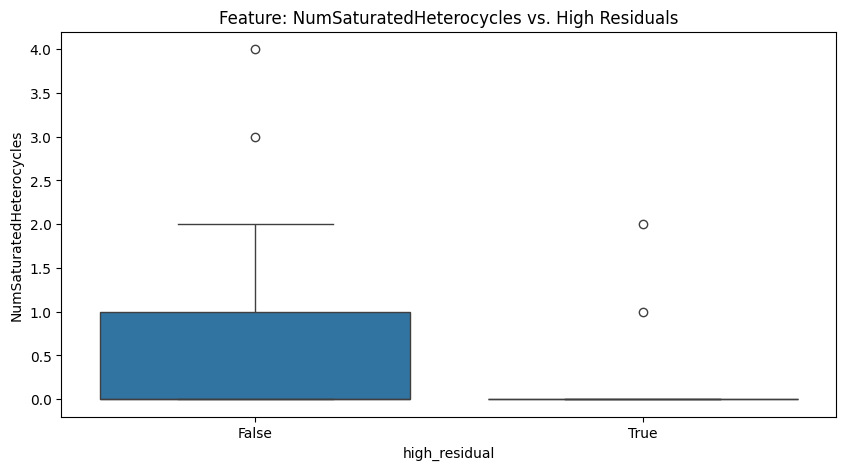

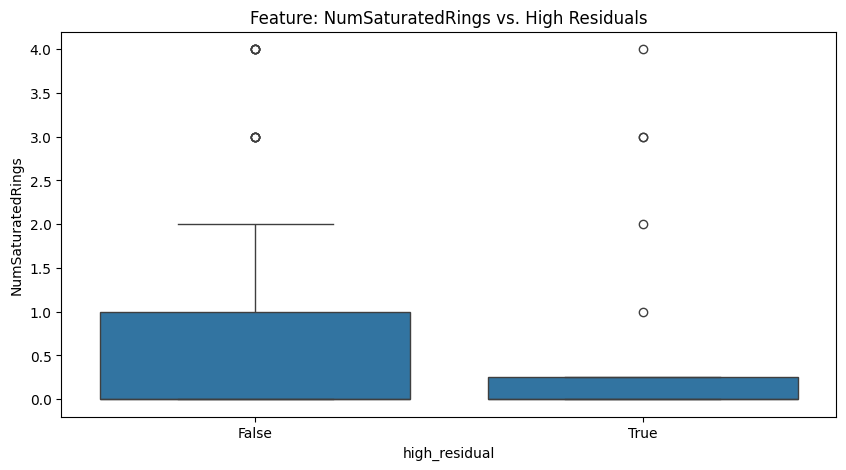

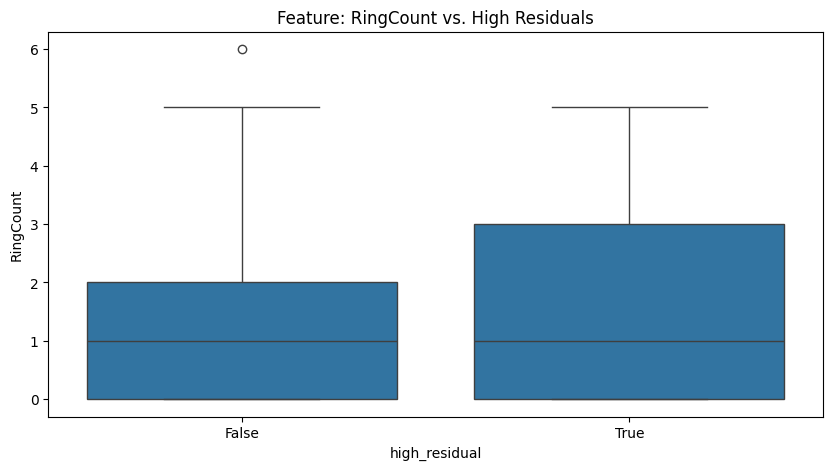

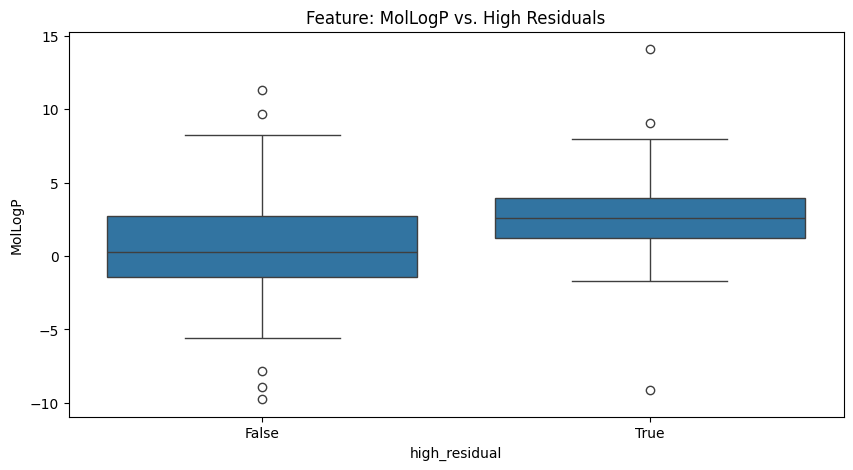

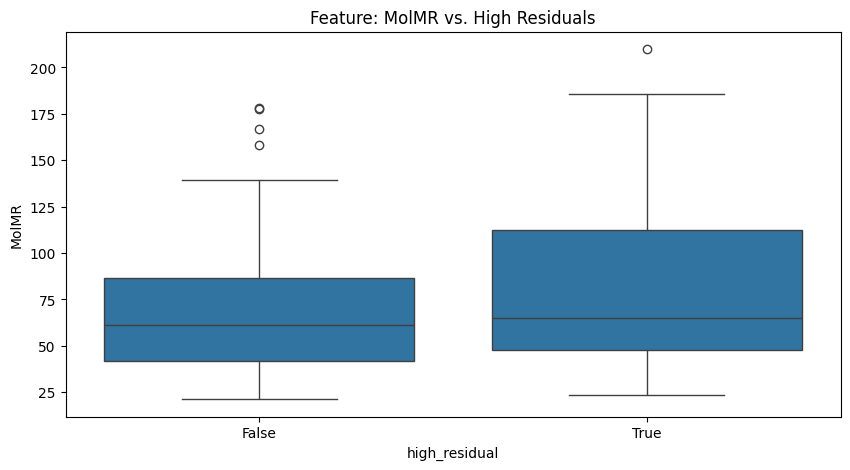

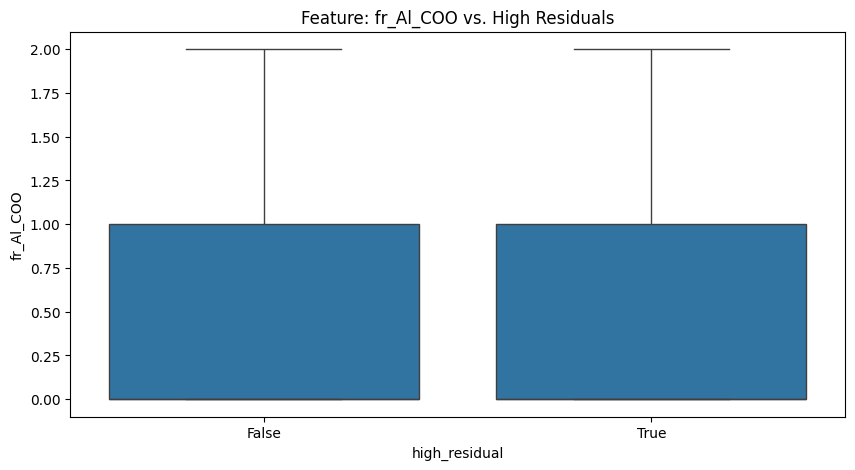

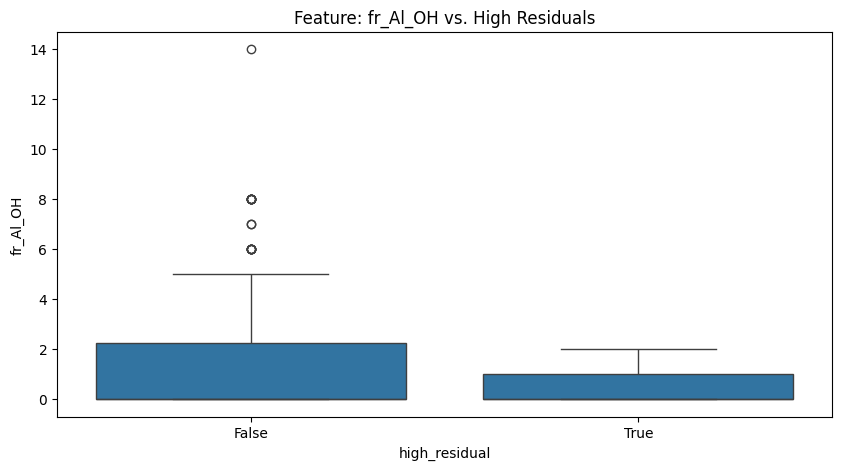

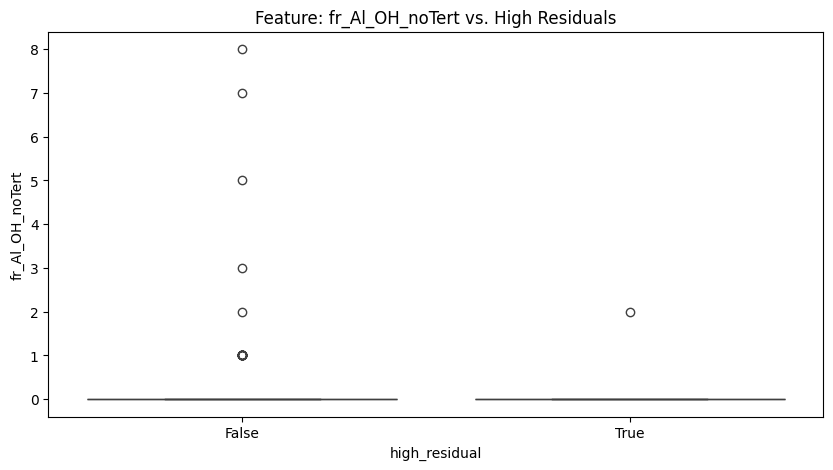

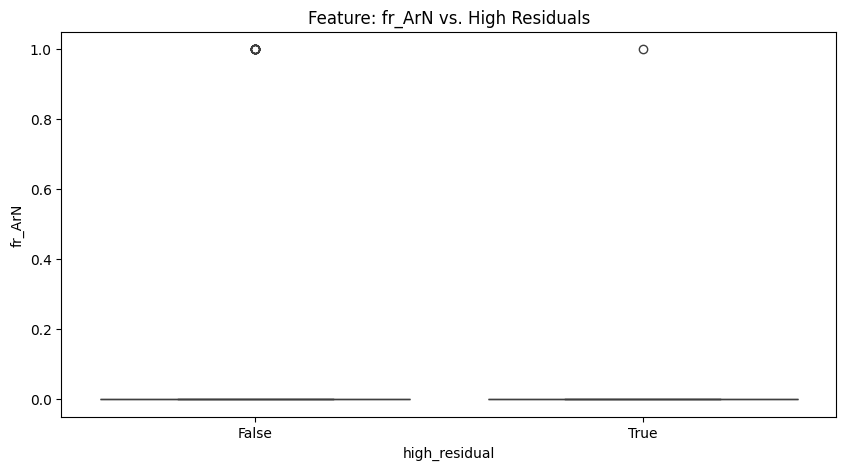

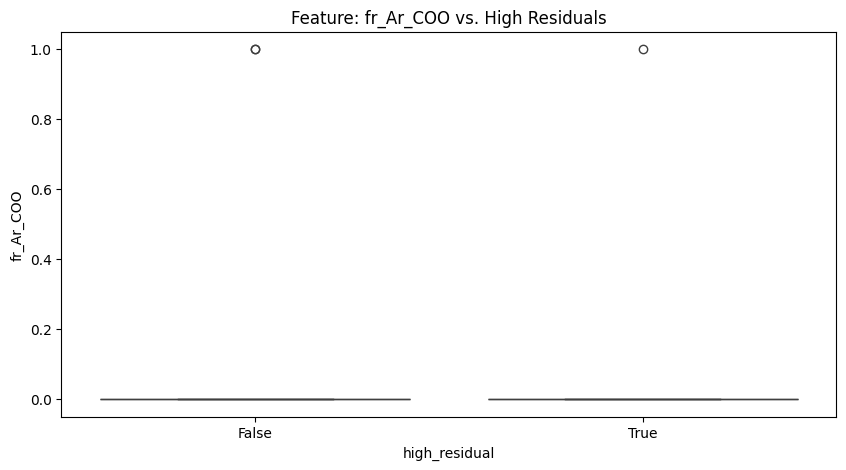

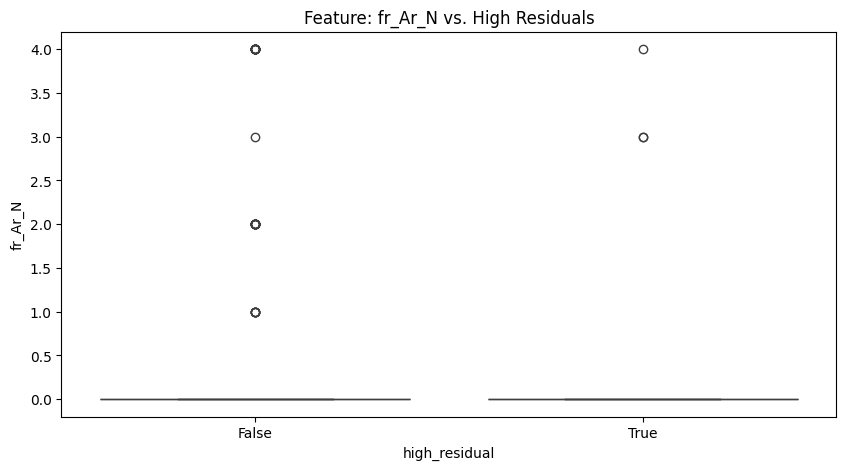

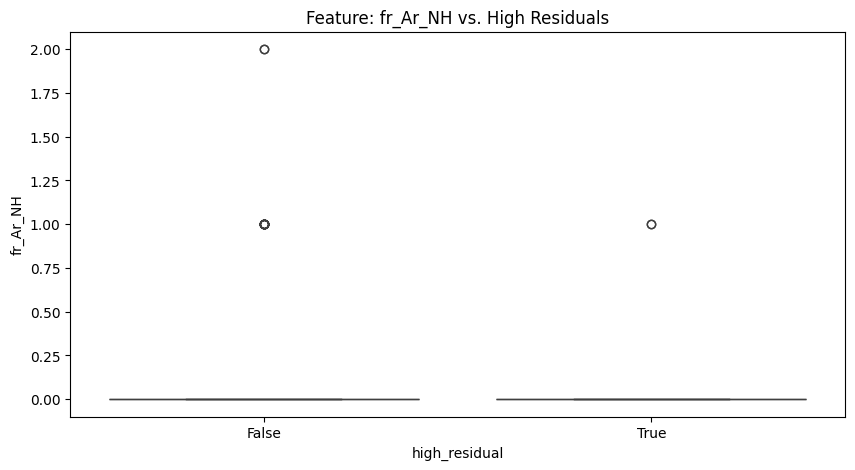

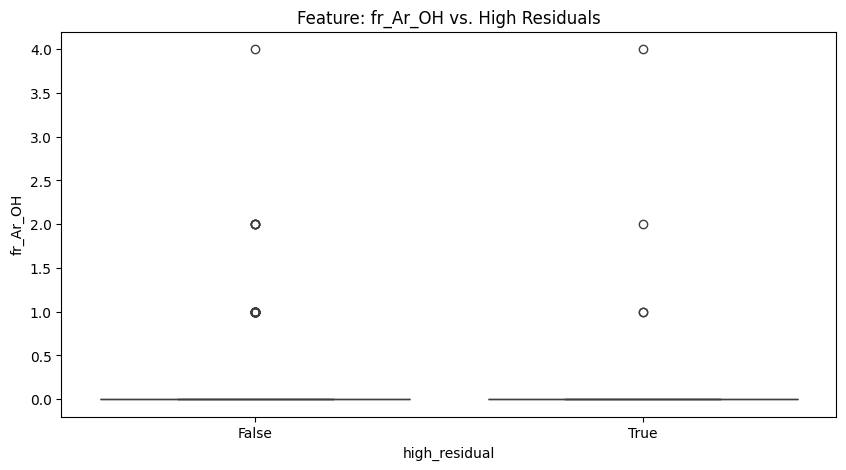

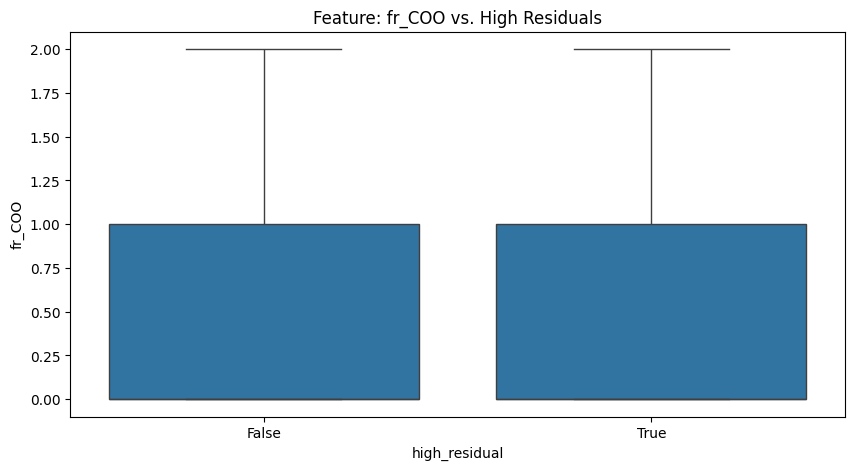

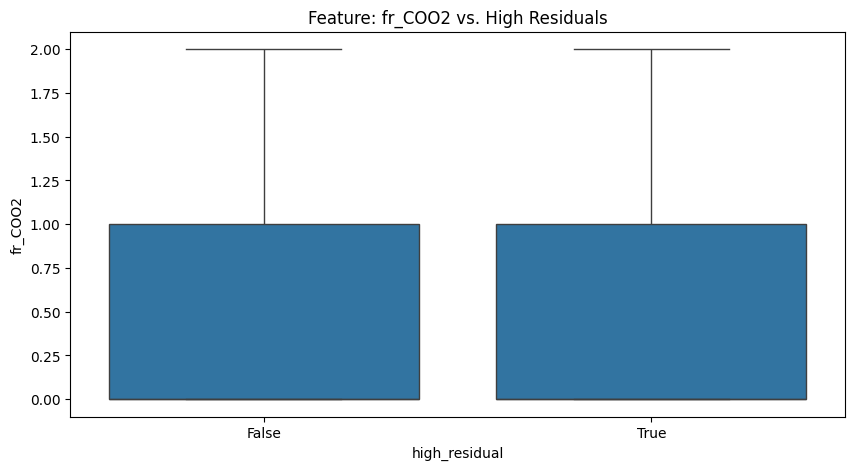

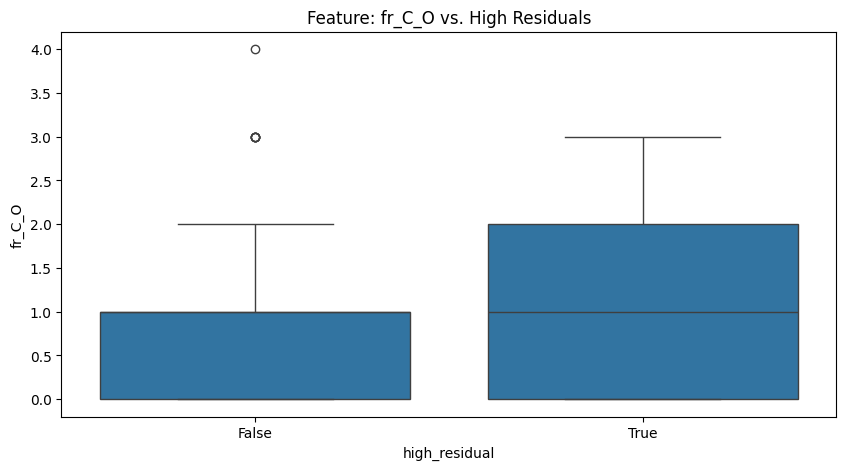

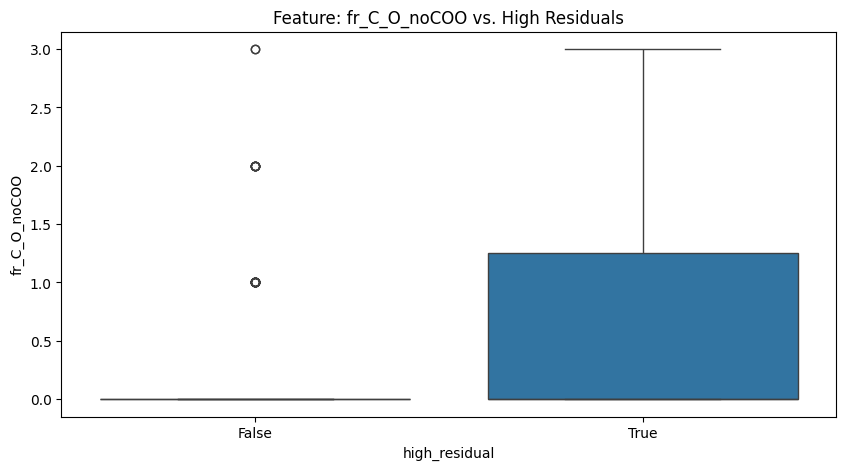

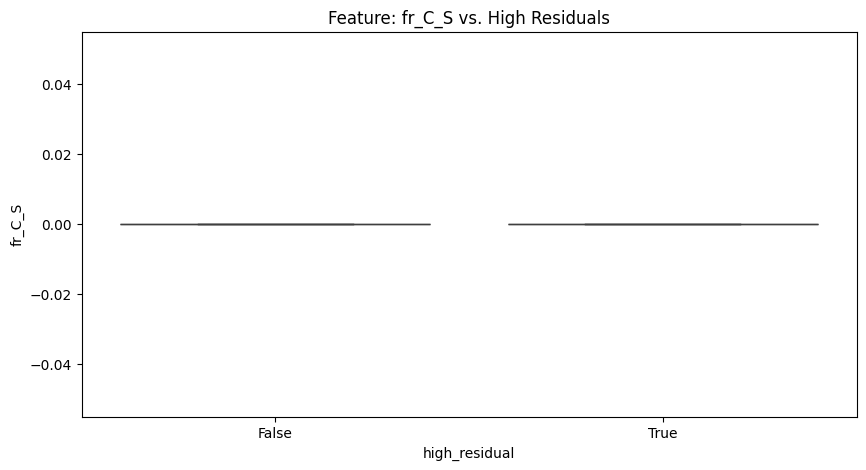

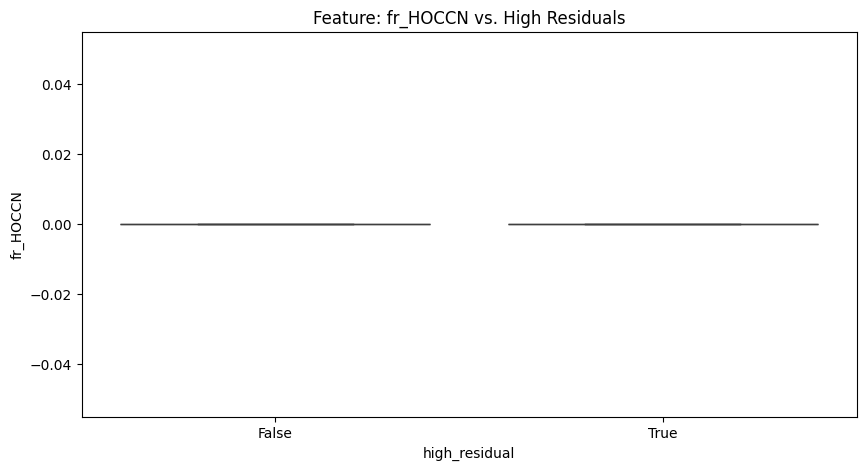

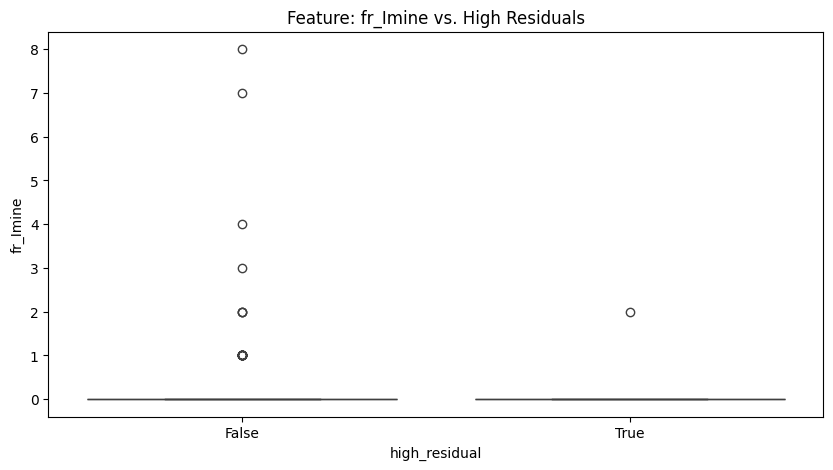

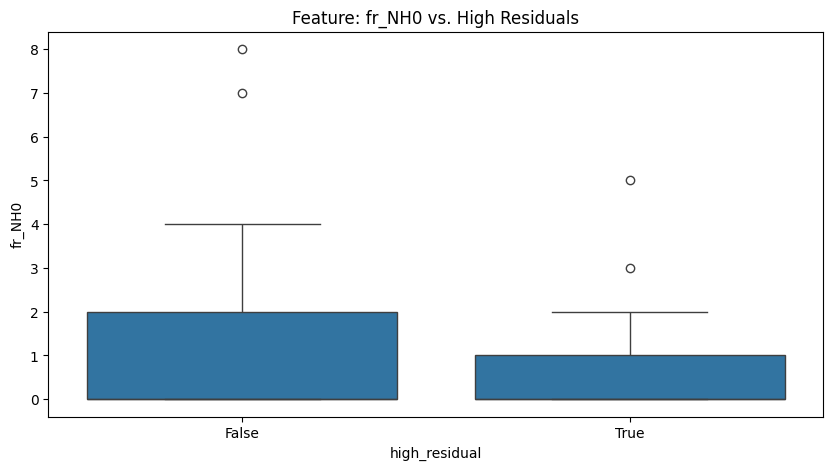

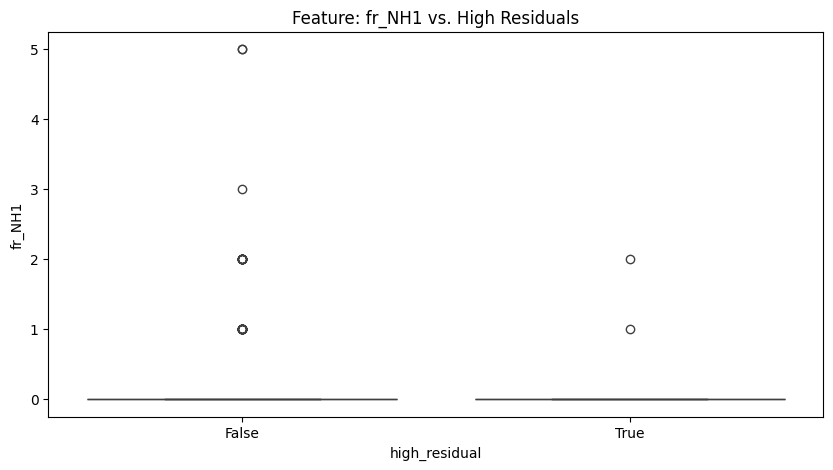

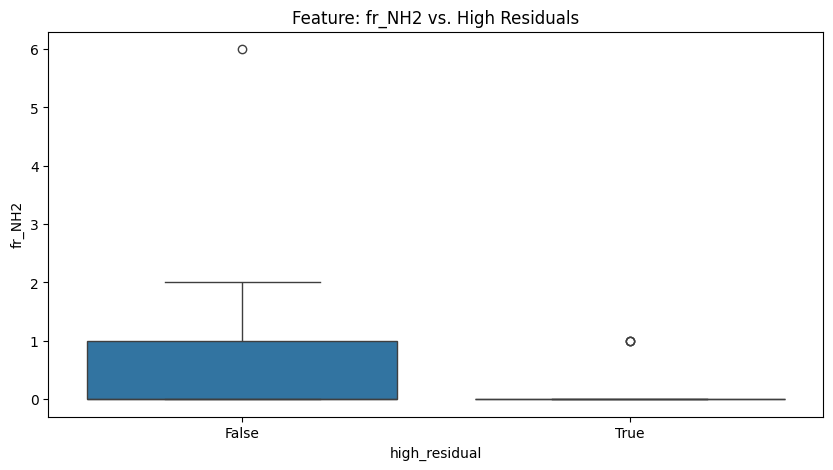

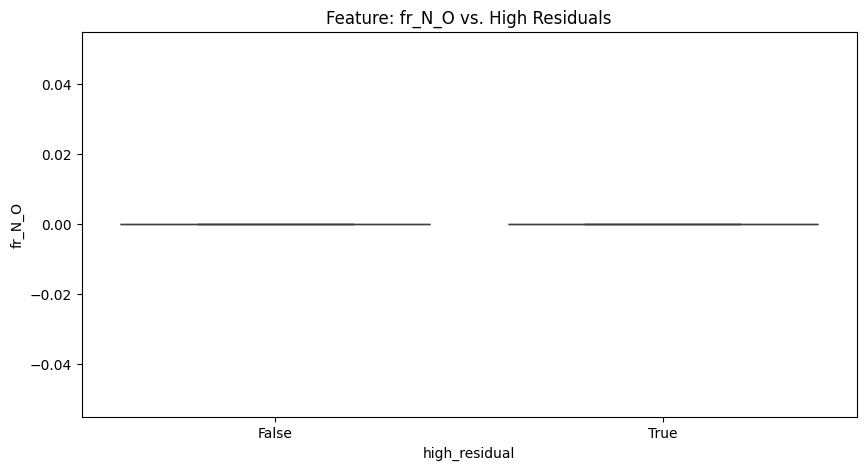

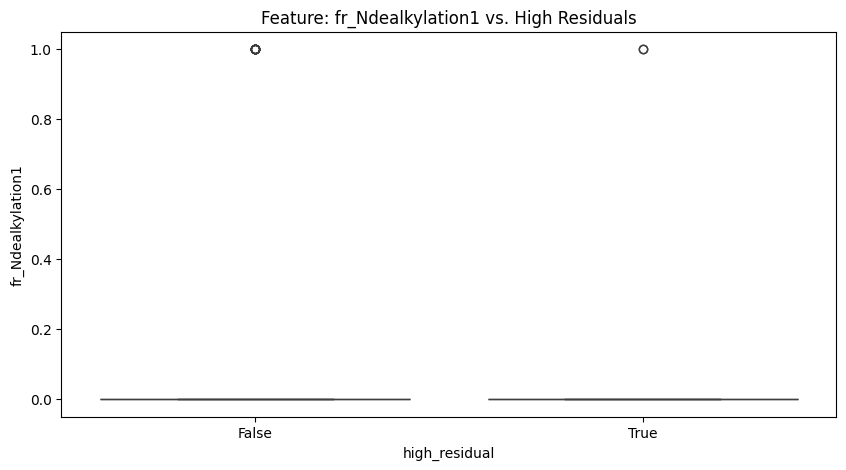

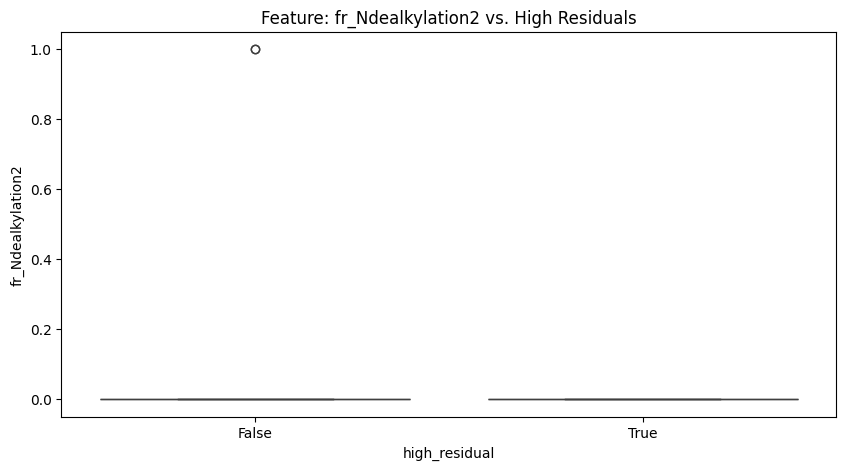

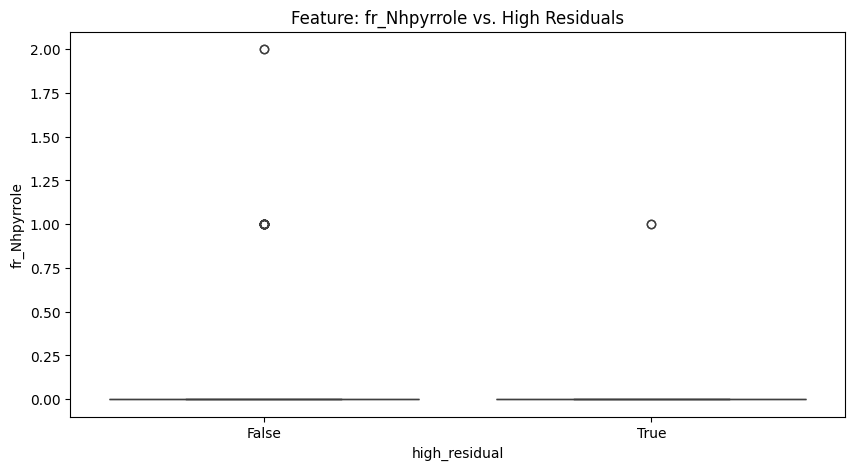

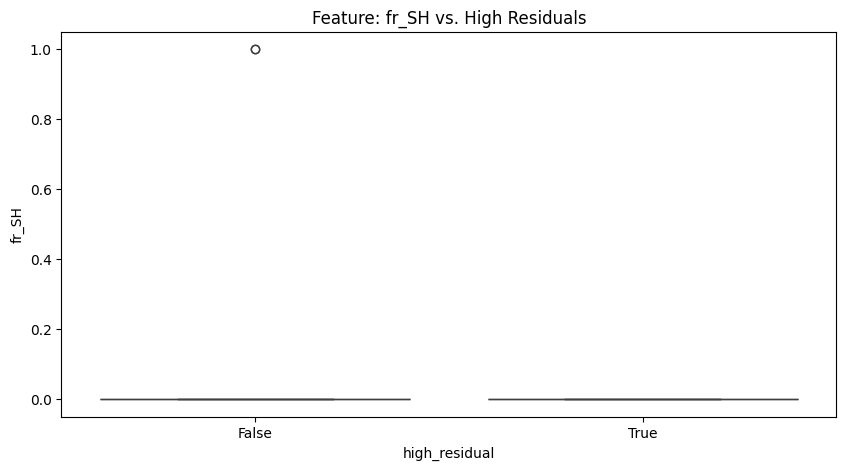

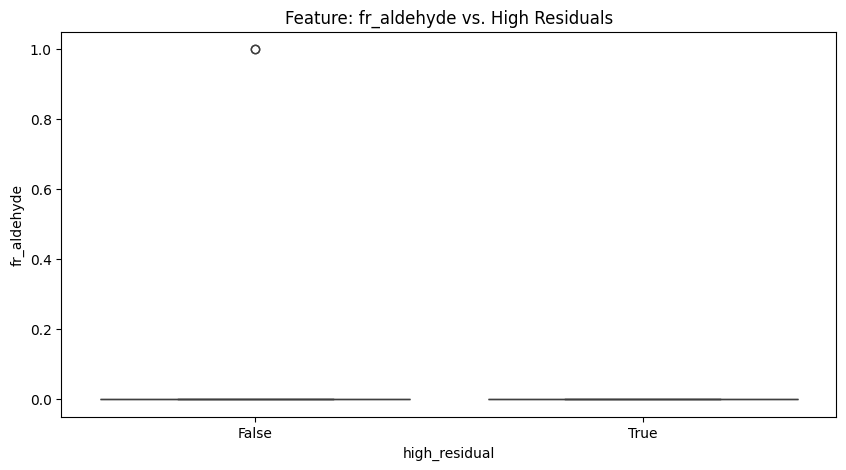

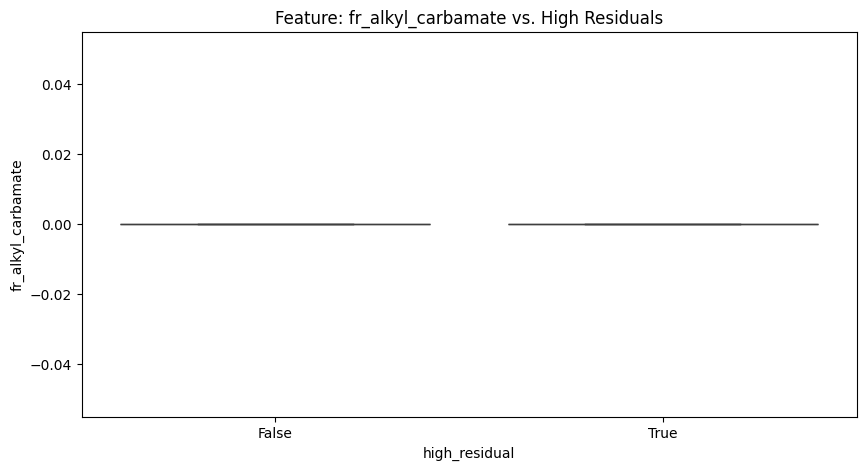

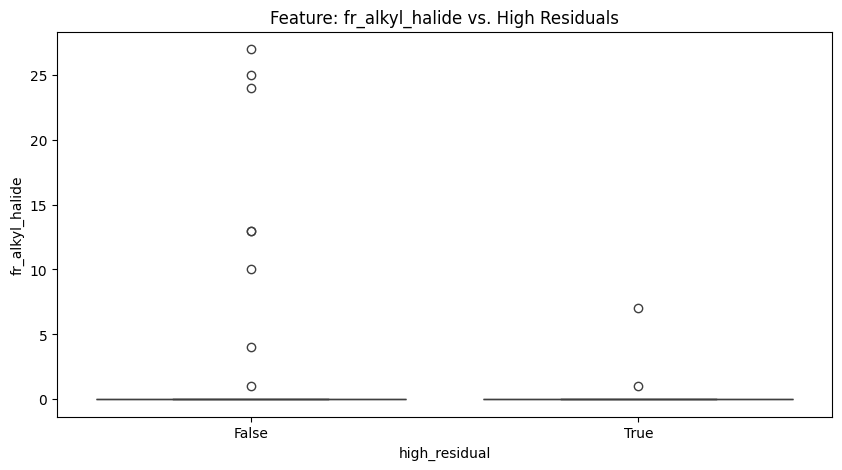

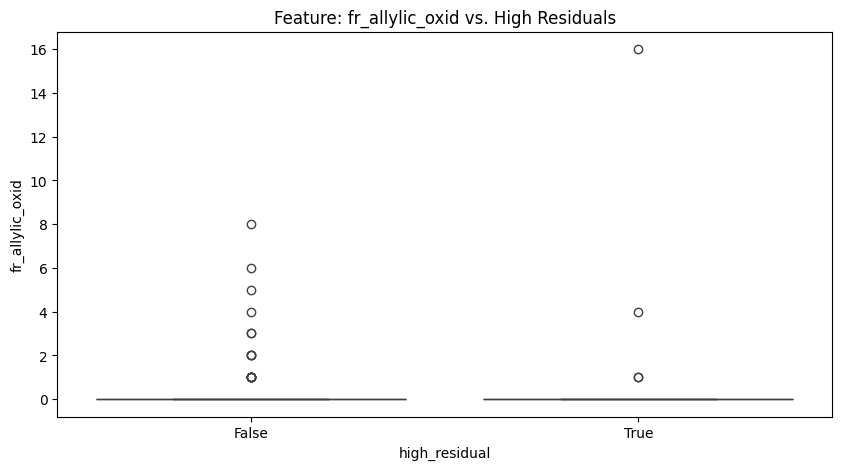

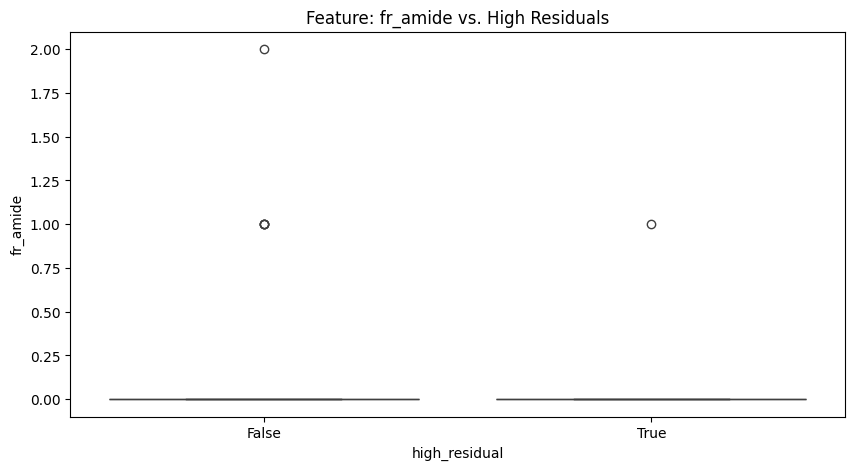

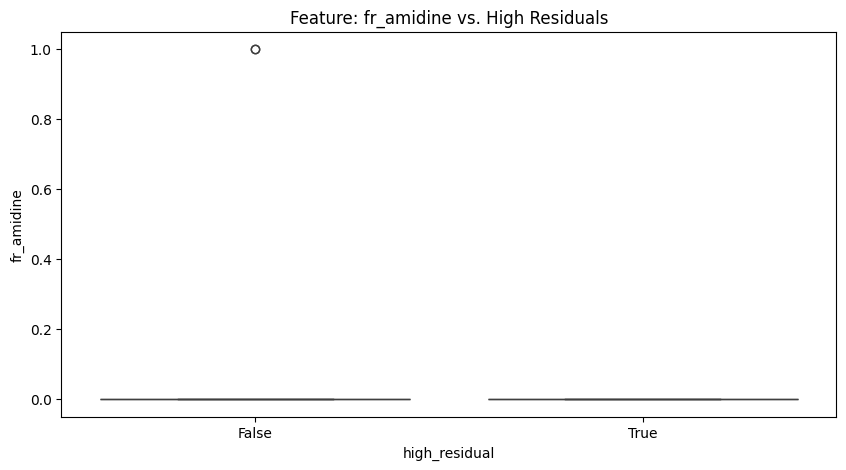

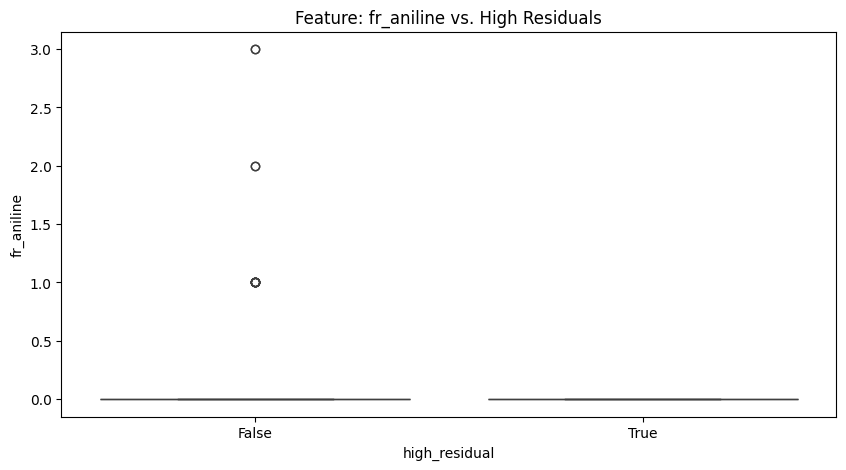

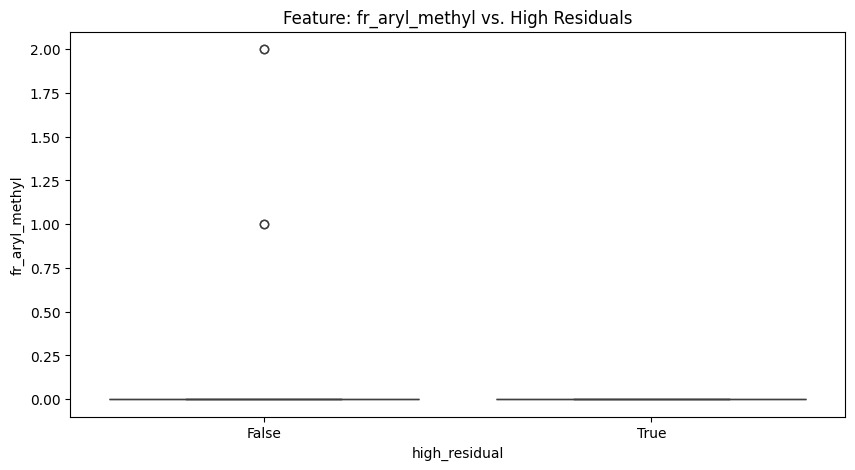

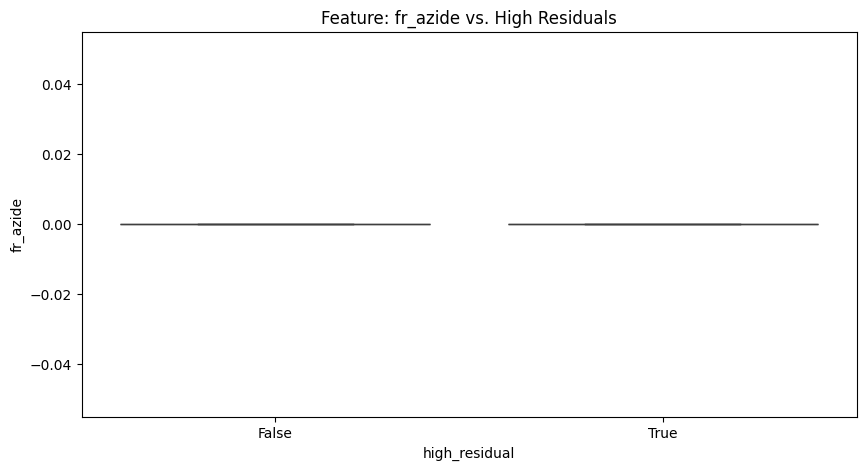

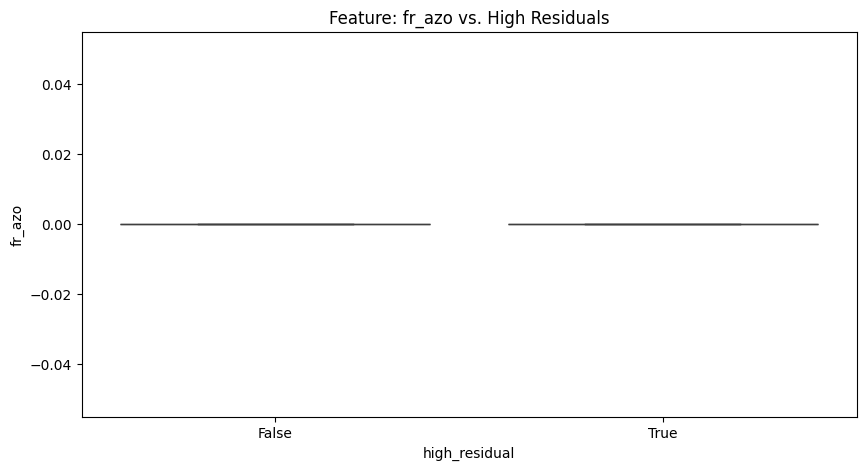

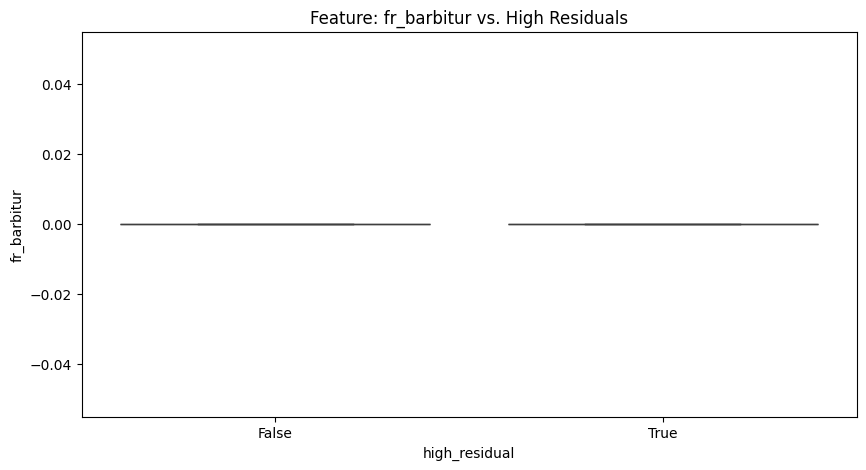

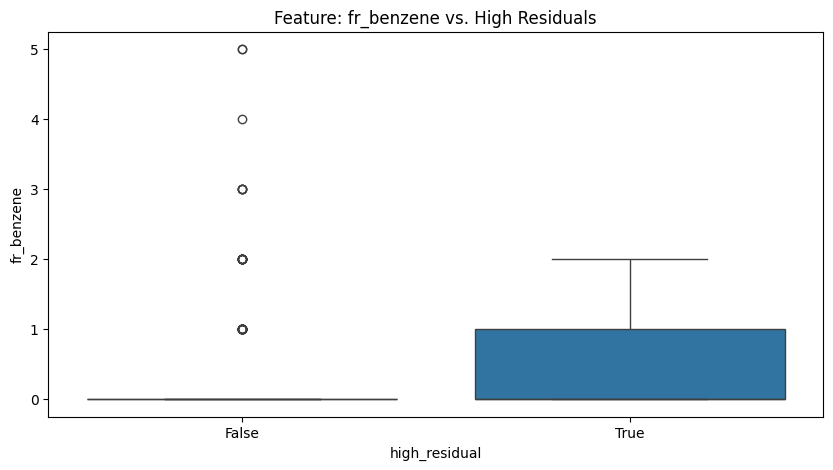

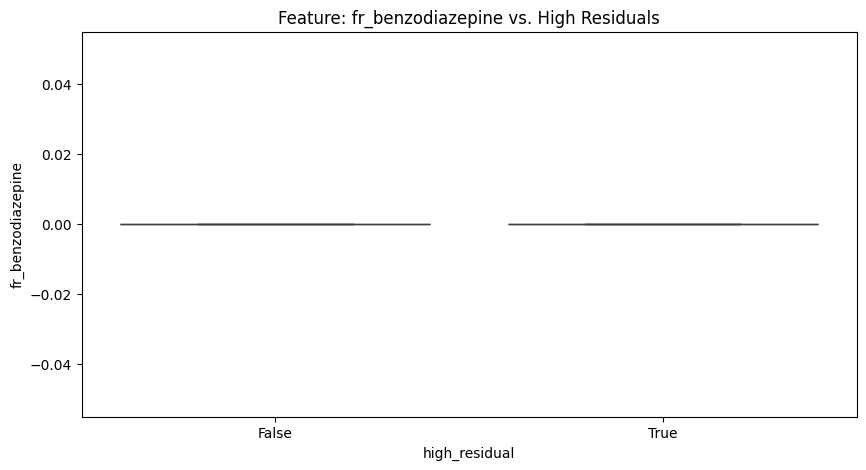

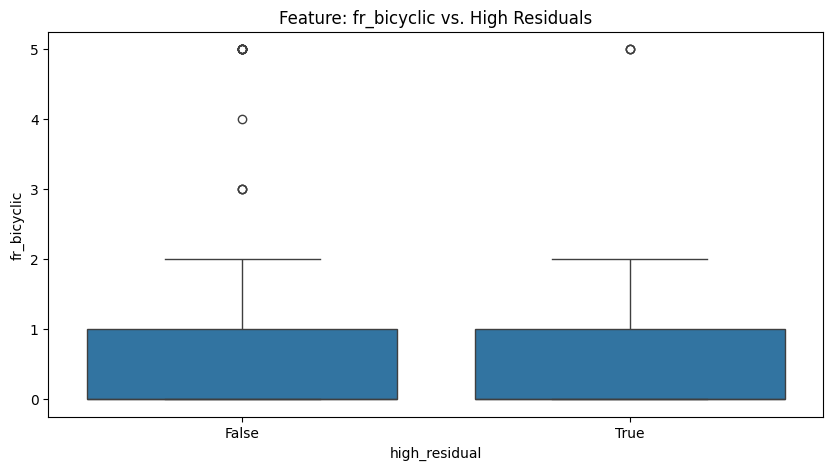

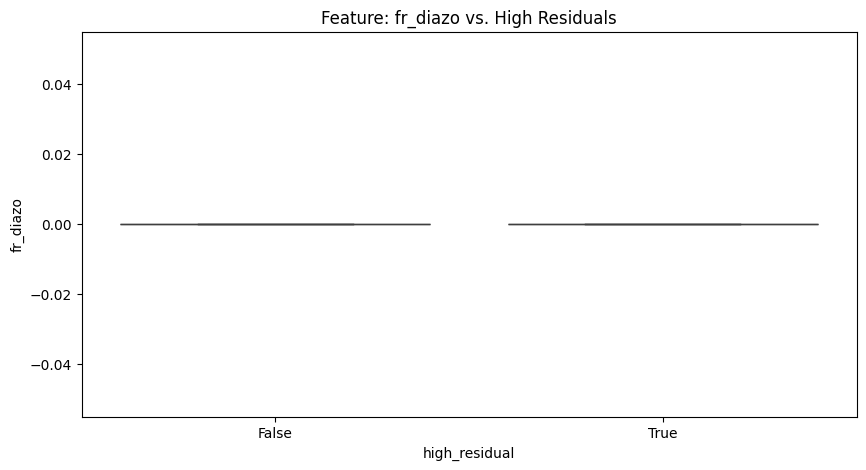

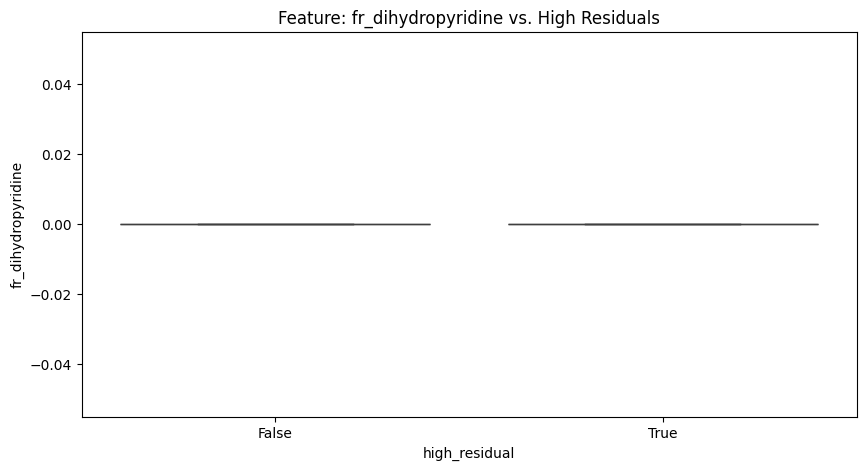

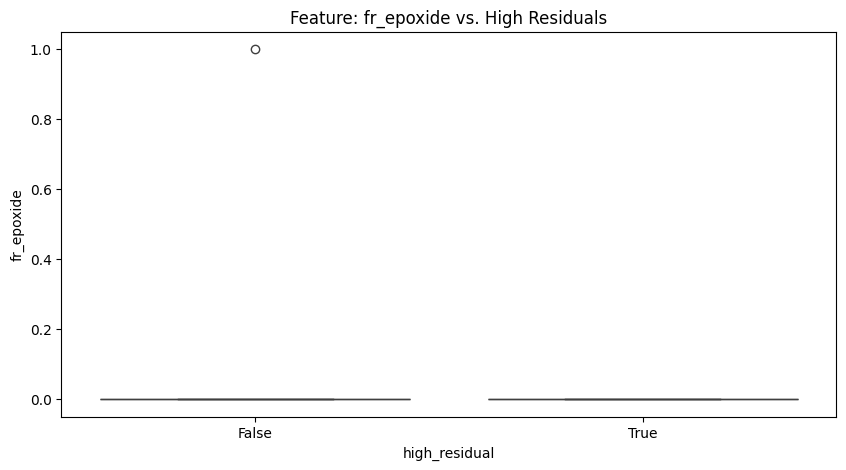

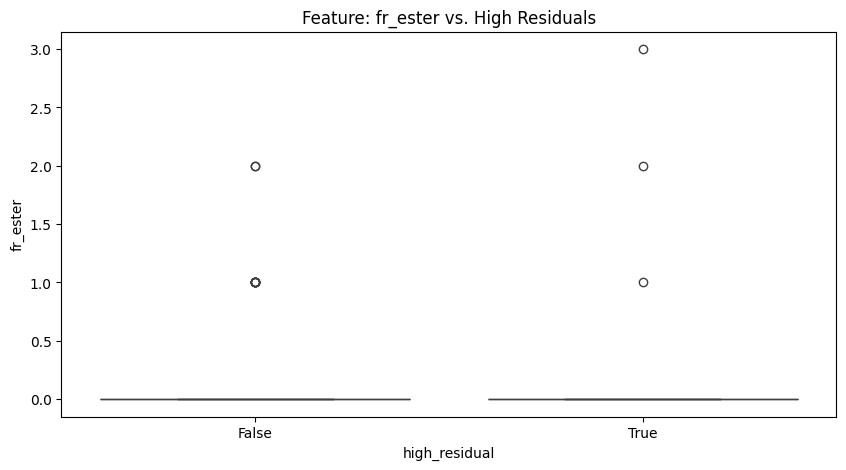

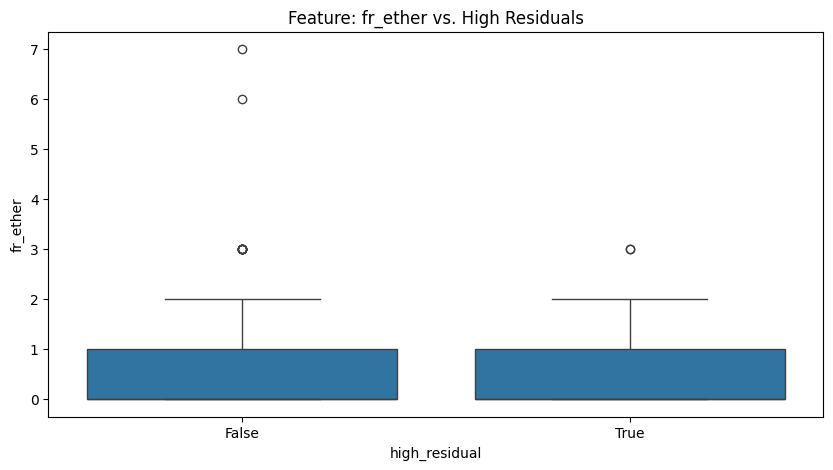

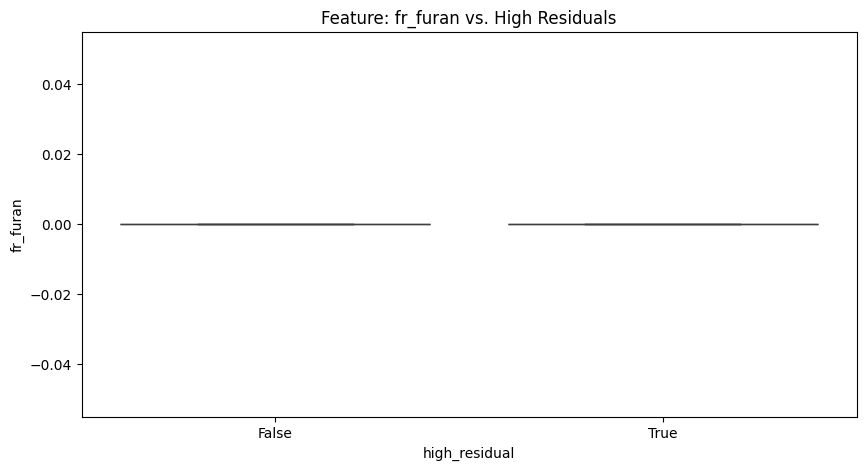

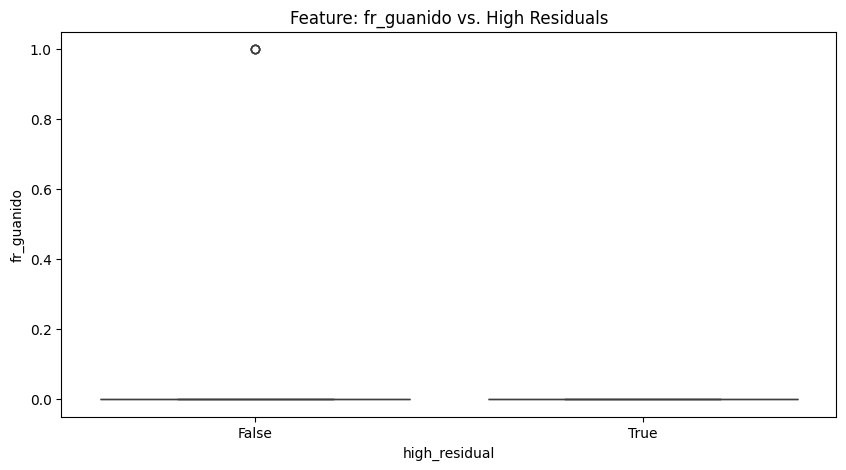

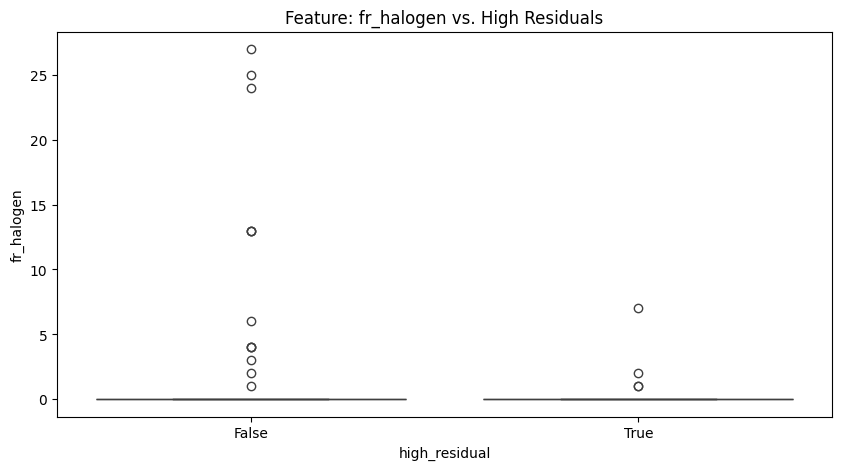

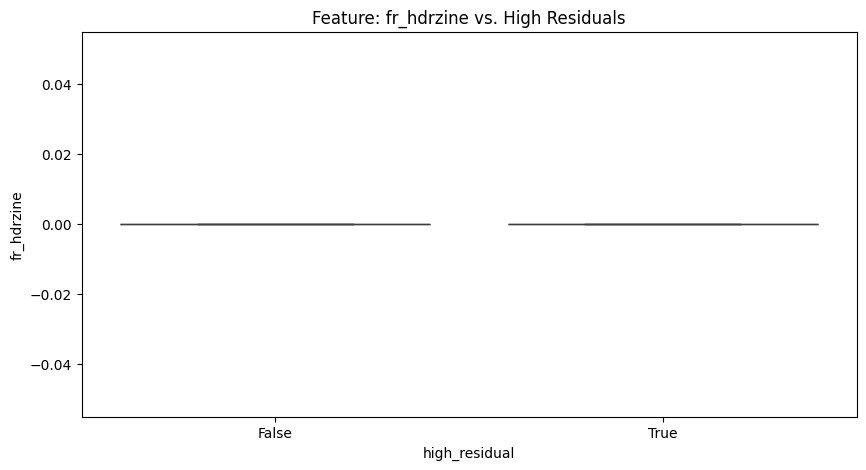

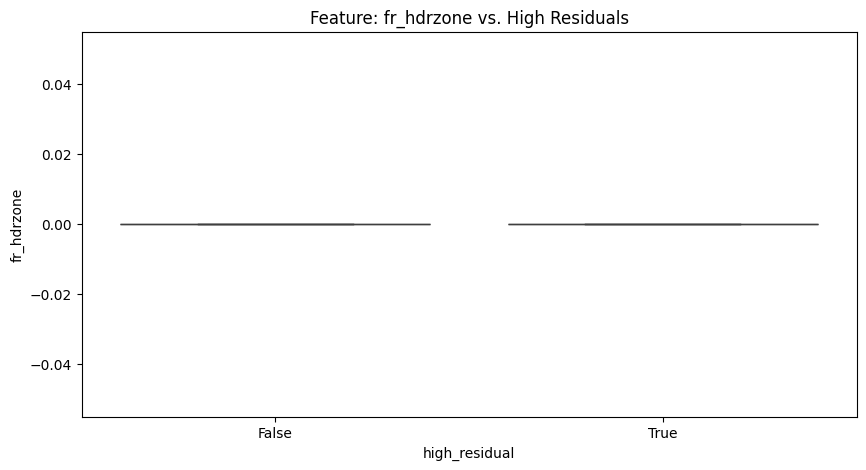

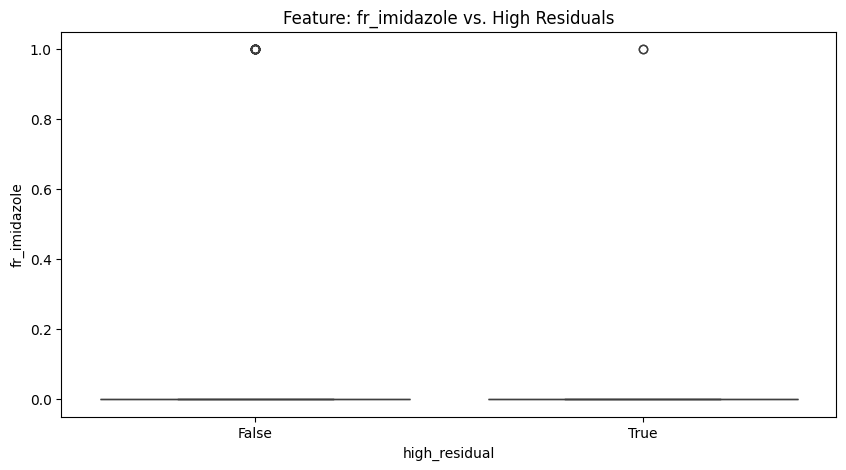

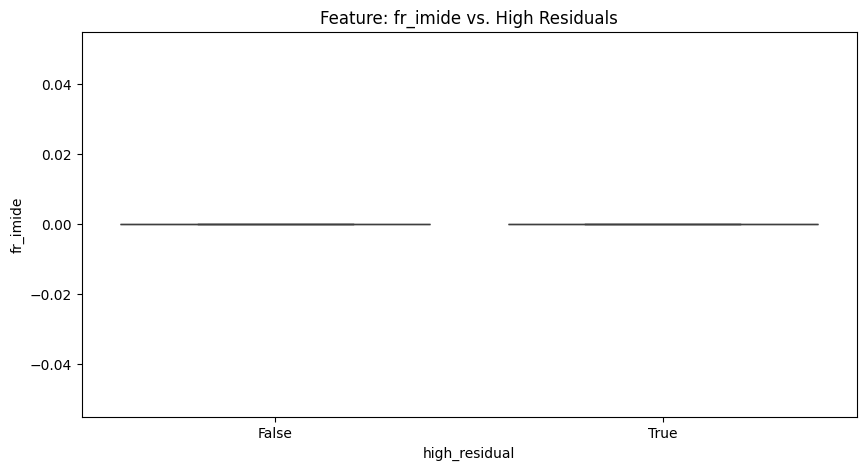

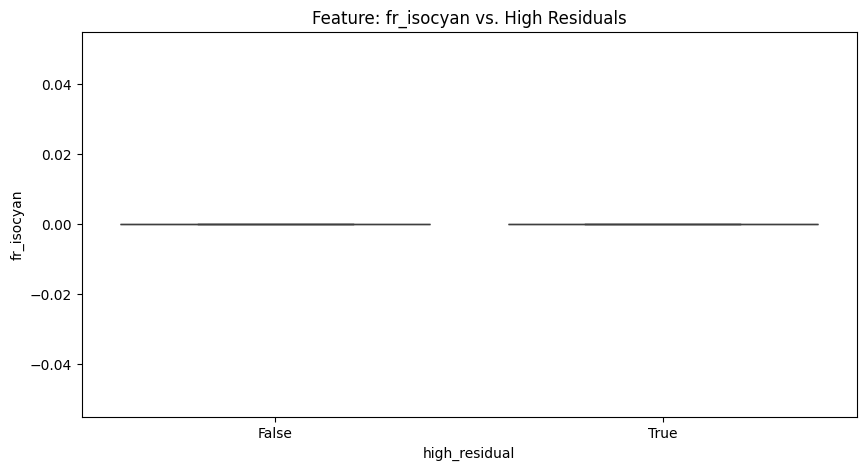

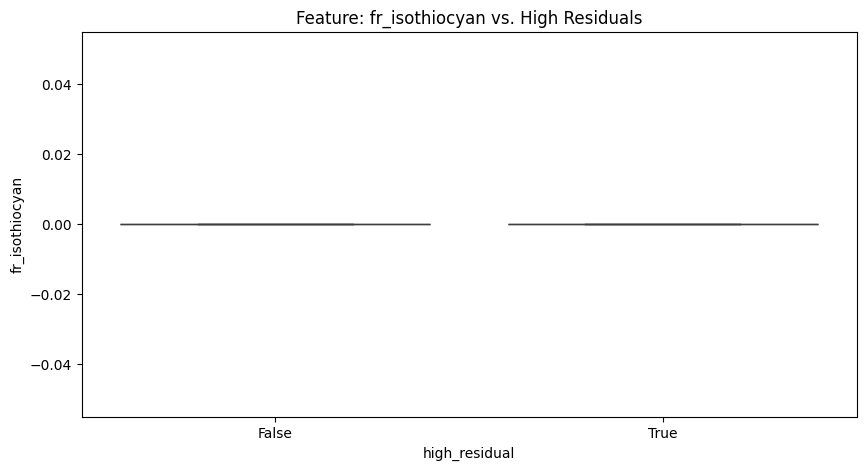

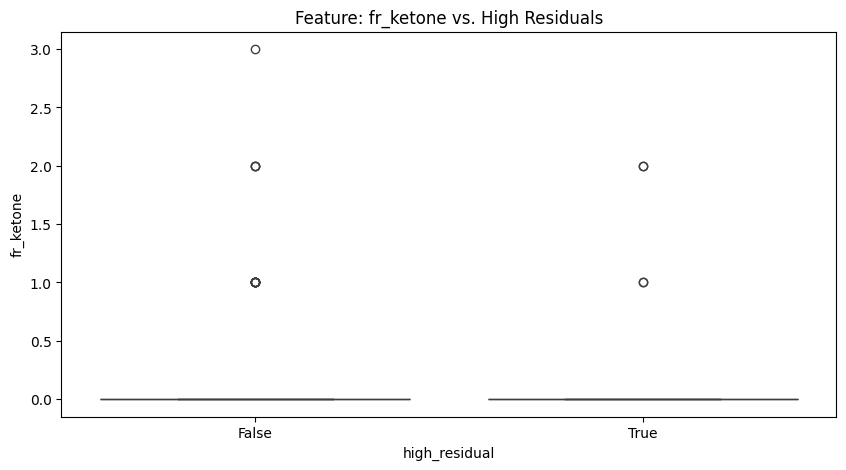

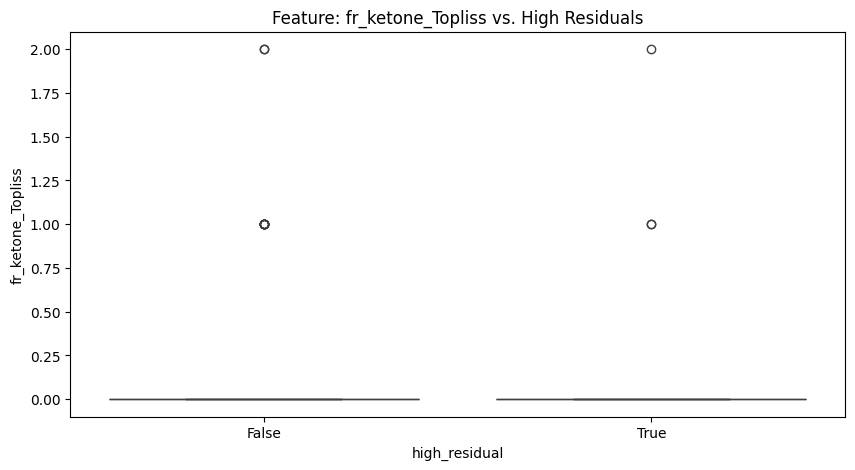

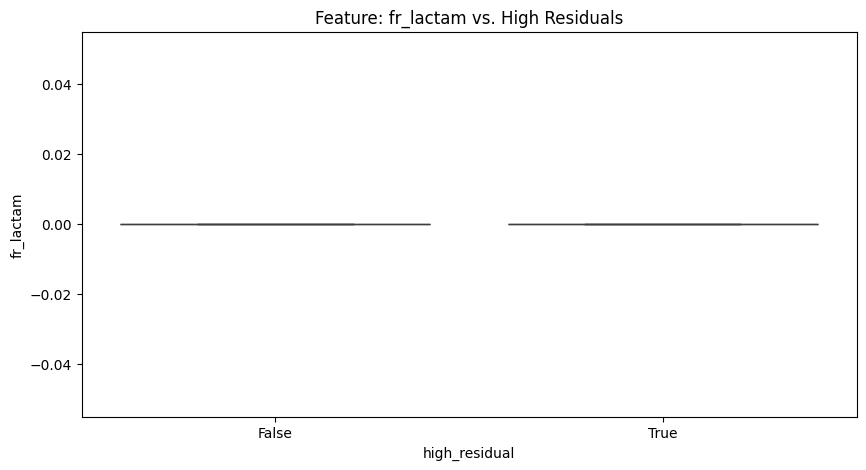

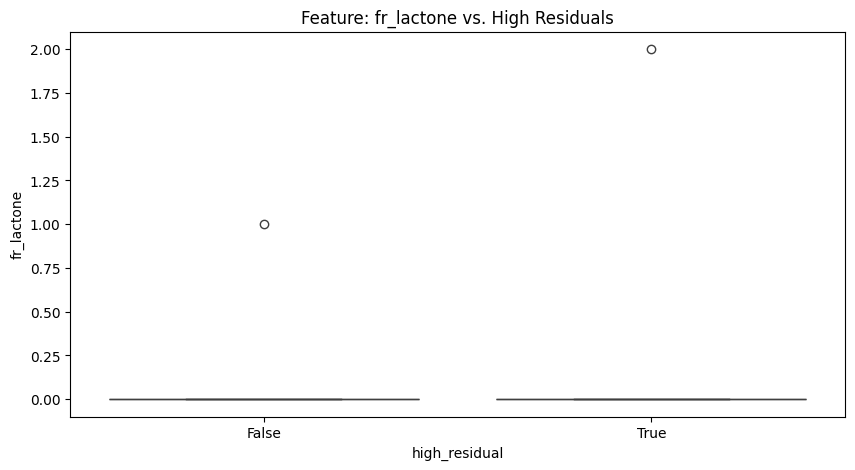

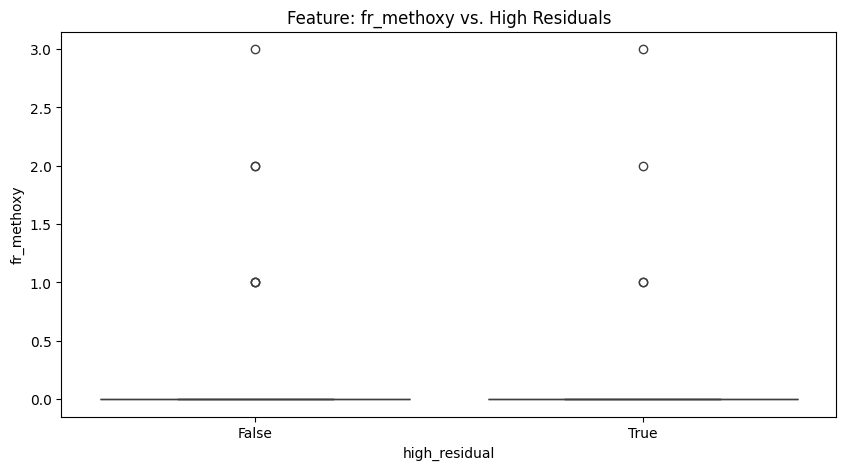

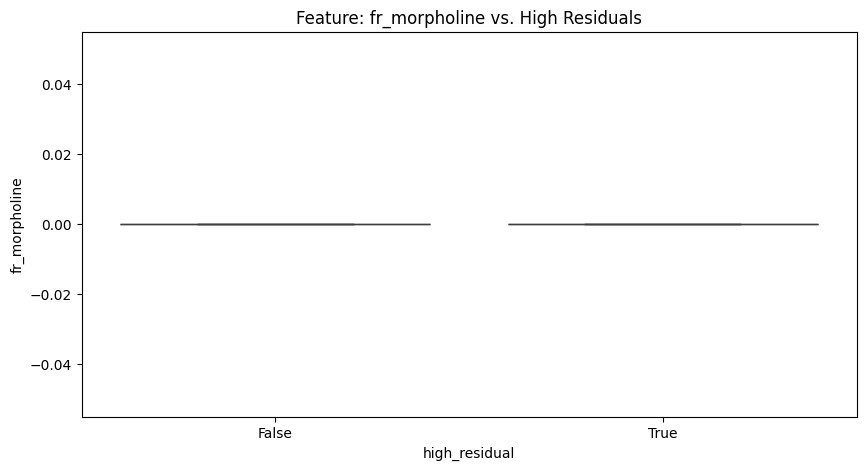

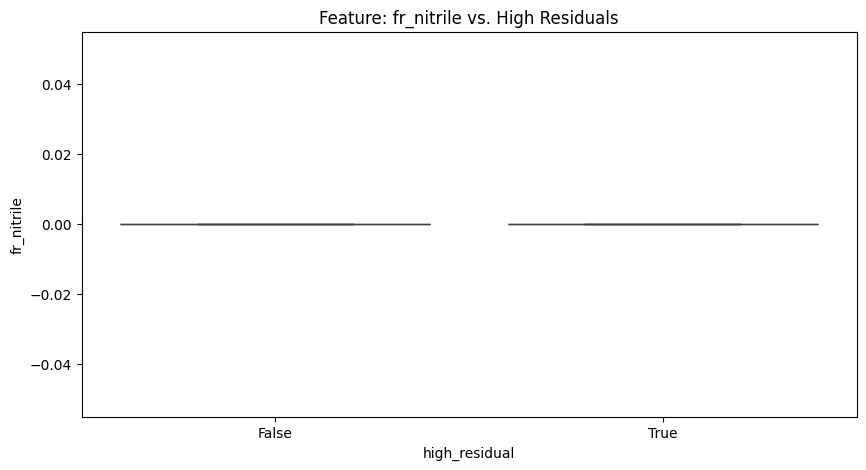

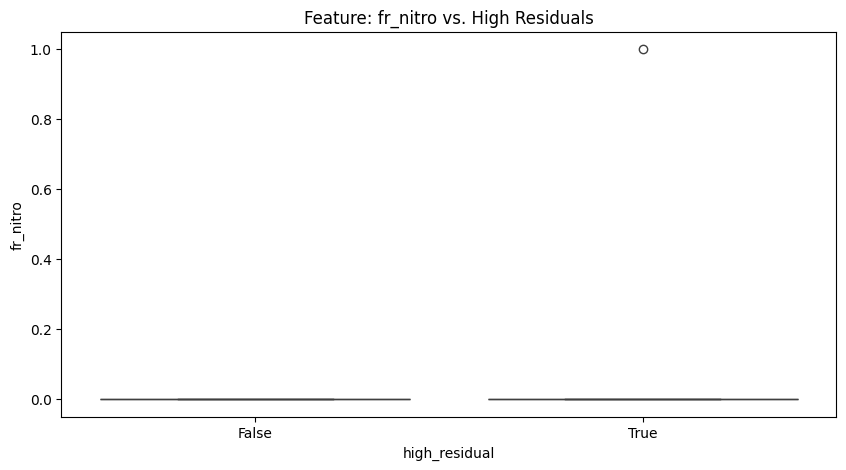

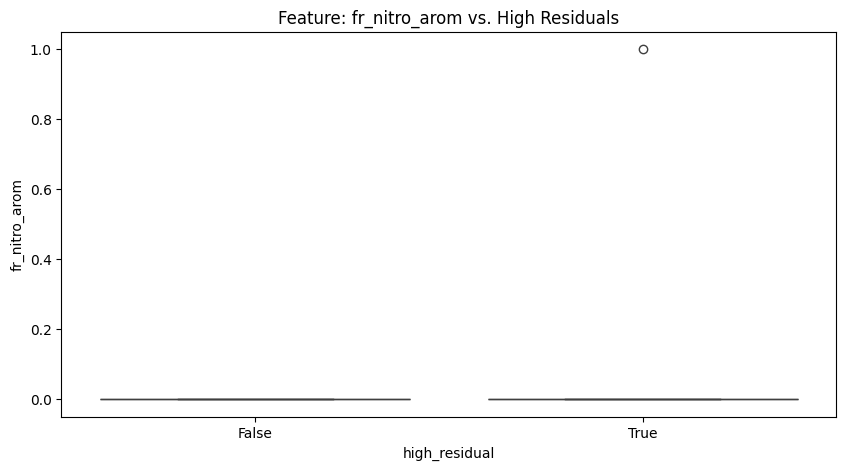

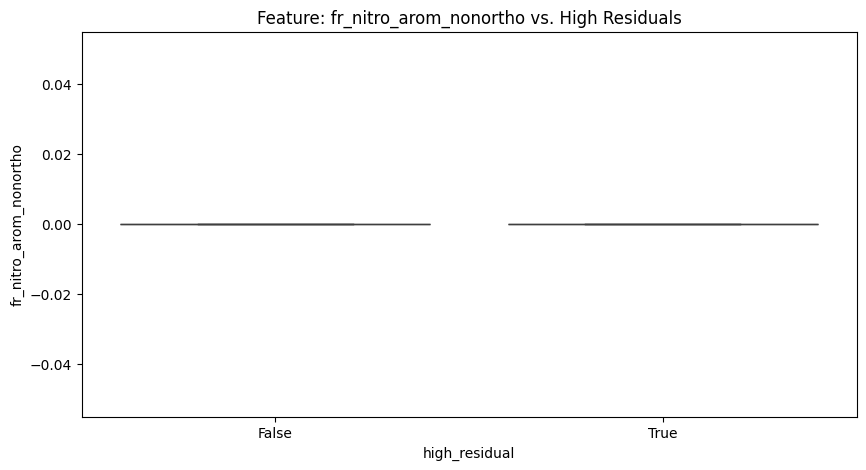

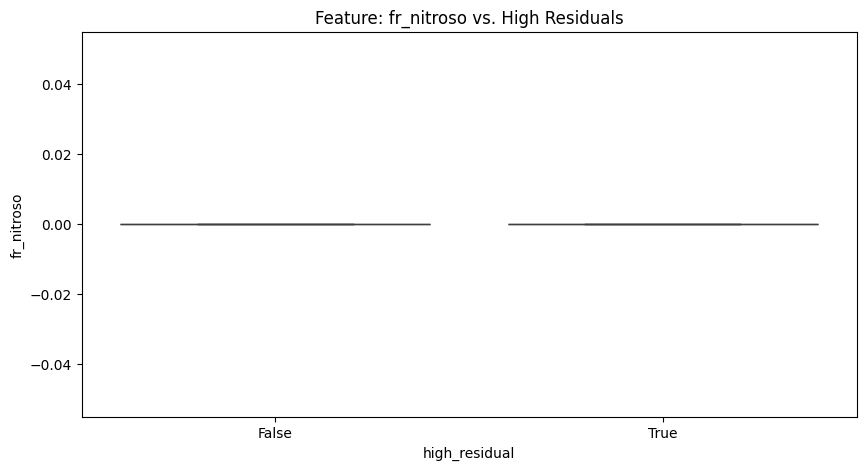

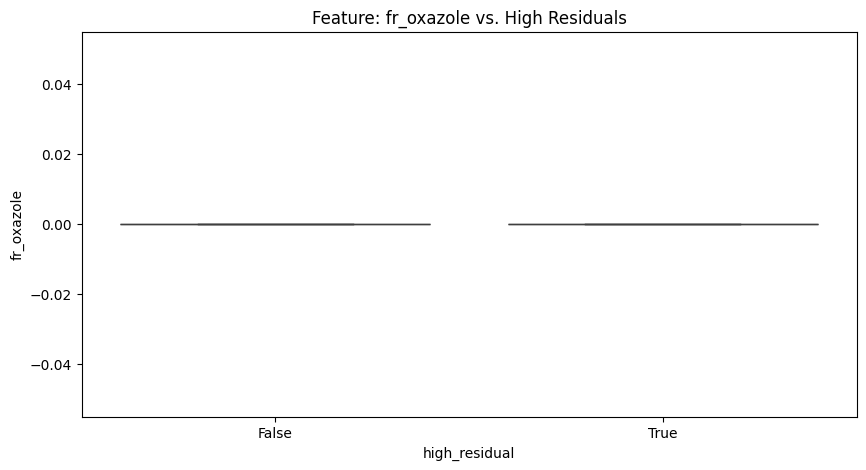

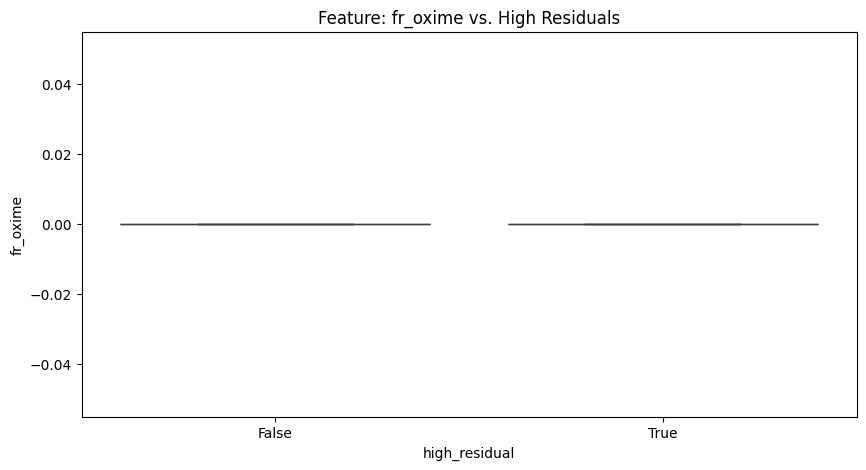

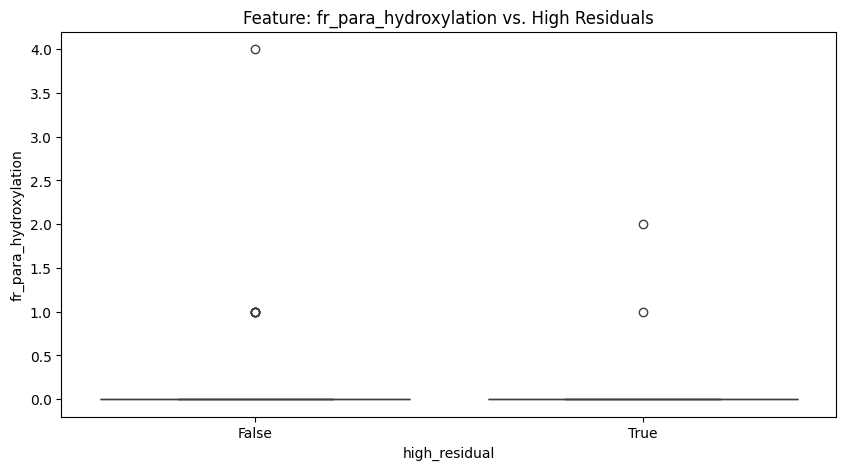

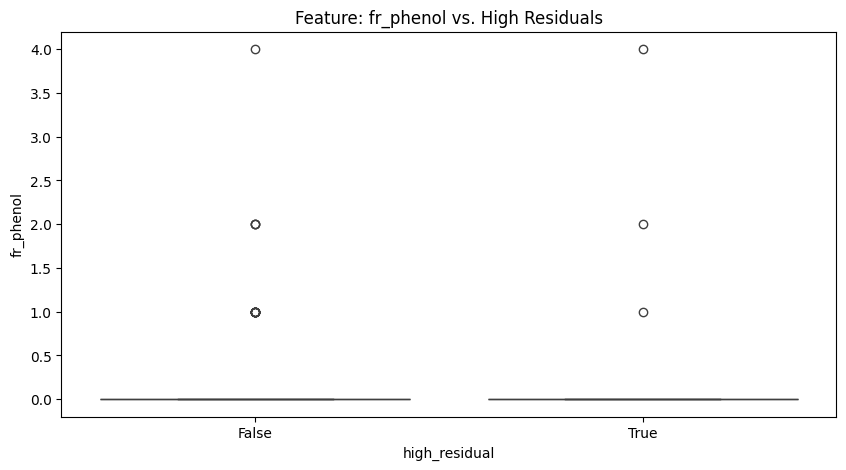

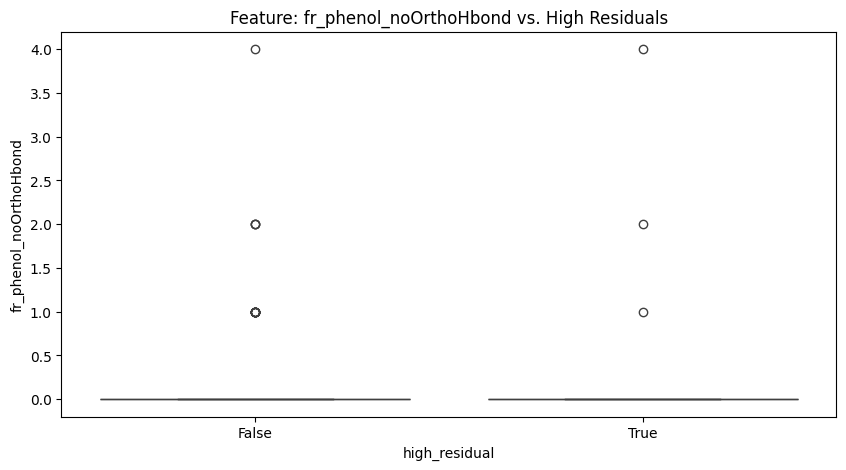

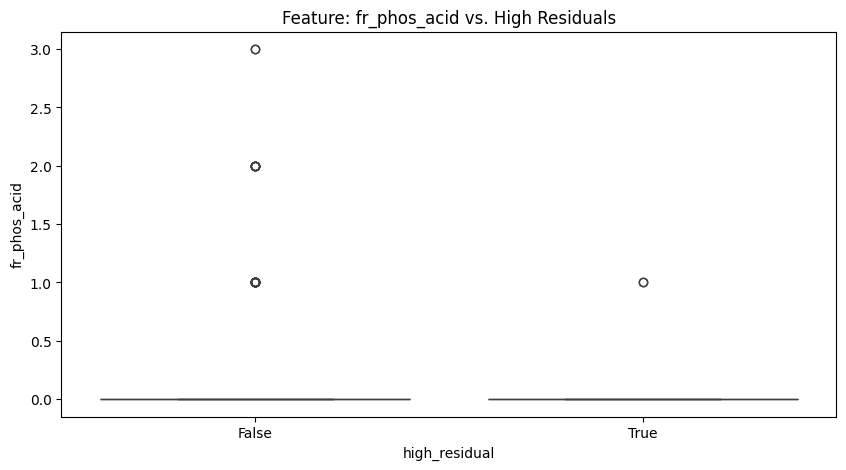

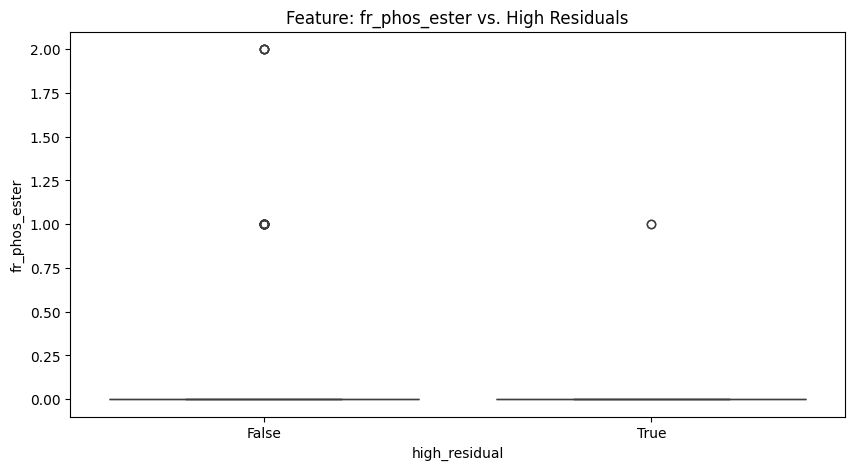

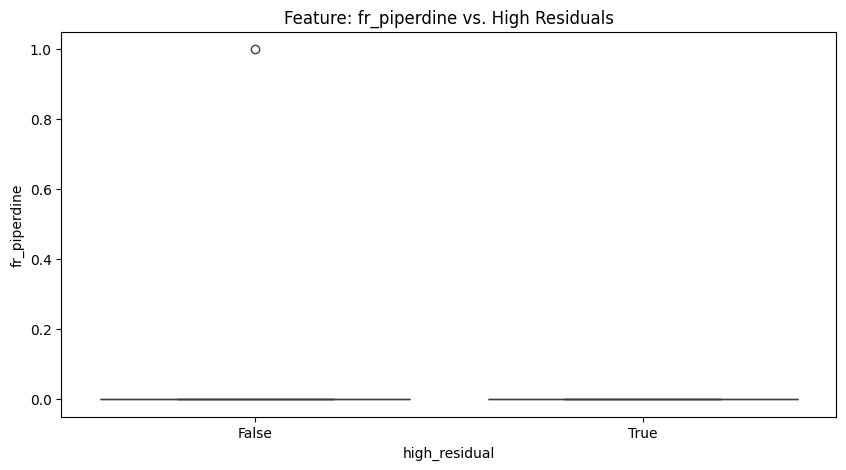

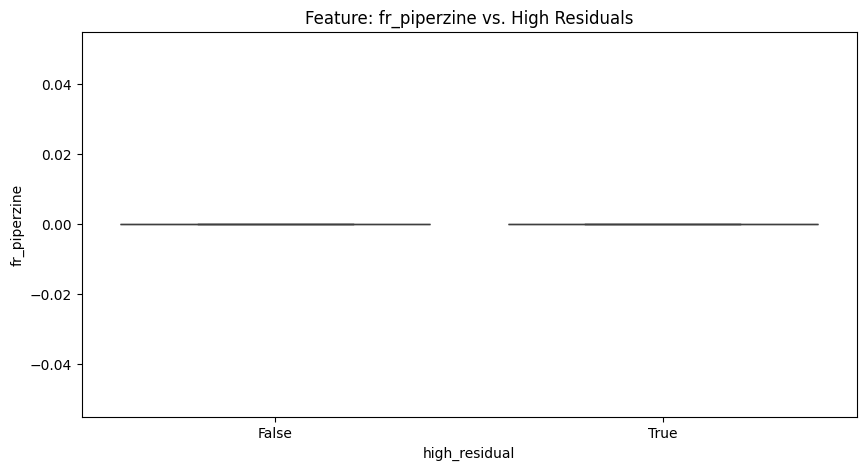

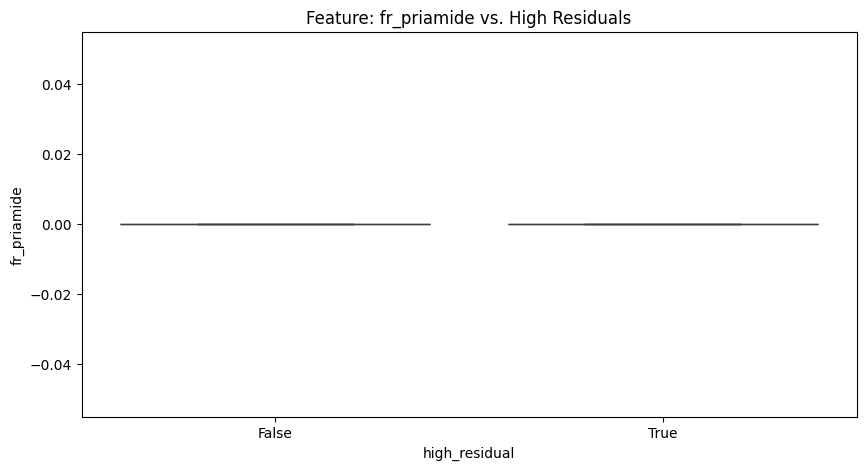

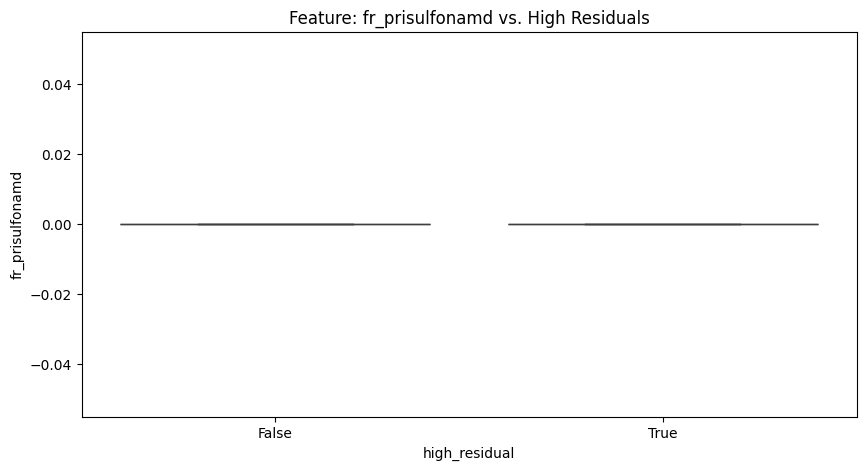

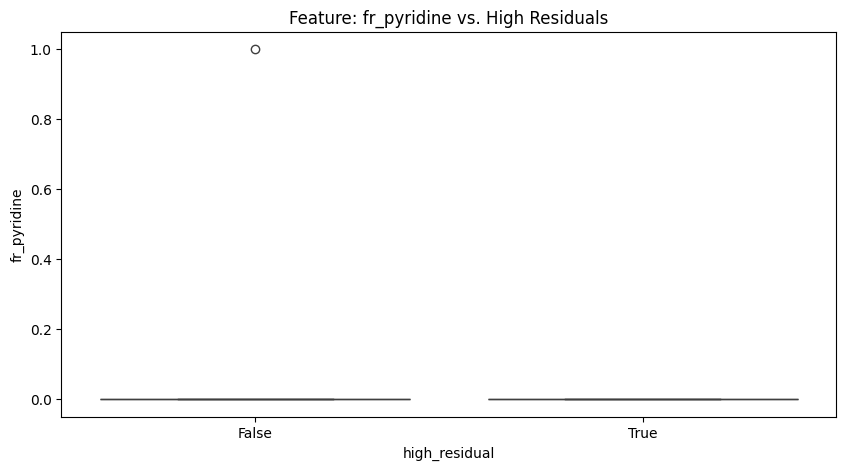

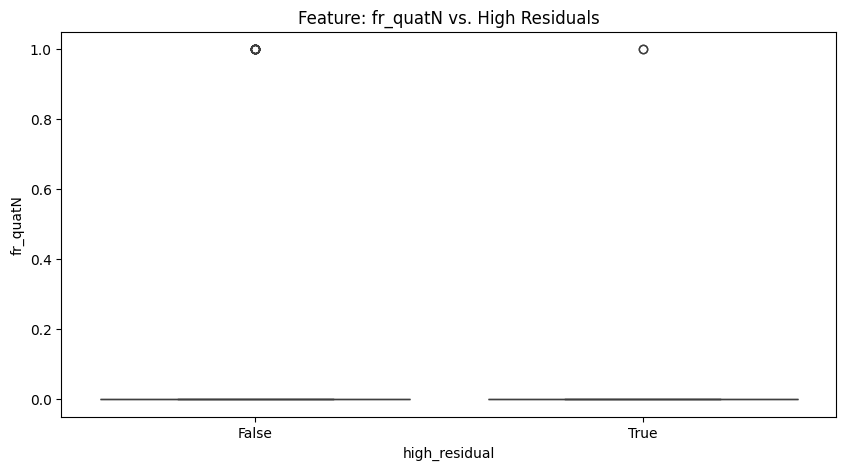

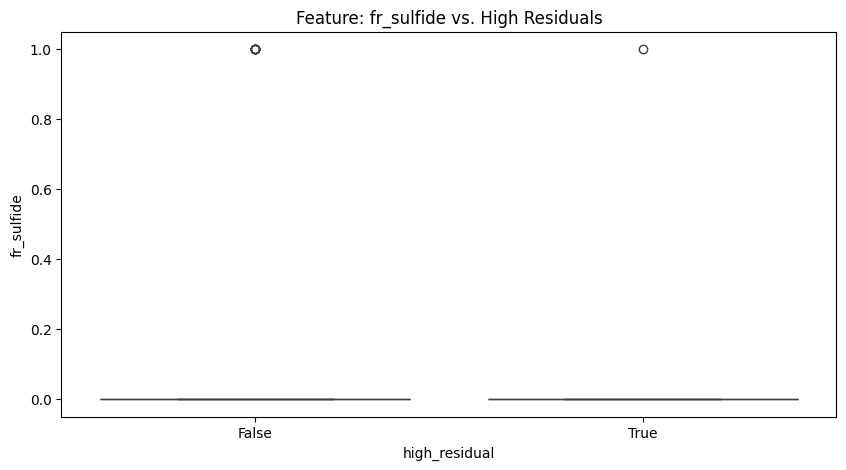

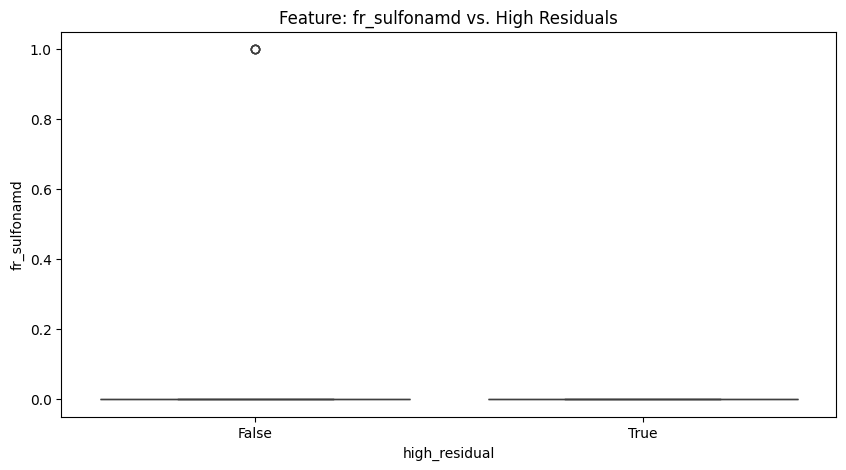

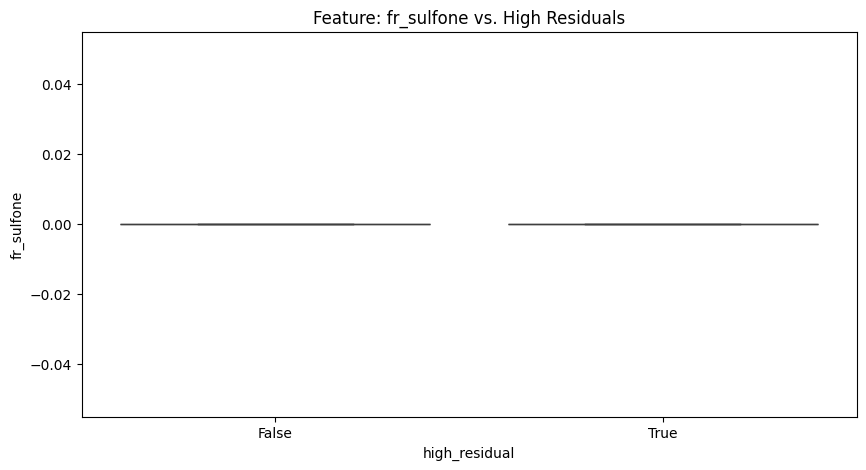

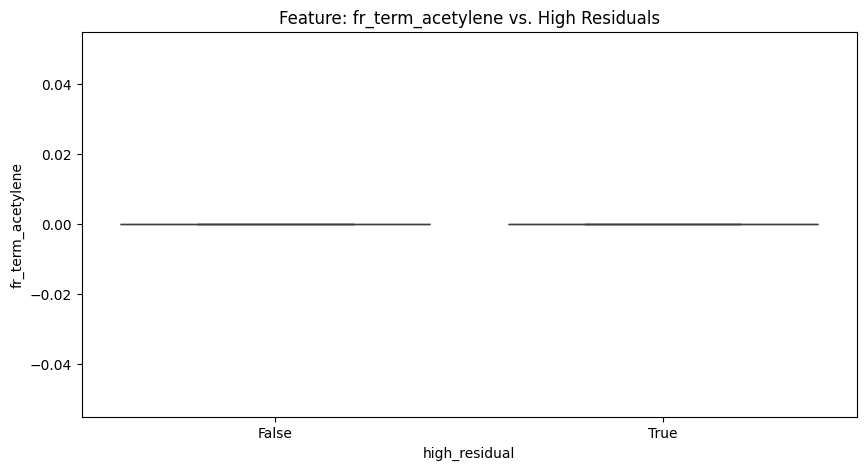

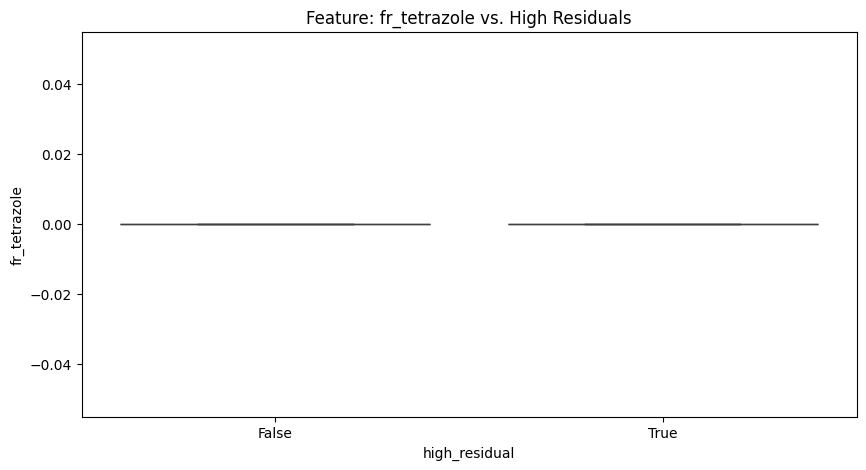

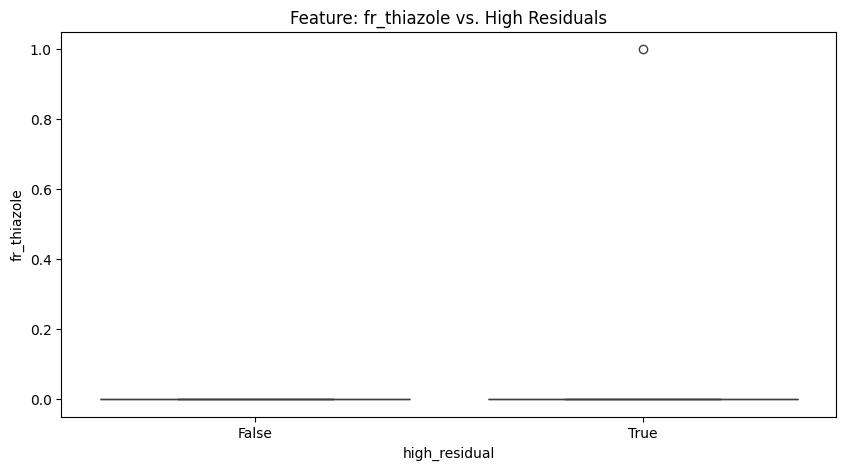

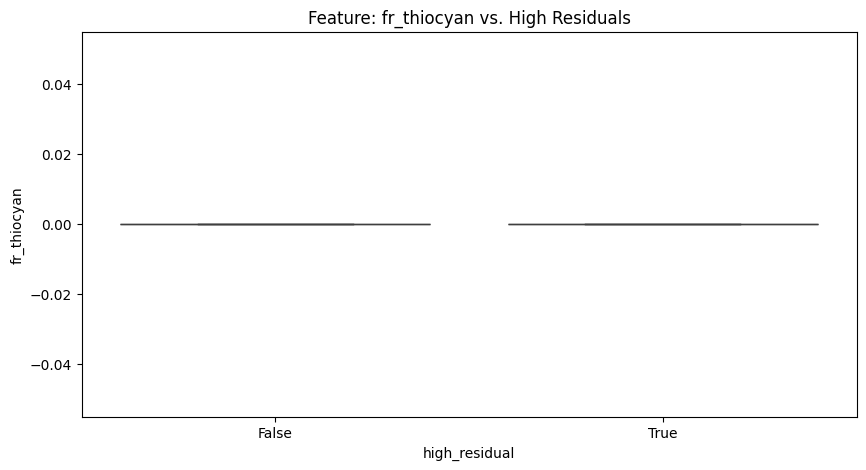

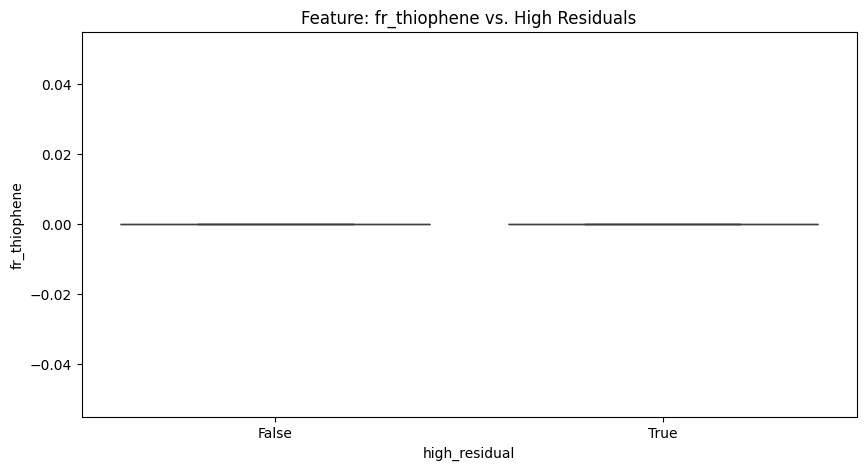

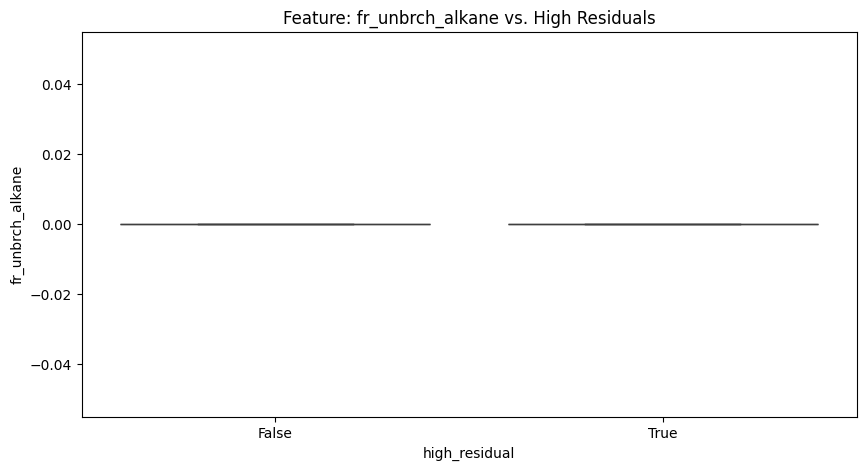

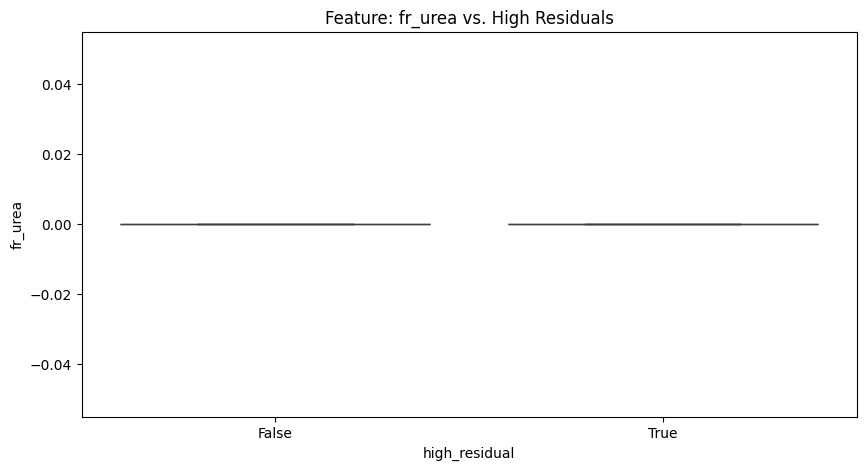

FpDensityMorgan3   0.20
FpDensityMorgan2   0.18
VSA_EState7        0.16
EState_VSA4        0.16
FpDensityMorgan1   0.16
                   ... 
fr_tetrazole        NaN
fr_thiocyan         NaN
fr_thiophene        NaN
fr_unbrch_alkane    NaN
fr_urea             NaN
Length: 210, dtype: float64


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Assuming you already have y_valid (true values) and y_preds (predictions)

# Calculate residuals
residuals = y_valid - y_preds

# Define a threshold for high residuals (e.g., top 10%)
threshold = np.percentile(np.abs(residuals), 90)
high_residuals = np.abs(residuals) > threshold

# Assuming 'data' is your full validation DataFrame with features and predictions
# You should have the features in 'data' and the columns should include 'true_values' and 'predicted_values'
data['residuals'] = residuals
data['high_residual'] = high_residuals

# Extract feature columns (excluding 'true_values' and 'predicted_values')
feature_columns = [col for col in data.columns if col not in ['true_values', 'predicted_values', 'residuals', 'high_residual']]

# Compare features
for feature in feature_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='high_residual', y=feature, data=data)
    plt.title(f'Feature: {feature} vs. High Residuals')
    plt.show()

# Correlation with residuals (calculating correlation for each feature)
correlations = data[feature_columns].corrwith(data['residuals'])
print(correlations.sort_values(ascending=False))


In [29]:
# Calculate correlation of each feature with the residuals
correlations = data[feature_columns].corrwith(data['residuals'])

# Sort the correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

# Display the sorted correlations
print(sorted_correlations)


FpDensityMorgan3   0.20
FpDensityMorgan2   0.18
VSA_EState7        0.16
EState_VSA4        0.16
FpDensityMorgan1   0.16
                   ... 
fr_tetrazole        NaN
fr_thiocyan         NaN
fr_thiophene        NaN
fr_unbrch_alkane    NaN
fr_urea             NaN
Length: 210, dtype: float64


In [30]:
# Calculate correlation of each feature with the residuals
correlations = data[feature_columns].corrwith(data['residuals'])

# Sort the correlations in descending order
sorted_correlations = correlations.sort_values(ascending=False)

# Save the sorted correlations to a CSV file
sorted_correlations.to_csv('feature_residual_correlations.csv', header=True)

print("Correlations saved to 'feature_residual_correlations.csv'")


Correlations saved to 'feature_residual_correlations.csv'


In [128]:
y_train.shape

(1774,)

In [130]:
import numpy as np

# Check for infinity values in x_train
print(np.any(np.isinf(x_train)))  # Should return False if no infinity values
print(np.any(np.isnan(x_train)))  # Should return False if no NaN values

# Check for values that are too large
print(np.max(np.abs(x_train)))  # Check the max value in the dataset


False
False
1.1798056185401215e+46


In [132]:
# Replace infinity values with NaN
x_train = np.where(np.isinf(x_train), np.nan, x_train)
# Convert back to DataFrame for easier handling if it's not already
import pandas as pd
x_train_df = pd.DataFrame(x_train)

# Drop rows with NaN or infinite values
x_train_cleaned = x_train_df.dropna()

# If you want to fill NaNs with the mean of each column:
# x_train_cleaned = x_train_df.fillna(x_train_df.mean())

# After replacing inf with NaN, you can handle NaN values as before (e.g., drop or fill with a default value).

In [133]:
# Ensure no inf or NaN values are present
print(np.any(np.isinf(x_train_cleaned)))  # Should return False
print(np.any(np.isnan(x_train_cleaned)))  # Should return False


False
False


In [135]:
x_train_cleaned

0     1    2     3    4     5      6      7      8      9    ...  200  \
0     7.72  7.72 0.55 -3.24 0.64 28.30 137.18 126.09 137.08  54.00  ... 0.00   
1     8.08  8.08 0.06 -0.15 0.30 13.58 643.59 639.56 637.54 100.00  ... 0.00   
2    11.89 11.89 2.48 -5.14 0.32 69.44 354.49 320.22 354.24 144.00  ... 0.00   
3    12.25 12.25 0.20 -3.56 0.78 25.73 203.24 190.14 203.09  78.00  ... 0.00   
4     8.79  8.79 0.11 -3.79 0.69 56.70 297.34 282.22 297.09 108.00  ... 1.00   
...    ...   ...  ...   ...  ...   ...    ...    ...    ...    ...  ...  ...   
1769 13.16 13.16 0.63 -1.16 0.63 17.20 270.24 260.16 270.05 100.00  ... 0.00   
1770 11.35 11.35 2.17 -5.22 0.30 33.83 200.08 191.01 200.01  72.00  ... 0.00   
1771 11.79 11.79 2.56 -5.31 0.30 49.71 298.51 260.21 298.29 126.00  ... 0.00   
1772 12.35 12.35 0.18 -5.67 0.34 54.57 323.20 309.09 323.05 118.00  ... 0.00   
1773  8.00  8.00 0.27 -3.27 0.65 26.23 176.22 164.12 176.09  68.00  ... 0.00   

      201  202  203  204  205  206  207  208  209  
0    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
1    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
2    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
3    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
4    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  
1769 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
1770 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
1771 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
1772 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  
1773 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  

[1774 rows x 210 columns]

In [134]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the regressor
gbr = GradientBoostingRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4, 5],             # Maximum depth of individual regression estimators
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples required to be at a leaf node
    'subsample': [0.8, 1.0],            # Fraction of samples used for fitting individual trees
    'max_features': ['sqrt', 'log2', None],  # Number of features considered for split
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use appropriate scoring (e.g., R2, neg_mean_squared_error)
    cv=5,                             # Cross-validation folds
    verbose=1,
    n_jobs=-1                         # Use all available cores
)

# Perform the search
grid_search.fit(x_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Use the best model to make predictions or evaluate further


Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


KeyboardInterrupt: 

In [124]:
y_train.shape

(1774,)

In [125]:
x_train.shape

(1774, 210)

# Features selections based on variance

In [64]:
from sklearn.feature_selection import VarianceThreshold

# Assume `data` is your dataset (DataFrame or numpy array)
selector = VarianceThreshold(threshold=0.1)  # Set a variance threshold
filtered_data = selector.fit_transform(df_descriptors)

# Get the column names that were retained
selected_columns = df_descriptors.columns[selector.get_support()]

# Create a new DataFrame with the retained columns
df_descriptors_variance_filtered = pd.DataFrame(filtered_data, columns=selected_columns)

# Save to a new .csv file
df_descriptors_variance_filtered.to_csv("df_descriptors_Variance_filtered.csv", index=False)


In [65]:
df_descriptors_variance_filtered

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0                 13.92           13.92               0.12           -6.94   
1                 13.92           13.92               0.12           -6.94   
2                 13.92           13.92               0.12           -6.94   
3                 13.92           13.92               0.12           -6.94   
4                 14.10           14.10               0.33           -7.12   
...                 ...             ...                ...             ...   
1987               7.83            7.83               0.01           -3.53   
1988               8.23            8.23               0.15           -4.04   
1989               8.40            8.40               0.47           -3.66   
1990              10.69           10.69               0.10           -2.97   
1991              10.69           10.69               0.10           -2.97   

       SPS  MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0    54.55 665.42          638.21      665.10               240.00   
1    54.55 665.42          638.21      665.10               240.00   
2    54.55 665.42          638.21      665.10               240.00   
3    54.55 665.42          638.21      665.10               240.00   
4    55.50 745.43          715.19      745.09               266.00   
...    ...    ...             ...         ...                  ...   
1987 33.21 215.69          201.58      215.09                78.00   
1988 35.25 241.36          222.21      241.14                90.00   
1989 65.33 162.24          148.12      162.12                64.00   
1990 20.60 137.14          130.08      137.05                52.00   
1991 20.60 137.14          130.08      137.05                52.00   

      FpDensityMorgan1  ...  fr_ester  fr_ether  fr_halogen  fr_imidazole  \
0                 1.11  ...      0.00      2.00        0.00          1.00   
1                 1.11  ...      0.00      2.00        0.00          1.00   
2                 1.11  ...      0.00      2.00        0.00          1.00   
3                 1.11  ...      0.00      2.00        0.00          1.00   
4                 1.12  ...      0.00      2.00        0.00          1.00   
...                ...  ...       ...       ...         ...           ...   
1987              1.79  ...      0.00      0.00        1.00          0.00   
1988              1.69  ...      0.00      0.00        0.00          0.00   
1989              1.83  ...      0.00      0.00        0.00          0.00   
1990              2.00  ...      0.00      0.00        0.00          0.00   
1991              2.00  ...      0.00      0.00        0.00          0.00   

      fr_ketone  fr_methoxy  fr_phenol  fr_phenol_noOrthoHbond  fr_phos_acid  \
0          0.00        0.00       0.00                    0.00          2.00   
1          0.00        0.00       0.00                    0.00          2.00   
2          0.00        0.00       0.00                    0.00          2.00   
3          0.00        0.00       0.00                    0.00          2.00   
4          0.00        0.00       0.00                    0.00          3.00   
...         ...         ...        ...                     ...           ...   
1987       0.00        0.00       0.00                    0.00          0.00   
1988       0.00        0.00       0.00                    0.00          0.00   
1989       0.00        0.00       0.00                    0.00          0.00   
1990       0.00        0.00       0.00                    0.00          0.00   
1991       0.00        0.00       0.00                    0.00          0.00   

      fr_phos_ester  
0              2.00  
1              2.00  
2              2.00  
3              2.00  
4              3.00  
...             ...  
1987           0.00  
1988           0.00  
1989           0.00  
1990           0.00  
1991           0.00  

[1992 rows x 142 columns]

In [70]:
x_train_variance_filtered, x_valid_variance_filtered, y_train_variance_filtered, y_valid_variance_filtered = train_test_split(df_descriptors_variance_filtered, data_cleaned_final.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_variance_filtered)
x_train_scaled_variance_filtered = scaler.transform(x_train_variance_filtered)
x_valid_scaled_variance_filtered = scaler.transform(x_valid_variance_filtered)

In [71]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled_variance_filtered, x_valid_scaled_variance_filtered, y_train_variance_filtered, y_valid_variance_filtered)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:18<00:00,  2.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16401
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 139
[LightGBM] [Info] Start training from score 167.908594


In [72]:
prediction_tests[:5]

Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
GradientBoostingRegressor                    0.68       0.91  9.61        2.10
ExtraTreesRegressor                          0.68       0.91  9.66        2.27
LGBMRegressor                                0.67       0.91  9.77        0.20
HistGradientBoostingRegressor                0.67       0.90  9.79        0.45
RandomForestRegressor                        0.66       0.90  9.85        5.19

# Filter Features Based on Correlation

In [83]:
# Compute the correlation matrix
correlation_matrix = df_descriptors.corr().abs()

# Select upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find index of features with high correlation (e.g., >0.9)
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop highly correlated features
df_descriptors_correlation_filtered = df_descriptors.drop(columns=to_drop)
print(f"Removed features: {to_drop}")

Removed features: ['MaxEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'Kappa3', 'LabuteASA', 'SMR_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA2', 'SlogP_VSA6', 'EState_VSA1', 'VSA_EState1', 'VSA_EState7', 'HeavyAtomCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolMR', 'fr_Ar_N', 'fr_COO', 'fr_COO2', 'fr_Imine', 'fr_Nhpyrrole', 'fr_alkyl_halide', 'fr_benzene', 'fr_halogen', 'fr_nitro_arom', 'fr_phenol_noOrthoHbond', 'fr_phos_ester']


In [86]:
x_train_correlation_filtered, x_valid_correlation_filtered, y_train_correlation_filtered, y_valid_correlation_filtered = train_test_split(df_descriptors_correlation_filtered, data_cleaned_final.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_correlation_filtered)
x_train_scaled_correlation_filtered = scaler.transform(x_train_correlation_filtered)
x_valid_scaled_correlation_filtered = scaler.transform(x_valid_correlation_filtered)

In [87]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled_correlation_filtered, x_valid_scaled_correlation_filtered, y_train_correlation_filtered, y_valid_correlation_filtered)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:15<00:00,  2.76it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11635
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 114
[LightGBM] [Info] Start training from score 167.908594


In [88]:
prediction_tests[:5]

Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          0.55       0.91  9.52        1.80
RandomForestRegressor                        0.55       0.91  9.57        3.79
HistGradientBoostingRegressor                0.53       0.91  9.75        0.44
LGBMRegressor                                0.53       0.91  9.77        0.17
GradientBoostingRegressor                    0.52       0.90  9.81        1.49

# Dimensional Reduction --> PCA

In [137]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Assuming df_descriptors is your original dataset

# Step 1: Impute missing values using the mean strategy
imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(df_descriptors)

# Step 2: Perform PCA to reduce the number of components
pca = PCA(n_components=10)  # Adjust the number of components as needed
reduced_data = pca.fit_transform(df_imputed)

# Step 3: Convert the reduced data to a DataFrame
df_descriptors_pca = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(reduced_data.shape[1])])

# Step 4: Save the PCA DataFrame to a CSV file
df_descriptors_pca.to_csv("pca_reduced_data.csv", index=False)

print("PCA dataset saved to 'pca_reduced_data.csv'")

PCA dataset saved to 'pca_reduced_data.csv'


In [138]:
df_descriptors_pca

PC1                 PC2  \
0    -11845437942747986057352754440322691652124672.00 -298201879871154.12   
1    -11845437942747485929576883146691632405938176.00 -298201879871155.88   
2    -11845437942747485929576883146691632405938176.00 -298201879871155.88   
3    -11845437942747485929576883146691632405938176.00 -298201879871156.44   
4    -11845437942747483453696804575931082607689728.00 -304298574432103.31   
...                                               ...                 ...   
1987 -11845437942748600075612239988939041617739776.00    7037034753820.39   
1988 -11845437942748736249016561380769280521404416.00   40181739779478.52   
1989 -11845437942748627310293104267305089398472704.00   21756653158221.47   
1990 -11845437942748728821376325668487631126659072.00   45767138672381.02   
1991 -11845437942748726345496247097727081328410624.00   45767138672381.09   

         PC3     PC4    PC5    PC6    PC7   PC8   PC9   PC10  
0    -111.28  -23.50 -25.67   7.91  -2.27  0.89 -1.77  -0.73  
1    -111.28  -23.50 -25.67   7.91  -2.27  0.89 -1.77  -0.73  
2    -111.28  -23.50 -25.67   7.91  -2.27  0.89 -1.77  -0.73  
3    -111.28  -23.50 -25.67   7.91  -2.27  0.89 -1.77  -0.73  
4      93.92   60.04  -9.32  33.41   3.42 -7.56 -7.17 -15.71  
...      ...     ...    ...    ...    ...   ...   ...    ...  
1987 -291.55  -75.84 -27.51 -18.92   3.81 17.64 -0.55 -14.70  
1988   15.63  -28.84  -7.02 -14.35   3.94  9.86 -1.52 -10.83  
1989 -314.89 -139.72 -14.99 -56.87  -1.75 25.63  9.70   6.65  
1990 -445.28  -84.99 -33.19  -2.72 -16.83 -9.91  9.33   0.35  
1991 -445.28  -84.99 -33.19  -2.72 -16.83 -9.91  9.33   0.35  

[1992 rows x 10 columns]

In [177]:
x_train_pca, x_valid_pca, y_train_pca, y_valid_pca = train_test_split(df_descriptors_pca, data_cleaned_final.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_pca)
x_train_scaled_pca = scaler.transform(x_train_pca)
x_valid_scaled_pca = scaler.transform(x_valid_pca)

In [178]:
# Convert back to DataFrame for easier handling if it's not already
import pandas as pd
x_train_df = pd.DataFrame(x_train_pca)
y_train_df = pd.DataFrame(y_train_pca)

# Drop rows with NaN or infinite values
x_train_pca = x_train_df.dropna()
y_train_pca = y_train_df.dropna()

# If you want to fill NaNs with the mean of each column:
#x_train_cleaned = x_train_df.fillna(x_train_df.mean())

# After replacing inf with NaN, you can handle NaN values as before (e.g., drop or fill with a default value).

In [179]:
# Ensure no inf or NaN values are present
print(np.any(np.isinf(x_train_pca)))  # Should return False
print(np.any(np.isnan(x_train_pca)))  # Should return False

print(np.any(np.isinf(y_train_pca)))  # Should return False
print(np.any(np.isnan(y_train_pca))) 

x_train_pca.shape

False
False
False
False


(1792, 10)

In [166]:
y_train_pca.shape

(1792, 1)

In [146]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled_pca, x_valid_scaled_pca, y_train_pca, y_valid_pca)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.87it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 10
[LightGBM] [Info] Start training from score 167.908594


In [147]:
prediction_tests[:5]

Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                     
GradientBoostingRegressor                0.89       0.90 10.20        0.53
ExtraTreesRegressor                      0.89       0.89 10.31        0.43
RandomForestRegressor                    0.89       0.89 10.44        1.27
BaggingRegressor                         0.88       0.89 10.55        0.15
XGBRegressor                             0.88       0.89 10.70        0.08

In [180]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the regressor
gbr = GradientBoostingRegressor()

# Define the hyperparameter distribution (instead of grid, it's a distribution for random sampling)
param_dist = {
    'n_estimators': [50, 100, 200],      # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4, 5],             # Maximum depth of individual regression estimators
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples required to be at a leaf node
    'subsample': [0.8, 1.0],            # Fraction of samples used for fitting individual trees
    'max_features': ['sqrt', 'log2', None],  # Number of features considered for split
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,  # The parameter distribution to sample from
    n_iter=50,                       # Number of parameter settings to sample
    scoring='neg_mean_squared_error', # Use appropriate scoring (e.g., R2, neg_mean_squared_error)
    cv=5,                            # Cross-validation folds
    verbose=1,                       
    n_jobs=-1                        # Use all available cores
)

# Perform the search
random_search.fit(x_train_scaled_pca, y_train_pca)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Best model
best_model = random_search.best_estimator_

# Use the best model to make predictions or evaluate further


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.1}


In [183]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the regressor
gbr = GradientBoostingRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4, 5],             # Maximum depth of individual regression estimators
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples required to be at a leaf node
    'subsample': [0.8, 1.0],            # Fraction of samples used for fitting individual trees
    'max_features': ['sqrt', 'log2', None],  # Number of features considered for split
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use appropriate scoring (e.g., R2, neg_mean_squared_error)
    cv=5,                             # Cross-validation folds
    verbose=1,
    n_jobs=-1                         # Use all available cores
)

# Perform the search
grid_search.fit(x_train_scaled_pca, y_train_pca)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Use the best model to make predictions or evaluate further

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}


Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}


# Remove potential unusable features 

In [127]:
# Define the list of columns you want to keep
columns_to_keep = ['MolWt', 'HeavyAtomMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 
                   'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 
                   'MinAbsPartialCharge', 'FractionCSP3', 'HeavyAtomCount', 'NumRotatableBonds', 
                   'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 
                   'RingCount', 'MolLogP', 'MolMR', 'TPSA', 'NumHAcceptors', 'NumHDonors', 
                   'NumHeteroatoms', 'NumAromaticCarbocycles', 'NumAromaticRings', 
                   'NumAromaticHeterocycles', 'PEOE_VSA1', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 
                   'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'PEOE_VSA10', 
                   'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'SMR_VSA1', 'SMR_VSA2', 
                   'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 
                   'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 
                   'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9']

# Keep only the columns you want from the dataframe
df_descriptors_filtered = df_descriptors[columns_to_keep]



In [128]:
df_descriptors_filtered

MolWt  HeavyAtomMolWt  NumValenceElectrons  NumRadicalElectrons  \
0    665.42          638.21                  240                    0   
1    665.42          638.21                  240                    0   
2    665.42          638.21                  240                    0   
3    665.42          638.21                  240                    0   
4    745.43          715.19                  266                    0   
...     ...             ...                  ...                  ...   
1987 215.69          201.58                   78                    0   
1988 241.36          222.21                   90                    0   
1989 162.24          148.12                   64                    0   
1990 137.14          130.08                   52                    0   
1991 137.14          130.08                   52                    0   

      MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  \
0                 0.48             -0.49                 0.49   
1                 0.48             -0.49                 0.49   
2                 0.48             -0.49                 0.49   
3                 0.48             -0.49                 0.49   
4                 0.48             -0.49                 0.49   
...                ...               ...                  ...   
1987              0.23             -0.30                 0.30   
1988              0.25             -0.35                 0.35   
1989              0.12             -0.31                 0.31   
1990              0.18             -0.54                 0.54   
1991              0.18             -0.54                 0.54   

      MinAbsPartialCharge  FractionCSP3  HeavyAtomCount  ...  SMR_VSA9  \
0                    0.48          0.48              44  ...      5.88   
1                    0.48          0.48              44  ...      5.88   
2                    0.48          0.48              44  ...      5.88   
3                    0.48          0.48              44  ...      5.88   
4                    0.48          0.52              48  ...      0.00   
...                   ...           ...             ...  ...       ...   
1987                 0.23          0.62              14  ...      0.00   
1988                 0.25          0.70              16  ...      0.00   
1989                 0.12          0.50              12  ...      0.00   
1990                 0.18          0.14              10  ...      0.00   
1991                 0.18          0.14              10  ...      0.00   

      SlogP_VSA1  SlogP_VSA2  SlogP_VSA3  SlogP_VSA4  SlogP_VSA5  SlogP_VSA6  \
0           4.57      125.48       31.96        5.40       42.65       37.04   
1           4.57      125.48       31.96        5.40       42.65       37.04   
2           4.57      125.48       31.96        5.40       42.65       37.04   
3           4.57      125.48       31.96        5.40       42.65       37.04   
4           5.72      136.16       41.05        5.40       38.62       36.58   
...          ...         ...         ...         ...         ...         ...   
1987       11.24       27.45        0.00        0.00       37.00        9.98   
1988       10.93       33.16        0.00        0.00       50.71       10.15   
1989        5.31       11.48        0.00        0.00       48.52       24.43   
1990        9.67        5.97        6.98        0.00       19.95       24.43   
1991        9.67        5.97        6.98        0.00       19.95       24.43   

      SlogP_VSA7  SlogP_VSA8  SlogP_VSA9  
0           1.41       12.60        0.00  
1           1.41       12.60        0.00  
2           1.41       12.60        0.00  
3           1.41       12.60        0.00  
4           4.24       12.60        0.00  
...          ...         ...         ...  
1987        8.11        0.00        0.00  
1988        2.82        0.00        0.00  
1989        1.41        0.00        0.00  
1990        0.00        0.00        0.00  
1991        0.00        0

In [129]:
x_train_filtered, x_valid_filtered, y_train_filtered, y_valid_filtered = train_test_split(df_descriptors_filtered, data_cleaned_final.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_filtered)
x_train_scaled_filtered = scaler.transform(x_train_filtered)
x_valid_scaled_filtered = scaler.transform(x_valid_filtered)

In [130]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled_filtered, x_valid_scaled_filtered, y_train_filtered, y_valid_filtered)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:11<00:00,  3.66it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5810
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 53
[LightGBM] [Info] Start training from score 167.908594


In [131]:
prediction_tests[:5]

Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                     
GradientBoostingRegressor                0.87       0.91  9.63        0.90
ExtraTreesRegressor                      0.87       0.91  9.69        1.17
XGBRegressor                             0.87       0.91  9.76        0.14
LGBMRegressor                            0.87       0.91  9.78        0.10
RandomForestRegressor                    0.87       0.90  9.79        2.70

# PCA data tests

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 1100}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 900}

Optimized parameters for a LightGBM regressor can be:  {'learning_rate': 0.015, 'max_depth': 6, 'n_estimators': 800}

In [187]:
model = LGBMRegressor(n_estimators = 750,
                      max_depth = 6,
                      learning_rate = 0.015,
                      random_state= 42)

model.fit(x_train_scaled_pca,y_train_pca)
y_preds_pca = model.predict(x_valid_scaled_pca)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 10
[LightGBM] [Info] Start training from score 167.908594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

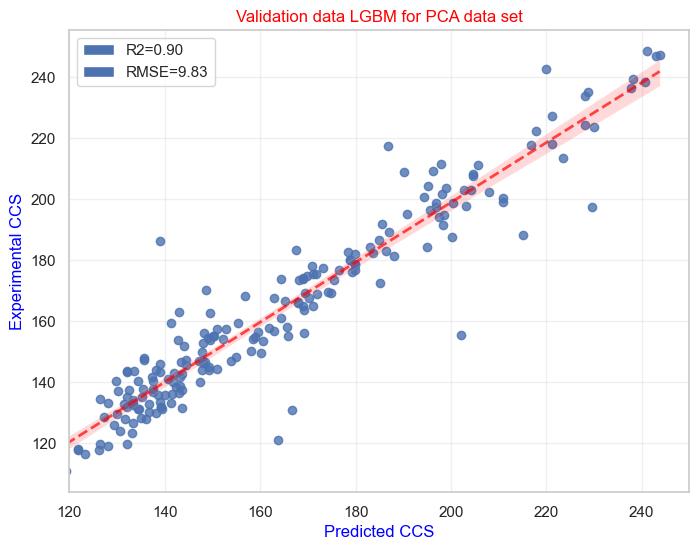

In [148]:
plot_data(y_valid_pca, y_preds_pca, "Validation data LGBM for PCA data set")

plt.savefig('data_LGBM.png')

data_to_save = pd.DataFrame({'True Values': y_valid_pca, 'Predicted Values': y_preds_pca})
data_to_save.to_csv('data_LGBM.csv', index=False)

In [191]:
from sklearn.ensemble import GradientBoostingRegressor
from math import log  # Importing log function from math module

# Define the model with the correct parameters
model_GBR = GradientBoostingRegressor(
    learning_rate = 0.1, 
    max_depth = 5, 
    max_features = log(2),  # Correct use of log function
    min_samples_leaf = 1, 
    min_samples_split = 5, 
    n_estimators = 100, 
    subsample = 1.0
)

# Fit the model with training data
model_GBR.fit(x_train_scaled_pca, y_train_pca)

# Predict on validation set
y_preds_GBR_pca = model_GBR.predict(x_valid_scaled_pca)


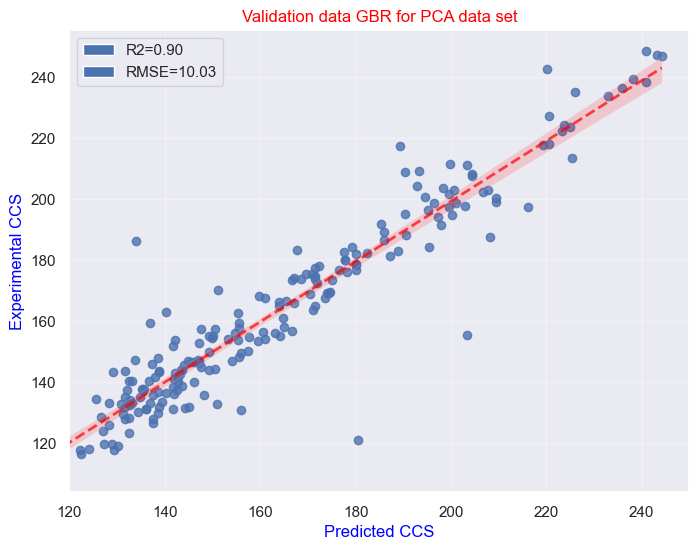

In [201]:
plot_data(y_valid_pca, y_preds_GBR_pca, "Validation data GBR for PCA data set")

In [197]:
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
import numpy as np

# Define the LGBM model (LightGBM)
model1 = LGBMRegressor(n_estimators=750,
                       max_depth=6,
                       num_leaves=64,  # Corrected based on max_depth
                       learning_rate=0.015,
                       random_state=42)

# Define the XGBoost model (XGBRegressor)
model2 = XGBRegressor(learning_rate=0.1, 
                      max_depth=5, 
                      min_samples_leaf=1, 
                      min_samples_split=5, 
                      n_estimators=100, 
                      subsample=1.0,
                      colsample_bytree=0.8,  # Instead of max_features
                      random_state=42)

# Define the Voting Regressor combining both models
voting_model = VotingRegressor(estimators=[
    ('lgbm', model1), 
    ('xgb', model2)
])

# Fit the model on training data
voting_model.fit(x_train_scaled_pca, y_train_pca)

# Make predictions on validation data
predictions = voting_model.predict(x_valid_scaled_pca)




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 10
[LightGBM] [Info] Start training from score 167.908594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

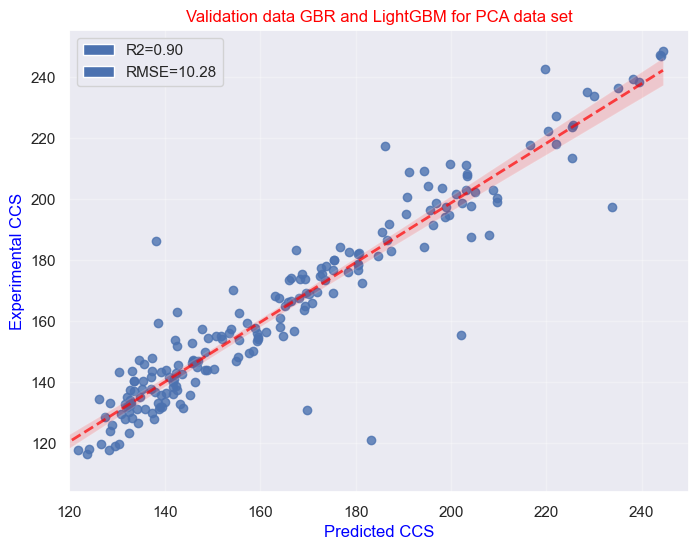

In [202]:
plot_data(y_valid_pca, predictions,  "Validation data GBR and LightGBM for PCA data set")

# test on reduced data set (90<CCS<170)

In [15]:
reduced_data_set = df[df.CCS.apply(lambda x: x > 120.0 and x < 170.0)]

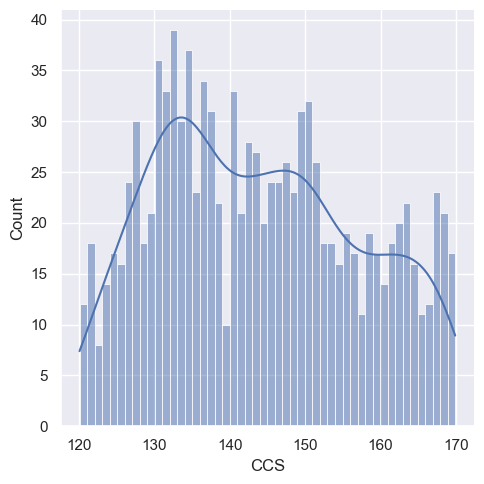

In [16]:
sn.displot(data=reduced_data_set, x="CCS", binwidth=1, kde=True)

In [17]:
reduced_data_set.to_csv('reduced_data_CCS.csv', index=False)

In [18]:
reduced_data = pd.read_csv("reduced_data_CCS.csv", delimiter=',')
Mol_descriptors_test , desc_names_test = RDkit_descriptors(reduced_data["SMILES"])
reduced_data_descriptors = pd.DataFrame(Mol_descriptors_test,columns=desc_names_test)

100%|█████████████████████████████████████████████████████████████████████████████| 1097/1097 [00:10<00:00, 101.06it/s]


In [19]:
x_train_reduced, x_valid_reduced, y_train_reduced, y_valid_reduced = train_test_split(reduced_data_descriptors, reduced_data_set.CCS, test_size=0.1,random_state=42)

scaler = StandardScaler()
scaler.fit(x_train_reduced)
x_train_scaled_reduced = scaler.transform(x_train_reduced)
x_valid_scaled_reduced = scaler.transform(x_valid_reduced)

In [25]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
model, prediction_tests = lregs.fit(x_train_scaled_reduced, x_valid_scaled_reduced, y_train_reduced, y_valid_reduced)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:24<00:00,  1.69it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16655
[LightGBM] [Info] Number of data points in the train set: 987, number of used features: 158
[LightGBM] [Info] Start training from score 143.896788


In [22]:
prediction_tests[:1000]

Adjusted R-Squared  \
Model                                                                              
Lars                          51390136337795432582573094581385570380114071456...   
RANSACRegressor                                         986611951718834110464.00   
KernelRidge                                                               147.92   
GaussianProcessRegressor                                                   34.48   
MLPRegressor                                                                2.65   
DummyRegressor                                                              2.08   
QuantileRegressor                                                           2.08   
PassiveAggressiveRegressor                                                  1.53   
KNeighborsRegressor                                                         1.39   
LarsCV                                                                      1.37   
NuSVR                                                                       1.30   
Lasso                                                                       1.29   
LassoLars                                                                   1.29   
AdaBoostRegressor                                                           1.28   
SVR                                                                         1.28   
OrthogonalMatchingPursuitCV                                                 1.28   
ExtraTreeRegressor                                                          1.28   
ElasticNet                                                                  1.27   
XGBRegressor                                                                1.26   
TransformedTargetRegressor                                                  1.26   
LinearRegression                                                            1.26   
ExtraTreesRegressor                                                         1.26   
GradientBoostingRegressor                                                   1.26   
DecisionTreeRegressor                                                       1.26   
OrthogonalMatchingPursuit                                                   1.26   
GammaRegressor                                                              1.25   
SGDRegressor                                                                1.25   
HistGradientBoostingRegressor                                               1.25   
Ridge                                                                       1.25   
LGBMRegressor                                                               1.25   
TweedieRegressor                                                            1.25   
PoissonRegressor                                                            1.25   
RandomForestRegressor                                                       1.24   
BaggingRegressor                                                            1.24   
RidgeCV                                                                     1.24   
LinearSVR                                                                   1.24   
ElasticNetCV                                                                1.24   
BayesianRidge                                                               1.23   
HuberRegressor                                                              1.23   
LassoCV                                                                     1.23   
LassoLarsIC                                                                 1.23   
LassoLarsCV                                                                 1.23   

                                                                       R-Squared  \
Model                                                                              
Lars                          -4761838321208567266617126002512747119486191129...   
RANSACRegressor                                        -914200065354149003264.00   
KernelRidge                  

In [32]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor  # Or the model of your choice
from sklearn.metrics import mean_squared_error
import numpy as np

def randomized_search_optimization(data_descriptors, target, param_distributions, n_iter=100):
    # Step 1: Split the data
    x_train_reduced, x_valid_reduced, y_train_reduced, y_valid_reduced = train_test_split(
        data_descriptors, target, test_size=0.1, random_state=42
    )

    # Step 2: Scale the data
    scaler = StandardScaler()
    scaler.fit(x_train_reduced)
    x_train_scaled_reduced = scaler.transform(x_train_reduced)
    x_valid_scaled_reduced = scaler.transform(x_valid_reduced)

    # Step 3: Initialize the model
    model = RandomForestRegressor(random_state=42)

    # Step 4: Perform Randomized Search
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,  # Number of parameter settings to try
        scoring='neg_mean_squared_error',  # Replace with appropriate metric for your task
        cv=5,  # Cross-validation folds
        verbose=2,
        random_state=42,
        n_jobs=-1  # Use all cores
    )

    random_search.fit(x_train_scaled_reduced, y_train_reduced)

    # Step 5: Evaluate the best model on the validation set
    best_model = random_search.best_estimator_
    y_valid_pred = best_model.predict(x_valid_scaled_reduced)
    validation_score = mean_squared_error(y_valid_reduced, y_valid_pred)

    
    return random_search.best_params_, validation_score



In [28]:
param_distributions = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

best_params, validation_score = randomized_search_optimization(
    reduced_data_descriptors,
    reduced_data_set.CCS,
    param_distributions,
    n_iter=50  # Testing 50 parameter combinations
)

print("Best Parameters:", best_params)
print("Validation MSE:", validation_score)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': True}
Validation MSE: 33.8785547444244


In [33]:
param_distributions = {
    'n_estimators': [300, 400, 500, 600, 700],
    'max_depth': [4, 6, 8, 10, 12, 14],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [5, 3, 4],
    'bootstrap': [True, False]
}

best_params, validation_score = randomized_search_optimization(
    reduced_data_descriptors,
    reduced_data_set.CCS,
    param_distributions,
    n_iter=50  # Testing 50 parameter combinations
)

print("Best Parameters:", best_params)
print("Validation MSE:", validation_score)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 600, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 6, 'bootstrap': True}
Validation MSE: 32.58241583819688


In [34]:
param_distributions = {
    'n_estimators': [540, 570, 600, 630, 660],
    'max_depth': [5, 6, 7, 8, 4],
    'min_samples_split': [2, 4, 3],
    'min_samples_leaf': [2, 3, 4],
    'bootstrap': [True, False]
}

best_params, validation_score = randomized_search_optimization(
    reduced_data_descriptors,
    reduced_data_set.CCS,
    param_distributions,
    n_iter=50  # Testing 50 parameter combinations
)

print("Best Parameters:", best_params)
print("Validation MSE:", validation_score)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 660, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 5, 'bootstrap': True}
Validation MSE: 33.73902403800947


In [60]:
model = LGBMRegressor(n_estimators = 600,
                      max_depth = 5,
                      learning_rate = 0.01,
                      random_state= 42,
                      min_samples_split= 4,
                      min_samples_leaf= 4,
                      bootstrap= True)

model.fit(x_train_scaled_reduced,y_train_reduced)
y_preds_reduced = model.predict(x_valid_scaled_reduced)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=4. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16692
[LightGBM] [Info] Number of dat

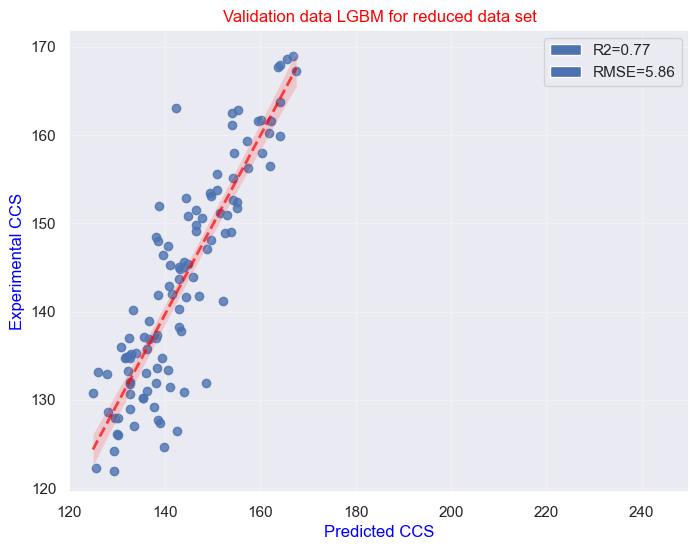

In [61]:
plot_data(y_valid_reduced, y_preds_reduced, "Validation data LGBM for reduced data set")

# Reduced data set in function of residuals correlation

In [37]:
# Filter the correlations to keep only those between -0.07 and 0.07
filtered_features = sorted_correlations[(sorted_correlations > -0.07) & (sorted_correlations < 0.07)]

# Display the features that are kept
print("Filtered features with correlation between -0.07 and 0.07:", filtered_features.index.tolist())

# Select only the filtered features from your data for predictions
filtered_data = df_descriptors[filtered_features.index.tolist()]

# Now you can use 'filtered_data' for your predictions or model training


Filtered features with correlation between -0.07 and 0.07: ['SMR_VSA2', 'fr_Al_OH', 'BCUT2D_MWHI', 'NumSaturatedRings', 'PEOE_VSA3', 'VSA_EState8', 'EState_VSA11', 'NumAliphaticCarbocycles', 'fr_sulfide', 'MinEStateIndex', 'HallKierAlpha', 'fr_para_hydroxylation', 'SlogP_VSA12', 'NumSaturatedCarbocycles', 'BCUT2D_MRHI', 'NumAliphaticHeterocycles', 'fr_NH2', 'fr_Ar_N', 'EState_VSA8', 'fr_Al_OH_noTert', 'BCUT2D_MRLOW', 'RingCount', 'SlogP_VSA4', 'fr_NH0', 'BCUT2D_CHGHI', 'fr_Imine', 'fr_Ndealkylation2', 'NumSaturatedHeterocycles', 'fr_ArN', 'SMR_VSA3', 'VSA_EState6', 'fr_Ar_OH', 'BCUT2D_LOGPHI', 'PEOE_VSA11', 'PEOE_VSA10', 'fr_Ar_COO', 'fr_Nhpyrrole', 'fr_Ar_NH', 'fr_halogen', 'Chi4v', 'VSA_EState5', 'fr_ketone', 'VSA_EState3', 'PEOE_VSA4', 'SlogP_VSA10', 'fr_alkyl_halide', 'SlogP_VSA2', 'fr_NH1', 'fr_phenol_noOrthoHbond', 'fr_phenol', 'NumAromaticHeterocycles', 'fr_imidazole', 'fr_sulfonamd', 'FractionCSP3', 'VSA_EState4', 'PEOE_VSA12', 'BalabanJ', 'VSA_EState10', 'fr_aryl_methyl', 'fr_

In [38]:
filtered_data

SMR_VSA2  fr_Al_OH  BCUT2D_MWHI  NumSaturatedRings  PEOE_VSA3  \
0        16.85         5        31.27                  2      19.10   
1        16.85         5        31.27                  2      19.10   
2        16.85         5        31.27                  2      19.10   
3        16.85         5        31.27                  2      19.10   
4        16.85         4        31.27                  2      28.65   
...        ...       ...          ...                ...        ...   
1987      0.00         0        35.50                  0       4.99   
1988      0.00         0        32.17                  0       4.99   
1989      0.00         0        14.92                  1       0.00   
1990      0.00         0        16.37                  0       4.57   
1991      0.00         0        16.37                  0       4.57   

      VSA_EState8  EState_VSA11  NumAliphaticCarbocycles  fr_sulfide  \
0           -9.77          0.00                        0           0   
1           -9.77          0.00                        0           0   
2           -9.77          0.00                        0           0   
3           -9.77          0.00                        0           0   
4          -10.14          0.00                        0           0   
...           ...           ...                      ...         ...   
1987       -13.60          0.00                        0           0   
1988       -18.73          0.00                        0           1   
1989        -3.54          0.00                        0           0   
1990        -2.97          0.00                        0           0   
1991        -2.97          0.00                        0           0   

      MinEStateIndex  ...  SlogP_VSA6  SMR_VSA10  fr_amidine  EState_VSA10  \
0              -6.94  ...       37.04      32.71           0          9.13   
1              -6.94  ...       37.04      32.71           0          9.13   
2              -6.94  ...       37.04      32.71           0          9.13   
3              -6.94  ...       37.04      32.71           0          9.13   
4              -7.12  ...       36.58      46.35           0         15.07   
...              ...  ...         ...        ...         ...           ...   
1987           -3.53  ...        9.98      11.60           0          0.00   
1988           -4.04  ...       10.15      17.71           0          0.00   
1989           -3.66  ...       24.43       0.00           0          0.00   
1990           -2.97  ...       24.43       5.97           0          9.90   
1991           -2.97  ...       24.43       5.97           0          9.90   

      SMR_VSA9  fr_quatN  fr_pyridine  fr_ketone_Topliss  Kappa1  PEOE_VSA7  
0         5.88         0            1                  0   12.65       6.04  
1         5.88         0            1                  0   12.65       6.04  
2         5.88         0            1                  0   12.65       6.04  
3         5.88         0            1                  0   12.65       6.04  
4         0.00         0            0                  0   14.12       6.37  
...        ...       ...          ...                ...     ...        ...  
1987      0.00         0            0                  0    2.52      32.16  
1988      0.00         0            0                  0    2.53      33.59  
1989      0.00         0            1                  0    1.67      30.85  
1990      0.00         0            1                  0    2.05       6.04  
1991      0.00         0            1                  0    2.05       6.04  

[1992 rows x 102 columns]

In [39]:
x_train_cor, x_valid_cor, y_train_cor, y_valid_cor = train_test_split(filtered_data, data_cleaned_final.CCS, test_size=0.1,random_state=42)

In [40]:
scaler = StandardScaler()
scaler.fit(x_train_cor)
x_train_scaled_cor = scaler.transform(x_train_cor)
x_valid_scaled_cor = scaler.transform(x_valid_cor)

In [41]:
model = LGBMRegressor(n_estimators = 700,
                      max_depth = 3,
                      learning_rate = 0.009,
                      random_state= 42)

model.fit(x_train_scaled_cor,y_train_cor)
y_preds_cor = model.predict(x_valid_scaled_cor)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8610
[LightGBM] [Info] Number of data points in the train set: 1792, number of used features: 99
[LightGBM] [Info] Start training from score 167.908594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

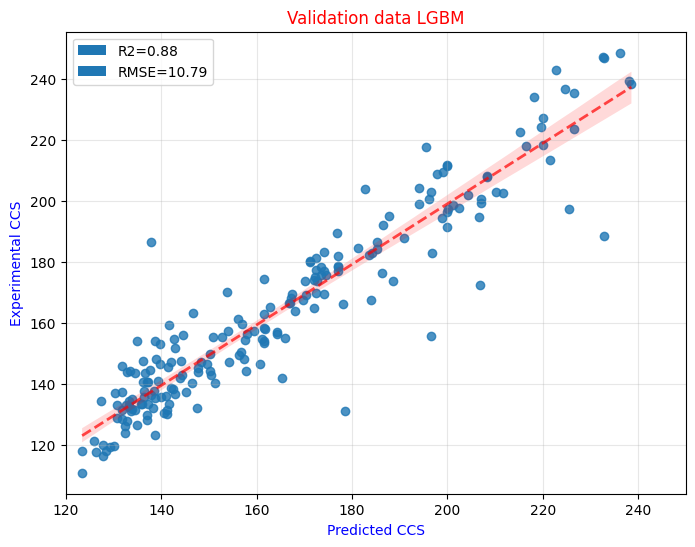

In [42]:
plot_data(y_valid_cor, y_preds_cor, "Validation data LGBM")

plt.savefig('data_LGBM.png')

data_to_save = pd.DataFrame({'True Values': y_valid_cor, 'Predicted Values': y_preds_cor})

# Deeplearning approach 

In [5]:
pip install tensorflow keras torch torchvision

  Using cached torchvision-0.20.1-cp311-cp311-win_amd64.whl.metadata (6.2 kB)
Using cached torchvision-0.20.1-cp311-cp311-win_amd64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [250]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(
    df_descriptors, data_cleaned_final.CCS, test_size=0.1, random_state=42
)

# Convert to DataFrame if not already
x_train_df = pd.DataFrame(x_train)
y_train_df = pd.Series(y_train)

# Initialize the imputer (replace NaNs with the mean of each column)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and validation data
x_train_imputed = imputer.fit_transform(x_train_df)
x_valid_imputed = imputer.transform(x_valid)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
x_train_scaled = scaler.fit_transform(x_train_imputed)

# Transform the validation data
x_valid_scaled = scaler.transform(x_valid_imputed)

# Set the variance threshold (e.g., 0.01) to remove features with low variance
selector = VarianceThreshold(threshold=0.01)

# Fit and transform the training data to remove low-variance features
x_train_selected = selector.fit_transform(x_train_scaled)

# Apply the same transformation to the validation data
x_valid_selected = selector.transform(x_valid_scaled)

# Print the number of features before and after selection
print(f"Original feature count: {x_train_scaled.shape[1]}")
print(f"Selected feature count: {x_train_selected.shape[1]}")


Original feature count: 210
Selected feature count: 180


In [251]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality while preserving 95% of variance
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train_selected)  # Apply PCA to the selected features
x_valid_pca = pca.transform(x_valid_selected)  # Apply PCA to the validation set

# Print the number of principal components
print(f"Number of principal components: {x_train_pca.shape[1]}")


Number of principal components: 52


In [252]:
from sklearn.preprocessing import StandardScaler

# Scale the data again if PCA or feature selection has changed the feature set
scaler = StandardScaler()

# Apply scaling to the new data after PCA or feature selection
x_train_scaled = scaler.fit_transform(x_train_pca)  # Or use x_train_selected if not using PCA
x_valid_scaled = scaler.transform(x_valid_pca)  # Or use x_valid_selected if not using PCA



In [253]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Input dimension is the number of RDKit descriptors
input_dim = x_train_scaled.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),  # First hidden layer
    Dropout(0.3),  # Regularization
    Dense(64, activation='relu'),  # Second hidden layer
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_scaled, y_train,
    validation_data=(x_valid_scaled, y_valid),
    epochs=10000,  # Adjust based on convergence
    batch_size=32,  # Adjust for your dataset size
    callbacks=[early_stopping]
)


Epoch 1/10000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 221.4514 - mae: 11.6906 - val_loss: 250.7790 - val_mae: 8.9208
Epoch 2/10000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 259.2274 - mae: 12.6595 - val_loss: 277.1741 - val_mae: 9.1124
Epoch 3/10000
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 135.6991 - mae: 9.9831

In [255]:
# Evaluate on the validation set
val_loss, val_mae = model.evaluate(x_valid_scaled, y_valid, verbose=0)

print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

Validation Loss: 254.7479705810547, Validation MAE: 9.289214134216309


In [256]:
import joblib

# Save the model
model.save('ccs_predictor_model.h5')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

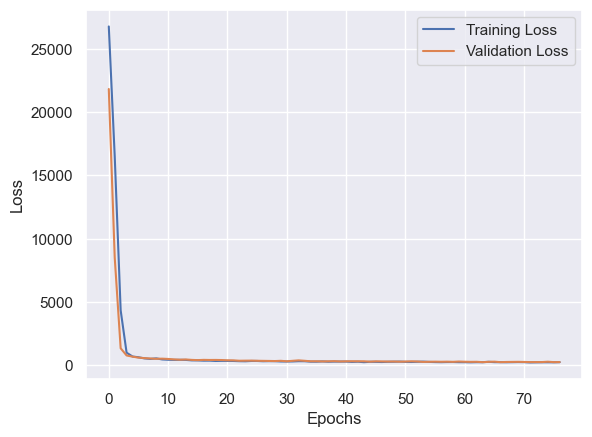

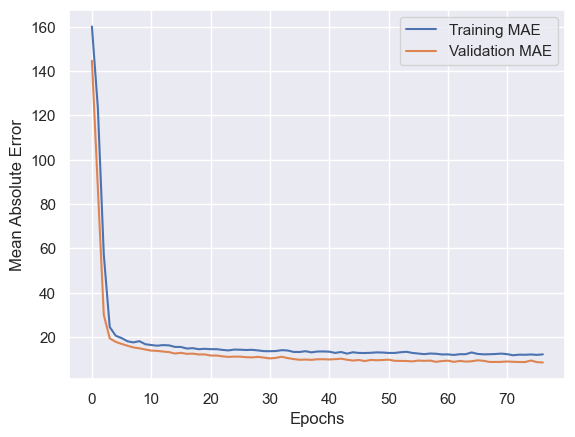

In [257]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


In [258]:
from sklearn.metrics import mean_absolute_error, r2_score

# Verify shapes of validation data
print(f"x_valid_scaled shape: {x_valid_scaled.shape}")
print(f"y_valid shape: {y_valid.shape}")

# Predict on validation set
y_valid_pred = model.predict(x_valid_scaled)

# Verify shape of predictions
print(f"y_valid_pred shape: {y_valid_pred.shape}")

# Flatten predictions to match target shape
y_valid_pred = y_valid_pred.flatten()

# Evaluate predictions
mae = mean_absolute_error(y_valid, y_valid_pred)
r2 = r2_score(y_valid, y_valid_pred)

print(f"Validation MAE: {mae}")
print(f"Validation R² Score: {r2}")


x_valid_scaled shape: (200, 52)
y_valid shape: (200,)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
y_valid_pred shape: (200, 1)
Validation MAE: 9.28921339416504
Validation R² Score: 0.7470352934726383


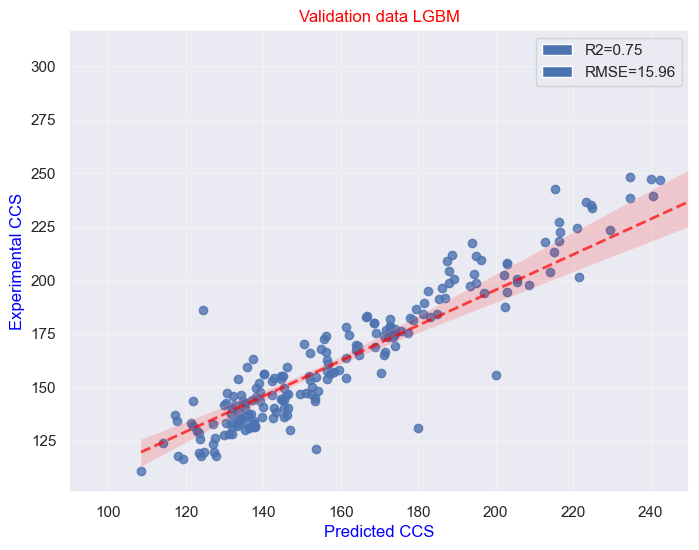

In [259]:
plot_data(y_valid, y_valid_pred, "Validation data LGBM")